In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from typhon import plots
import xarray as xr
from scipy import integrate
from scipy import optimize

import konrad

plots.styles.use('typhon')

In [2]:
cp_air = 1004.64 #J kg-1 K-1
g = 9.80665 #m s-2
print(konrad.constants.g)
Rd = 287.0570048852906 #J kg-1 K-1 air
print(konrad.constants.Rv)
Rv = 461.52280830495 #J kg-1 K-1 water vapor
Lv = 2501000 #J kg-1
eps = Rd/Rv #dimensionless
e_sat_ref = 610.94 #Pa, saturation water vapor pressure for Tref = 273.15 K
T_ref = 273.15 #K
seconds_day = 24*60*60 #seconds in a day

lapse_dry = -g/cp_air #K/m

9.80665
461.52280830495


In [3]:
100278.59/Lv

0.040095397840863654

In [4]:
4.87*365

1777.55

In [5]:
#WATER

def manabe_rh(rhs, p):
#    rh = np.maximum(0,rhs*(p/p[0]-0.02)/(1-0.02))
    rh = rhs*(p/p[0]-0.02)/(1-0.02)
    return rh

def fixed_rh(rhs,p):
    rh = np.ones_like(p)*rhs
    return rh
    
def rh_to_mmr(rh,T,p):
    mixing_ratio = rh_to_vmr(rh,T,p)*eps
    
    return mixing_ratio

def rh_to_vmr_fixed_strato(rh,T,p):
    mixing_ratio = np.maximum(5e-6,konrad.physics.relative_humidity2vmr(rh,p,T))
    
    return mixing_ratio

def rh_to_vmr(rh,T,p,itop):
    mixing_ratio = np.ones_like(T)
    vmr_itop = konrad.physics.relative_humidity2vmr(rh[itop],p[itop],T[itop])
    mixing_ratio[:itop] = konrad.physics.relative_humidity2vmr(rh[:itop],p[:itop],T[:itop])
    mixing_ratio[itop:] = vmr_itop
    
    return mixing_ratio

def vmr_to_rh(vmr,T,p):
    relative_humidity = konrad.physics.vmr2relative_humidity(vmr,p,T)
    
    return relative_humidity

def vmr_to_mmr(vmr):
    mass_mix = vmr*eps
    
    return mass_mix

def energy_to_water(energy):#kg m-2
    #if energy is in J s-1 m-2, comes back as kg s-1 m-2, ie, mm s-1 of precipitation
    # mass_atm = (p[0]-p[-1])/g
    mass_w = energy/Lv #* mass_atm
    return mass_w

def column_water_mass(vmr,ph): #kg m-2
    mmr = vmr_to_mmr(vmr) #kg kg-1
    dp = np.diff(ph)
    M_water = np.sum(-dp*mmr/g)
    
    return M_water
    
def opt_column_water_to_rh(M_water,T_atm,p,ph,itop):
    
    def fun(rhs):
        rh = manabe_rh(rhs, p)
        vmr = rh_to_vmr(rh,T_atm,p,itop)
        rh_w_mass = column_water_mass(vmr,ph)
        res = rh_w_mass - M_water
        return res
    
    rhs_opt = optimize.brentq(fun, 0., 2)
    rh_opt = manabe_rh(rhs_opt, p)
    return rh_opt

In [6]:
#AIR

def convective_top(T_con,T_rad):
    itop = np.where(T_radiation - atmosphere['T'][0] == 0)[0][0]
    if itop == 0:
        itop = np.where(T_radiation - atmosphere['T'][0] == 0)[0][1]
    
    return itop

def coldpoint(T):
    itop = np.where(np.diff(atmosphere['T'][0])>=0)[0][0]
    
    return itop

def height(p,T): #m
    rho = p/(Rd*T)
    z = integrate.cumulative_trapezoid(-1/(g*rho),p,initial = 0)
    return z

def MALR(T,p): #dlnT/dlnp
    r_sat = mmr_sat(T,p)
    A = (Lv*r_sat)/(Rd*T)
    B = (Lv**2*r_sat)/(cp_air*Rd*T**2)
    moist_lapse = - g/cp_air * (1+A)/(1+B)
    return moist_lapse

def T_MA(T_bl,p): #K
    T_atm = np.zeros((len(p)))
    T_atm[0] = T_bl
    for i in range(len(p)-1):
        lapse_z = MALR(T_atm[i],p[i])
        lapse_p = lapse_pressure(lapse_z)
        T_atm[i+1]=T_atm[i]*(p[i+1]/p[i])**(lapse_p)
    return T_atm

def lapse_pressure(lapse_z): #dlnT/dlnp, dT/dz
    l_p = -Rd/g * lapse_z
    return l_p


def T_atm_z(T_bl,z,lapse_z):
    Temp = T_bl + z*lapse_z
    return Temp

def T_atm_p(T_bl,p,lapse_p):
    Temp = T_bl * (p/p_s)**(lapse_p)
    return Temp

def moist_adiabat(p,T_bl,T_rad):
#    T_moist_ad = np.append(T_bl,konrad.lapserate.get_moist_adiabat(p,T_bl,T_min=0.))[:-1]
    T_moist_ad = konrad.lapserate.get_moist_adiabat(p,T_bl,T_min=0.)
    T_0 = (T_bl + T_moist_ad[0])/2
    T_moist_ad = np.append(T_0,T_moist_ad)[:-1]

    T_con = np.maximum(T_moist_ad,T_rad)
    
    return T_con

In [7]:
#FIRE

def TE(T,p): #J kg-1
    energy = integrate.trapz(-cp_air*T/g,p) #J m-2
    return energy #J m-2

def DSE(T,z,p): #J kg-1
    energy = integrate.trapz(-cp_air*T/g-z,p) #J m-2
    return energy #J m-2

def PE(z):
    energy = integrate.trapz(-z,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass

def T_bl_TE(thermal_energy, p, T_rad): #find T_bl conserving thermal energy
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        TE_moist = TE(T_atm)
        res = TE_moist-thermal_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    return T_bl


def T_convection_TE(p, T_rad, T_surface, SH): #find T after convective adjustment conserving thermal energy
    #note that here SH is the sensible heat for the whole timestep (J m-2) and not the flux itself (J m-2 s-1)
    thermal_energy = TE(T_rad,p) + SH
    tol = 10

    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        TE_moist = TE(T_atm,p)
        res = TE_moist - thermal_energy
        return res
    
    Tc = T_rad[0]
    Th = T_surface
    
    dpos = fun(Th)
    dneg = fun(Tc)
    
    if dneg > 0:
        print('Trad high already', dneg)
        ds = dneg
        dneg = 0
        Ts = Tc
    
    if dpos < 0:
        print('Tsurf low already', dpos)
        ds = dpos
        dpos = 0
        Ts = Th
        
    Ts = Tc + (Th-Tc) * -dneg/(-dneg+dpos)
    ds = fun(Ts)
#    print(ds)

    if ds > 0:
        dpos = ds
        Th = Ts
    else:
        dneg = ds
        Tc = Ts
    
    maxiter = 100
    k = 0
    while dpos>tol and np.abs(dneg)>tol and k < maxiter:
        Ts = Tc + (Th-Tc) * -dneg/(-dneg+dpos)
        ds = fun(Ts)
    #    print(ds)
        
        if ds > 0:
            dpos = ds
            Th = Ts
        else:
            dneg = ds
            Tc = Ts
        k += 1
        
    if k == 100:
        print(dpos, dneg, ds, Th, Tc, Ts, T_rad[0])
        print('reached max iter')
    T_bl = Ts
    T_con = moist_adiabat(p,T_bl,T_rad)

    return T_con, ds


def T_convection_DSE(p, T_rad): #find T after convective adjustment conserving dry static energy
    #note that here SH is the sensible heat for the whole timestep (J m-2) and not the flux itself (J m-2 s-1)
    z_rad = height(p,T_rad)
    dry_static_energy = DSE(T_rad,z_rad,p) + SH
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        z_atm = height(p,T_atm)
        DSE_moist = DSE(T_atm,z_atm,p)
        res = DSE_moist-dry_static_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    return T_bl

In [8]:
#EARTH

wind = 10 # wind speed m s-1
Cd = 0.001 # Drag coefficient unitless

def sensible_heat(T_bl,T_s,p_s): #sensible heat flux into the atmosphere (positive for heat trasnport into the atm)
    rho_s = p_s/(Rd*T_bl) #kg m-3
    sh = wind*Cd*rho_s*cp_air*(T_s-T_bl) #J s-1 m-2
    
    return sh

def latent_heat(vmr, T_bl, p_s): #sensible heat flux into the atmosphere (positive for heat trasnport into the atm)
    rho_s = p_s/(Rd*T_bl) #kg m-3
    
    rh = konrad.physics.vmr2relative_humidity(vmr,p_s,T_bl)
    mmr = vmr_to_mmr(vmr)
    mmr_sat = mmr/rh
    
    lh = wind*Cd*rho_s*Lv*(mmr_sat-mmr) #J s-1 m-2
    return lh

    
def SH_to_ws(T_bl,T_s,p_s,sh):
    rho_s = p_s/(Rd*T_bl) #kg m-3
    windspeed = sh/(Cd*rho_s*cp_air*(T_s-T_bl))
    
    return windspeed

In [9]:
%%time
#### PRECIPITATION TEST
heat_sink = 66.
opacity = 0.

plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=0,
    depth = 50)
radiation = konrad.radiation.RRTMG(solar_constant=551.58-opacity)
convection = konrad.convection.HardAdjustment()
lapserate = konrad.lapserate.MoistLapseRate()

conv_top = coldpoint(atmosphere['T'][0])

humidity = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(rh_surface=0.77),
)

RH = manabe_rh(0.77,atmosphere['plev'])
atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],conv_top)
M_w = column_water_mass(atmosphere['H2O'][0],atmosphere['phlev'])
print(M_w)

ndays = 15000
timestep = 0.5 #days
nsteps = int(ndays/timestep)

Bowen = 0.1
prec_eff = 1/(1+Bowen)
print(prec_eff)

printcounter = 0
status = 0

Ts_rec = []
Tbl_rec = []
rads_rec = []
rada_rec = []
LH_rec = []
SH_rec = []
PH_rec = []
ctop_rec = []
RHs_rec = []
P_rec = []

for i in range(nsteps):
    #update heating rates
    
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)
    
    rad_heat_atm = np.ones_like(radiation['net_htngrt'][0])
    
    rad_heat_atm[:] = - np.diff(radiation['lw_flxu'][0] + radiation['sw_flxu'][0]-
                             (radiation['lw_flxd'][0] + radiation['sw_flxd'][0]))
    
    troposphere_radiation = np.sum(rad_heat_atm[:conv_top])
    atm_rad = np.sum(rad_heat_atm[:])
     
    heating_rates = np.ones_like(rad_heat_atm)
    heating_rates[:] = ((rad_heat_atm[:])
                                 /cp_air * g/-np.diff(atmosphere['phlev'])[:] * seconds_day)

    #update net radiaiton at surface

    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    
    
    #temperature of atmosphere after radiative update

    atmosphere['T'] += heating_rates * timestep
    T_radiation = atmosphere['T'][0].copy()
    
#    print('pre rad',surface['temperature'])
        #update surface temperature with energetic fluxes (latent and radiative)
    surface['temperature'] += ((net_rad_surface)
                               * seconds_day * timestep / surface.heat_capacity)
    
    
    n_bl = 1
    vmr_bl = np.sum(atmosphere['H2O'][0,:n_bl])/n_bl
    old_T_bl = np.sum(T_radiation[:n_bl])/n_bl
    
    #    print('post rad',surface['temperature'])
    LH = latent_heat(vmr_bl, old_T_bl,atmosphere['phlev'][0])
    SH = sensible_heat(old_T_bl,surface['temperature'].copy(),atmosphere['phlev'][0])
#    print(SH,LH)
    
    prec_eff = np.minimum(1.,LH/(LH+SH))
#    print(prec_eff)
    

    status += 1
    Ts_rec.append(surface['temperature'].copy())
    Tbl_rec.append(old_T_bl)
    rads_rec.append(net_rad_surface)
    LH_rec.append(LH)
    SH_rec.append(SH)
    rada_rec.append(-troposphere_radiation)
    ctop_rec.append(conv_top)
#    Trad_rec.append(T_radiation)
    
    if printcounter == 200:
        print(status/2)
        printcounter = 0
    
    
    printcounter += 1
    #convective adjustment of surface and atmosphere (conserves thermal energy)
    surface['temperature'] += ((- SH - LH - heat_sink) 
                               * seconds_day * timestep / surface.heat_capacity)
    
    prec_heating = prec_eff * troposphere_radiation #amount of energy invested in precipitation
    prec_mass = prec_heating/Lv * seconds_day * timestep
    
    atmosphere['T'][0], E_dif = T_convection_TE(atmosphere['plev'], T_radiation, surface['temperature'],
                                         (SH - prec_heating) * seconds_day * timestep)

    prec_mass -= E_dif/Lv

    
    #water adjustment
    conv_top = convective_top(atmosphere['T'][0],T_radiation)
    cold_point = coldpoint(atmosphere['T'][0])
    M_w = column_water_mass(atmosphere['H2O'][0],atmosphere['phlev']) + prec_mass + LH/Lv *seconds_day*timestep
    
    RH = opt_column_water_to_rh(M_w,atmosphere['T'][0],
                                atmosphere['plev'],atmosphere['phlev'],cold_point)
    RHs_rec.append(RH[0])
    PH_rec.append(-prec_heating)
    
    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],cold_point)
    
atmosphere['CO2'][0] *= 2
for i in range(20000):
    #update heating rates
    
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)
    
    rad_heat_atm = np.ones_like(radiation['net_htngrt'][0])
    
    rad_heat_atm[:] = - np.diff(radiation['lw_flxu'][0] + radiation['sw_flxu'][0]-
                             (radiation['lw_flxd'][0] + radiation['sw_flxd'][0]))
    
    troposphere_radiation = np.sum(rad_heat_atm[:conv_top])
    atm_rad = np.sum(rad_heat_atm[:])
     
    heating_rates = np.ones_like(rad_heat_atm)
    heating_rates[:] = ((rad_heat_atm[:])
                                 /cp_air * g/-np.diff(atmosphere['phlev'])[:] * seconds_day)

    #update net radiaiton at surface

    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    
    
    #temperature of atmosphere after radiative update

    atmosphere['T'] += heating_rates * timestep
    T_radiation = atmosphere['T'][0].copy()
    
#    print('pre rad',surface['temperature'])
        #update surface temperature with energetic fluxes (latent and radiative)
    surface['temperature'] += ((net_rad_surface)
                               * seconds_day * timestep / surface.heat_capacity)
    
    
    n_bl = 1
    vmr_bl = np.sum(atmosphere['H2O'][0,:n_bl])/n_bl
    old_T_bl = np.sum(T_radiation[:n_bl])/n_bl
    
    #    print('post rad',surface['temperature'])
    LH = latent_heat(vmr_bl, old_T_bl,atmosphere['phlev'][0])
    SH = sensible_heat(old_T_bl,surface['temperature'].copy(),atmosphere['phlev'][0])
#    print(SH,LH)
    
    prec_eff = np.minimum(1.,LH/(LH+SH))
#    print(prec_eff)
    

    status += 1
    Ts_rec.append(surface['temperature'].copy())
    Tbl_rec.append(old_T_bl)
    rads_rec.append(net_rad_surface)
    LH_rec.append(LH)
    SH_rec.append(SH)
    rada_rec.append(-troposphere_radiation)
    ctop_rec.append(conv_top)
#    Trad_rec.append(T_radiation)
    
    if printcounter == 200:
        print(status/2)
        printcounter = 0
    
    
    printcounter += 1
    #convective adjustment of surface and atmosphere (conserves thermal energy)
    surface['temperature'] += ((- SH - LH - heat_sink) 
                               * seconds_day * timestep / surface.heat_capacity)
    
    prec_heating = prec_eff * troposphere_radiation #amount of energy invested in precipitation
    prec_mass = prec_heating/Lv * seconds_day * timestep
    
    atmosphere['T'][0], E_dif = T_convection_TE(atmosphere['plev'], T_radiation, surface['temperature'],
                                         (SH - prec_heating) * seconds_day * timestep)

    prec_mass -= E_dif/Lv

    
    #water adjustment
    conv_top = convective_top(atmosphere['T'][0],T_radiation)
    cold_point = coldpoint(atmosphere['T'][0])
    M_w = column_water_mass(atmosphere['H2O'][0],atmosphere['phlev']) + prec_mass + LH/Lv *seconds_day*timestep
    
    RH = opt_column_water_to_rh(M_w,atmosphere['T'][0],
                                atmosphere['plev'],atmosphere['phlev'],cold_point)
    RHs_rec.append(RH[0])
    PH_rec.append(-prec_heating)
    
    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],cold_point)

18.767710263973953
0.9090909090909091
100.5
Tsurf low already [-40404.09002686]
Tsurf low already [-77715.92992067]
Tsurf low already [-74809.82047272]
Tsurf low already [-72621.76966333]
Tsurf low already [-70907.16212654]
Tsurf low already [-69565.17566013]
Tsurf low already [-68506.58259678]
Tsurf low already [-67698.94817829]
Tsurf low already [-67091.16567421]
Tsurf low already [-66613.88681126]
Tsurf low already [-66211.87853909]
Tsurf low already [-65926.20822954]
Tsurf low already [-64403.82200146]
Tsurf low already [-65545.25304222]
Tsurf low already [-65409.22278166]
Tsurf low already [-65270.74876881]
Tsurf low already [-65176.55848646]
Tsurf low already [-65120.45798874]
Tsurf low already [-65040.6302619]
Tsurf low already [-65008.01824713]
Tsurf low already [-64981.90540743]
Tsurf low already [-64930.71190071]
Tsurf low already [-64933.27552128]
Tsurf low already [-64896.13275099]
Tsurf low already [-64871.41189861]
Tsurf low already [-64869.77255297]
Tsurf low already [-6

Tsurf low already [-63563.84303188]
Tsurf low already [-63540.11361647]
Tsurf low already [-63526.42893267]
Tsurf low already [-63514.82276106]
Tsurf low already [-63509.65469599]
Tsurf low already [-63493.2033987]
Tsurf low already [-63474.54572392]
Tsurf low already [-63471.80491972]
Tsurf low already [-63450.0376749]
Tsurf low already [-63444.25892973]
Tsurf low already [-63434.40880775]
Tsurf low already [-63430.72208214]
Tsurf low already [-63434.45857286]
Tsurf low already [-63425.53876448]
Tsurf low already [-63416.14109612]
Tsurf low already [-63415.54166603]
Tsurf low already [-63413.02983522]
Tsurf low already [-63411.07281017]
Tsurf low already [-63400.26263094]
Tsurf low already [-63395.99044704]
Tsurf low already [-63385.89958858]
Tsurf low already [-63386.85413074]
Tsurf low already [-63383.22849131]
Tsurf low already [-63378.5350337]
Tsurf low already [-63374.03197765]
Tsurf low already [-63369.5882864]
Tsurf low already [-63374.37664986]
Tsurf low already [-63377.900074

Tsurf low already [-62199.78292227]
Tsurf low already [-62193.75151682]
Tsurf low already [-62188.21872854]
Tsurf low already [-62180.58077574]
Tsurf low already [-62178.97176695]
Tsurf low already [-62177.97708988]
Tsurf low already [-62178.40365171]
Tsurf low already [-62181.71904802]
Tsurf low already [-62186.03173828]
Tsurf low already [-62186.98843765]
Tsurf low already [-62184.6441927]
Tsurf low already [-62197.97297001]
Tsurf low already [-62191.68666792]
Tsurf low already [-62184.1373601]
Tsurf low already [-62173.41957855]
Tsurf low already [-62169.7854476]
Tsurf low already [-62165.33465576]
Tsurf low already [-62157.72360802]
Tsurf low already [-62152.22608042]
Tsurf low already [-62142.62270689]
Tsurf low already [-62123.73084068]
Tsurf low already [-62126.51227093]
Tsurf low already [-62115.59583998]
Tsurf low already [-62112.35099602]
Tsurf low already [-62102.94068432]
Tsurf low already [-62098.41421795]
Tsurf low already [-62089.52906942]
Tsurf low already [-62084.31753

Tsurf low already [-61074.90641212]
Tsurf low already [-61080.08782482]
Tsurf low already [-61069.56513691]
Tsurf low already [-61062.44355297]
Tsurf low already [-61051.21105051]
Tsurf low already [-61050.9491148]
Tsurf low already [-61045.93142033]
Tsurf low already [-61044.52221203]
Tsurf low already [-61035.44374609]
Tsurf low already [-61029.86090326]
Tsurf low already [-61026.18026018]
Tsurf low already [-61027.13048029]
Tsurf low already [-61013.91343307]
Tsurf low already [-61011.65187168]
Tsurf low already [-61017.29463625]
Tsurf low already [-61013.52245522]
Tsurf low already [-61016.28917027]
Tsurf low already [-61007.00910234]
Tsurf low already [-61007.66002226]
Tsurf low already [-61006.21201086]
Tsurf low already [-61007.07888985]
Tsurf low already [-60991.58200979]
Tsurf low already [-60986.06348467]
Tsurf low already [-60978.26569796]
500.5
Tsurf low already [-60980.49064207]
Tsurf low already [-60977.63562632]
Tsurf low already [-60982.85242748]
Tsurf low already [-609

Tsurf low already [-60052.74028158]
Tsurf low already [-60045.02628136]
Tsurf low already [-60036.9102087]
Tsurf low already [-60038.73572302]
Tsurf low already [-60032.84559298]
Tsurf low already [-60023.21024227]
Tsurf low already [-60018.94237471]
Tsurf low already [-60006.77254438]
Tsurf low already [-59998.44484282]
Tsurf low already [-59992.7651186]
Tsurf low already [-59986.04512119]
Tsurf low already [-59980.15576124]
Tsurf low already [-59970.95103121]
Tsurf low already [-59965.44605684]
Tsurf low already [-59947.82777166]
Tsurf low already [-59945.26121283]
Tsurf low already [-59945.3705492]
Tsurf low already [-59955.48292923]
Tsurf low already [-59951.05486202]
Tsurf low already [-59943.46248245]
Tsurf low already [-59944.31286812]
Tsurf low already [-59940.55721807]
Tsurf low already [-59952.60702562]
Tsurf low already [-59964.43663692]
Tsurf low already [-59962.48880482]
Tsurf low already [-59941.87479305]
Tsurf low already [-59939.42391396]
Tsurf low already [-59931.40613

Tsurf low already [-59060.31206036]
Tsurf low already [-59060.09493208]
Tsurf low already [-59058.17746639]
Tsurf low already [-59065.99373198]
Tsurf low already [-59067.40136719]
Tsurf low already [-59064.40216112]
Tsurf low already [-59063.08982134]
Tsurf low already [-59048.5790534]
Tsurf low already [-59039.04369307]
Tsurf low already [-59034.83684778]
Tsurf low already [-59023.81800938]
Tsurf low already [-59015.47380829]
Tsurf low already [-59014.46077776]
Tsurf low already [-59012.18604708]
Tsurf low already [-59014.55742788]
Tsurf low already [-59008.87402582]
Tsurf low already [-59871.13184547]
Tsurf low already [-58970.14633179]
Tsurf low already [-58977.76443052]
Tsurf low already [-58980.43184185]
Tsurf low already [-58976.76025772]
Tsurf low already [-58976.54234457]
Tsurf low already [-58975.11876392]
Tsurf low already [-58964.74217701]
Tsurf low already [-58958.30493975]
Tsurf low already [-58955.91698456]
Tsurf low already [-58951.97325134]
Tsurf low already [-58943.566

Tsurf low already [-58141.71604824]
Tsurf low already [-58139.82674837]
Tsurf low already [-58145.5152154]
Tsurf low already [-58139.68808603]
Tsurf low already [-58130.9060545]
Tsurf low already [-58125.78775644]
Tsurf low already [-58127.5831275]
Tsurf low already [-58130.28975201]
Tsurf low already [-58133.67199421]
Tsurf low already [-58133.64305019]
Tsurf low already [-58131.82987928]
Tsurf low already [-58127.16208744]
Tsurf low already [-58125.60736942]
Tsurf low already [-58121.56158829]
Tsurf low already [-58115.74628019]
Tsurf low already [-58112.07581854]
Tsurf low already [-58107.14381409]
Tsurf low already [-58096.91919708]
Tsurf low already [-58076.02294207]
Tsurf low already [-58081.17857885]
Tsurf low already [-58078.43363047]
Tsurf low already [-58073.91073227]
Tsurf low already [-58069.27320623]
Tsurf low already [-58071.79612589]
Tsurf low already [-58072.30628967]
Tsurf low already [-58062.2052331]
Tsurf low already [-58061.47017336]
Tsurf low already [-58071.550615

Tsurf low already [-57325.12732124]
Tsurf low already [-57316.55175447]
Tsurf low already [-57316.77248669]
Tsurf low already [-57322.84546661]
Tsurf low already [-57317.97562504]
Tsurf low already [-57310.45709419]
Tsurf low already [-57305.32345915]
Tsurf low already [-57303.47085476]
Tsurf low already [-57298.08103848]
Tsurf low already [-57302.00773668]
Tsurf low already [-57290.83728933]
Tsurf low already [-57283.15789604]
Tsurf low already [-57275.58233643]
Tsurf low already [-57263.14890289]
Tsurf low already [-57255.32490444]
Tsurf low already [-57275.07532597]
Tsurf low already [-57265.42700005]
Tsurf low already [-57261.94484758]
Tsurf low already [-57254.21706772]
Tsurf low already [-56264.71521759]
Tsurf low already [-57289.27017546]
Tsurf low already [-57278.45457602]
Tsurf low already [-57266.98816729]
Tsurf low already [-57261.66952515]
Tsurf low already [-57250.12200689]
Tsurf low already [-57256.48014593]
Tsurf low already [-57251.02538538]
Tsurf low already [-57245.36

Tsurf low already [-56647.52750683]
Tsurf low already [-56643.68720531]
Tsurf low already [-56628.33841038]
Tsurf low already [-56632.10155916]
Tsurf low already [-56637.50602436]
Tsurf low already [-56635.20758343]
Tsurf low already [-56630.30000496]
Tsurf low already [-56624.5677619]
Tsurf low already [-56610.76745558]
Tsurf low already [-56602.98175478]
Tsurf low already [-56596.96648979]
Tsurf low already [-56592.90125465]
Tsurf low already [-56590.809793]
Tsurf low already [-56590.56424284]
Tsurf low already [-56587.75299168]
Tsurf low already [-56586.5863204]
Tsurf low already [-56577.65664244]
Tsurf low already [-56569.09831238]
Tsurf low already [-56570.01885653]
Tsurf low already [-56564.49198008]
Tsurf low already [-56578.51401472]
Tsurf low already [-56576.11001635]
Tsurf low already [-56567.89826965]
Tsurf low already [-56561.96458578]
Tsurf low already [-56558.34521198]
Tsurf low already [-56560.25624132]
Tsurf low already [-56554.93911266]
Tsurf low already [-56547.684425

Tsurf low already [-55974.74052858]
Tsurf low already [-55969.1492362]
Tsurf low already [-55956.70224476]
Tsurf low already [-55952.96840906]
Tsurf low already [-55952.53723621]
Tsurf low already [-55952.47066545]
Tsurf low already [-55952.47615576]
Tsurf low already [-55951.25875664]
Tsurf low already [-55945.99675274]
Tsurf low already [-55941.21888351]
Tsurf low already [-55939.5387001]
Tsurf low already [-55936.26016045]
Tsurf low already [-55934.40423536]
Tsurf low already [-55932.88178778]
Tsurf low already [-55933.17822886]
Tsurf low already [-55934.69689369]
Tsurf low already [-55934.90189457]
Tsurf low already [-55928.60807514]
Tsurf low already [-55925.23151922]
Tsurf low already [-55915.18672419]
Tsurf low already [-55910.54138279]
Tsurf low already [-55905.53117085]
Tsurf low already [-55903.40765285]
Tsurf low already [-55902.42529106]
Tsurf low already [-55912.78105497]
Tsurf low already [-55909.19379902]
Tsurf low already [-55907.81690502]
Tsurf low already [-55909.5748

Tsurf low already [-55361.03488636]
Tsurf low already [-55362.3793602]
Tsurf low already [-55357.19295025]
Tsurf low already [-55357.96898699]
Tsurf low already [-55359.66226768]
Tsurf low already [-55357.4023819]
Tsurf low already [-55354.24600935]
Tsurf low already [-55354.46427393]
Tsurf low already [-55351.03563786]
Tsurf low already [-55347.78999567]
Tsurf low already [-55350.18546009]
Tsurf low already [-55344.2452836]
Tsurf low already [-55346.90956545]
Tsurf low already [-55345.70139647]
Tsurf low already [-55353.25804615]
Tsurf low already [-55350.21687889]
Tsurf low already [-55348.53858852]
Tsurf low already [-55349.36044788]
Tsurf low already [-55347.22515297]
Tsurf low already [-55344.54400778]
Tsurf low already [-55339.32980156]
Tsurf low already [-55337.7175107]
Tsurf low already [-55327.47393894]
Tsurf low already [-55325.97179985]
Tsurf low already [-55328.11537409]
Tsurf low already [-55325.22923613]
Tsurf low already [-55316.03315878]
Tsurf low already [-55315.450954

Tsurf low already [-54876.27611589]
Tsurf low already [-54870.8635006]
Tsurf low already [-54863.53048801]
Tsurf low already [-54860.56416988]
Tsurf low already [-54864.56230021]
Tsurf low already [-54865.13829803]
Tsurf low already [-54858.09818554]
Tsurf low already [-54854.8345561]
Tsurf low already [-54854.57874012]
Tsurf low already [-54849.42118263]
Tsurf low already [-54845.98409605]
Tsurf low already [-54842.74983358]
Tsurf low already [-54834.20082378]
Tsurf low already [-54829.97587585]
Tsurf low already [-54829.9632411]
Tsurf low already [-54821.95374966]
Tsurf low already [-54816.71266556]
Tsurf low already [-54819.01820898]
Tsurf low already [-54815.84091663]
Tsurf low already [-54814.46832561]
Tsurf low already [-54811.82707691]
Tsurf low already [-54811.17713737]
Tsurf low already [-54804.8744874]
Tsurf low already [-54803.10864305]
Tsurf low already [-54796.34505081]
Tsurf low already [-54796.88574457]
Tsurf low already [-54796.68159533]
Tsurf low already [-54794.710584

Tsurf low already [-54333.93350077]
Tsurf low already [-54330.18898201]
Tsurf low already [-54325.07179213]
Tsurf low already [-54323.94691467]
Tsurf low already [-54322.96462154]
Tsurf low already [-54319.67609453]
Tsurf low already [-54318.92522717]
Tsurf low already [-54314.18000698]
Tsurf low already [-54318.47980785]
Tsurf low already [-54317.90293074]
Tsurf low already [-54317.91513777]
Tsurf low already [-54317.46486998]
Tsurf low already [-54323.31563044]
Tsurf low already [-54312.41363668]
Tsurf low already [-54311.56539011]
Tsurf low already [-54307.12378168]
Tsurf low already [-54306.74425316]
Tsurf low already [-54304.78213596]
Tsurf low already [-54304.72793531]
Tsurf low already [-54302.58457136]
Tsurf low already [-54300.25737619]
Tsurf low already [-54304.85086918]
Tsurf low already [-54306.91800117]
Tsurf low already [-54304.70837593]
Tsurf low already [-54303.85349846]
Tsurf low already [-54300.72343922]
Tsurf low already [-54299.79255676]
Tsurf low already [-54299.24

Tsurf low already [-53904.70469236]
Tsurf low already [-53901.80610275]
Tsurf low already [-53898.44519711]
Tsurf low already [-53897.56941557]
Tsurf low already [-53896.1314292]
Tsurf low already [-53891.10910797]
Tsurf low already [-53891.0514164]
Tsurf low already [-53888.46028852]
Tsurf low already [-53893.39022064]
Tsurf low already [-53891.25512838]
Tsurf low already [-53880.7652216]
Tsurf low already [-53878.37834501]
Tsurf low already [-53869.60507774]
Tsurf low already [-53871.47894478]
Tsurf low already [-53873.78058386]
Tsurf low already [-53879.66787052]
Tsurf low already [-53883.99148798]
Tsurf low already [-53884.52965117]
Tsurf low already [-53883.76449442]
Tsurf low already [-53880.45865297]
Tsurf low already [-53876.01374149]
Tsurf low already [-53882.79745388]
Tsurf low already [-53883.64845133]
Tsurf low already [-53882.39842987]
Tsurf low already [-53877.98796511]
Tsurf low already [-53876.45020247]
Tsurf low already [-53871.43017673]
Tsurf low already [-53868.30282

Tsurf low already [-53501.52970982]
Tsurf low already [-53501.78837204]
Tsurf low already [-53499.67495966]
Tsurf low already [-53493.42503309]
Tsurf low already [-53496.78078651]
Tsurf low already [-53494.19767094]
Tsurf low already [-53490.7159524]
Tsurf low already [-53486.98315382]
Tsurf low already [-53484.98136806]
Tsurf low already [-53483.76336956]
Tsurf low already [-53482.73342371]
Tsurf low already [-53480.93049288]
Tsurf low already [-53481.12334299]
Tsurf low already [-53481.73506689]
Tsurf low already [-53480.30203676]
Tsurf low already [-53481.62623549]
Tsurf low already [-53479.18762541]
Tsurf low already [-53476.25580645]
Tsurf low already [-53473.28818798]
Tsurf low already [-53470.80589008]
Tsurf low already [-53471.95210886]
Tsurf low already [-53470.28183317]
Tsurf low already [-53478.01878405]
Tsurf low already [-53474.62611246]
Tsurf low already [-53477.42422438]
Tsurf low already [-53460.24317026]
Tsurf low already [-53449.00395775]
Tsurf low already [-53440.715

Tsurf low already [-53144.93825197]
Tsurf low already [-53144.08434153]
Tsurf low already [-53144.46633625]
Tsurf low already [-53144.86279345]
Tsurf low already [-53145.20305634]
Tsurf low already [-53144.89781427]
Tsurf low already [-53142.81645727]
Tsurf low already [-53142.67336178]
Tsurf low already [-53139.4072485]
Tsurf low already [-53141.74720001]
Tsurf low already [-53137.72508669]
Tsurf low already [-53133.40687847]
Tsurf low already [-53129.30472755]
Tsurf low already [-53126.67530489]
Tsurf low already [-53121.56620026]
Tsurf low already [-53120.5324316]
Tsurf low already [-53123.74962664]
Tsurf low already [-53118.86847019]
Tsurf low already [-53121.7047925]
Tsurf low already [-53121.1301465]
Tsurf low already [-53119.69783831]
Tsurf low already [-53115.2852993]
Tsurf low already [-53120.10405636]
Tsurf low already [-53120.73763227]
Tsurf low already [-53117.83919096]
Tsurf low already [-53119.00066233]
Tsurf low already [-53118.67717743]
Tsurf low already [-53110.0320410

Tsurf low already [-52768.94747734]
Tsurf low already [-52772.74553251]
Tsurf low already [-52769.72596788]
Tsurf low already [-52769.50811863]
Tsurf low already [-52765.92871857]
Tsurf low already [-52763.00750589]
Tsurf low already [-52760.52154541]
Tsurf low already [-52762.41414928]
2000.5
Tsurf low already [-52765.93006659]
Tsurf low already [-52764.14170122]
Tsurf low already [-52769.90089703]
Tsurf low already [-52774.17269278]
Tsurf low already [-52772.41021538]
Tsurf low already [-52774.96046114]
Tsurf low already [-52775.772192]
Tsurf low already [-52777.96313429]
Tsurf low already [-52776.54764032]
Tsurf low already [-52764.84367847]
Tsurf low already [-52764.35393]
Tsurf low already [-52769.50971174]
Tsurf low already [-52770.82873774]
Tsurf low already [-52769.36365795]
Tsurf low already [-52774.40281057]
Tsurf low already [-52771.21033335]
Tsurf low already [-52769.96972704]
Tsurf low already [-52769.05570412]
Tsurf low already [-52771.3378458]
Tsurf low already [-52770.4

Tsurf low already [-52484.89983225]
Tsurf low already [-52473.41386366]
Tsurf low already [-52475.23880625]
Tsurf low already [-52474.67836809]
Tsurf low already [-52473.79092455]
Tsurf low already [-52473.63948011]
Tsurf low already [-52475.34894848]
Tsurf low already [-52473.95658922]
Tsurf low already [-52480.899158]
Tsurf low already [-52478.58696032]
Tsurf low already [-52475.56774378]
Tsurf low already [-52473.21865892]
Tsurf low already [-52474.92436171]
Tsurf low already [-52476.11818552]
Tsurf low already [-52471.48321724]
Tsurf low already [-52471.28795767]
Tsurf low already [-52469.99877882]
Tsurf low already [-52469.70580053]
Tsurf low already [-52467.26102209]
Tsurf low already [-52461.08132696]
Tsurf low already [-52458.62462044]
Tsurf low already [-52465.0625186]
Tsurf low already [-52466.89170313]
Tsurf low already [-52465.67924976]
Tsurf low already [-52464.82084751]
Tsurf low already [-52461.9127717]
Tsurf low already [-52459.67452955]
Tsurf low already [-52458.977469

Tsurf low already [-52207.56669617]
Tsurf low already [-52205.47849941]
Tsurf low already [-52201.89972878]
Tsurf low already [-52200.18880367]
Tsurf low already [-52199.87811184]
Tsurf low already [-52198.33935022]
Tsurf low already [-52190.80014086]
Tsurf low already [-52183.38940096]
Tsurf low already [-52184.30849075]
Tsurf low already [-52197.5114789]
Tsurf low already [-52197.43425798]
Tsurf low already [-52195.21318388]
Tsurf low already [-52197.17270041]
Tsurf low already [-52194.04339027]
Tsurf low already [-52192.62021017]
Tsurf low already [-52189.35475254]
Tsurf low already [-52186.13568115]
Tsurf low already [-52183.47197819]
Tsurf low already [-52182.22170925]
Tsurf low already [-52187.27890968]
Tsurf low already [-52186.90187502]
Tsurf low already [-52186.49418116]
Tsurf low already [-52185.3342824]
Tsurf low already [-52178.93164396]
Tsurf low already [-52178.45062447]
Tsurf low already [-52186.60472393]
Tsurf low already [-52194.3193121]
Tsurf low already [-52192.42775

Tsurf low already [-51960.88579607]
Tsurf low already [-51960.0659709]
Tsurf low already [-51956.92971325]
Tsurf low already [-51957.25794554]
Tsurf low already [-51948.61742258]
Tsurf low already [-51940.83964157]
Tsurf low already [-51937.93018627]
Tsurf low already [-51938.8580513]
Tsurf low already [-51948.60478878]
Tsurf low already [-51944.5019002]
Tsurf low already [-51941.87421799]
Tsurf low already [-51939.50688267]
Tsurf low already [-51936.28046942]
Tsurf low already [-51935.13207245]
Tsurf low already [-51929.5077734]
Tsurf low already [-51928.73893023]
Tsurf low already [-51928.1555562]
Tsurf low already [-51929.07015276]
Tsurf low already [-51927.71495485]
Tsurf low already [-51927.11770439]
Tsurf low already [-51917.98525047]
Tsurf low already [-51927.11665487]
Tsurf low already [-51924.87694359]
Tsurf low already [-51923.58588982]
Tsurf low already [-51922.96075153]
Tsurf low already [-51923.71578455]
Tsurf low already [-51923.30847549]
Tsurf low already [-51923.6101484

Tsurf low already [-51729.31516838]
Tsurf low already [-51726.84952641]
Tsurf low already [-51726.45227146]
Tsurf low already [-51725.20812416]
Tsurf low already [-51724.07199144]
Tsurf low already [-51721.54894066]
Tsurf low already [-51720.41482115]
Tsurf low already [-51720.61201429]
Tsurf low already [-51718.93800926]
Tsurf low already [-51714.62726307]
Tsurf low already [-51718.3994422]
Tsurf low already [-51715.11052036]
Tsurf low already [-51716.47292662]
Tsurf low already [-51716.48094654]
Tsurf low already [-51724.07221222]
Tsurf low already [-51722.61526346]
Tsurf low already [-51722.64700317]
Tsurf low already [-51718.36674547]
Tsurf low already [-51717.82197714]
Tsurf low already [-51713.40756845]
Tsurf low already [-51716.90050316]
Tsurf low already [-51714.02076721]
Tsurf low already [-51714.01724195]
Tsurf low already [-51714.22366333]
Tsurf low already [-51713.62930679]
Tsurf low already [-51710.13477373]
Tsurf low already [-51718.54227781]
Tsurf low already [-51713.499

Tsurf low already [-51490.53371954]
Tsurf low already [-51500.26134729]
Tsurf low already [-51501.58495951]
Tsurf low already [-51502.63220072]
Tsurf low already [-51498.84052992]
Tsurf low already [-51499.74044561]
Tsurf low already [-51502.12690496]
Tsurf low already [-51499.87600708]
Tsurf low already [-51496.41753912]
Tsurf low already [-51496.09205532]
Tsurf low already [-51493.50410461]
Tsurf low already [-51492.74493742]
Tsurf low already [-51493.85192442]
Tsurf low already [-51491.17302132]
Tsurf low already [-51490.79651785]
Tsurf low already [-51485.46522045]
Tsurf low already [-51486.29916477]
Tsurf low already [-51486.73038435]
Tsurf low already [-51487.27331734]
Tsurf low already [-51485.3094573]
Tsurf low already [-51485.69982767]
Tsurf low already [-51487.42769861]
Tsurf low already [-51484.69733143]
Tsurf low already [-51483.43630934]
Tsurf low already [-51481.5299964]
Tsurf low already [-51478.77098799]
Tsurf low already [-51478.25754786]
Tsurf low already [-51476.3858

Tsurf low already [-51275.87353992]
Tsurf low already [-51275.30149078]
Tsurf low already [-51271.07666874]
Tsurf low already [-51262.69413328]
Tsurf low already [-51259.76462078]
Tsurf low already [-51260.80273914]
Tsurf low already [-51259.83452225]
Tsurf low already [-51256.79849768]
Tsurf low already [-51256.08536196]
Tsurf low already [-51257.9890871]
Tsurf low already [-51254.31420565]
Tsurf low already [-51253.87789249]
Tsurf low already [-51252.35869646]
Tsurf low already [-51252.58138704]
Tsurf low already [-51253.5732317]
Tsurf low already [-51252.85298395]
Tsurf low already [-51250.85046387]
Tsurf low already [-51252.20825052]
Tsurf low already [-51254.2986455]
Tsurf low already [-51253.19876003]
Tsurf low already [-51252.55307674]
Tsurf low already [-51250.19744301]
Tsurf low already [-51249.96265125]
2700.5
Tsurf low already [-51254.09948921]
Tsurf low already [-51253.59928751]
Tsurf low already [-51258.24376726]
Tsurf low already [-51258.95412111]
Tsurf low already [-5125

Tsurf low already [-51131.31247282]
Tsurf low already [-51128.37503481]
Tsurf low already [-51125.65116644]
Tsurf low already [-51128.70779848]
Tsurf low already [-51131.05890131]
Tsurf low already [-51130.65891743]
Tsurf low already [-51128.55727386]
Tsurf low already [-51127.31776619]
Tsurf low already [-51124.63503075]
Tsurf low already [-51123.48306608]
Tsurf low already [-51123.81842852]
Tsurf low already [-51122.4278717]
Tsurf low already [-51121.71966839]
Tsurf low already [-51119.8613801]
Tsurf low already [-51118.51155281]
Tsurf low already [-51115.22580481]
Tsurf low already [-51112.86564112]
Tsurf low already [-51111.49283123]
Tsurf low already [-51108.90463018]
Tsurf low already [-51107.51536703]
Tsurf low already [-51106.32401037]
Tsurf low already [-51103.35285568]
Tsurf low already [-51099.99056005]
Tsurf low already [-51098.36414671]
Tsurf low already [-51103.39775562]
Tsurf low already [-51100.6610117]
Tsurf low already [-51098.54520798]
Tsurf low already [-51096.31487

Tsurf low already [-50931.25401735]
Tsurf low already [-50931.02533531]
Tsurf low already [-50926.13100719]
Tsurf low already [-50925.21270895]
Tsurf low already [-50933.13638783]
Tsurf low already [-50927.24300241]
Tsurf low already [-50926.42786312]
Tsurf low already [-50926.32915497]
Tsurf low already [-50926.72597265]
Tsurf low already [-50927.78929043]
Tsurf low already [-50923.84382248]
Tsurf low already [-50923.36679268]
Tsurf low already [-50932.67316723]
Tsurf low already [-50932.41713142]
Tsurf low already [-50934.39072514]
Tsurf low already [-50933.21601295]
Tsurf low already [-50931.20441628]
Tsurf low already [-50929.92573786]
Tsurf low already [-50928.07875347]
Tsurf low already [-50921.98971176]
Tsurf low already [-50920.19730091]
Tsurf low already [-50929.43767357]
Tsurf low already [-50929.69578218]
Tsurf low already [-50926.29130125]
Tsurf low already [-50924.65736151]
Tsurf low already [-50920.7113986]
Tsurf low already [-50917.24853659]
Tsurf low already [-50908.562

Tsurf low already [-50784.04597521]
Tsurf low already [-50784.86133814]
Tsurf low already [-50786.35037327]
Tsurf low already [-50783.17947245]
Tsurf low already [-50782.24959135]
Tsurf low already [-50781.42217016]
Tsurf low already [-50779.27080441]
Tsurf low already [-50777.02897406]
Tsurf low already [-50776.56236553]
Tsurf low already [-50775.57783556]
Tsurf low already [-50773.98236704]
Tsurf low already [-50773.69476604]
Tsurf low already [-50773.47679377]
Tsurf low already [-50773.8366704]
Tsurf low already [-50775.49202347]
Tsurf low already [-50773.97903967]
Tsurf low already [-50772.52214241]
Tsurf low already [-50777.05926514]
Tsurf low already [-50776.24000692]
Tsurf low already [-50777.67782259]
Tsurf low already [-50776.78637695]
Tsurf low already [-50774.8948698]
Tsurf low already [-50773.31900167]
Tsurf low already [-50775.46343327]
Tsurf low already [-50767.78184557]
Tsurf low already [-50769.62384701]
Tsurf low already [-50769.38928699]
Tsurf low already [-50768.2428

Tsurf low already [-50623.85443735]
Tsurf low already [-50620.56679106]
Tsurf low already [-50617.86954451]
Tsurf low already [-50614.64665794]
Tsurf low already [-50613.763906]
Tsurf low already [-50611.58174562]
Tsurf low already [-50612.66393614]
Tsurf low already [-50611.1944499]
Tsurf low already [-50609.42731905]
Tsurf low already [-50608.12276745]
Tsurf low already [-50606.9711833]
Tsurf low already [-50607.45514202]
Tsurf low already [-50608.59517145]
Tsurf low already [-50606.87863731]
Tsurf low already [-50609.34788322]
Tsurf low already [-50608.37701559]
Tsurf low already [-50609.50002718]
Tsurf low already [-50607.2846117]
Tsurf low already [-50604.67543268]
Tsurf low already [-50610.2351017]
Tsurf low already [-50608.40589952]
Tsurf low already [-50617.35402346]
Tsurf low already [-50614.40800285]
Tsurf low already [-50612.97461462]
Tsurf low already [-50611.08321953]
Tsurf low already [-50606.71536255]
Tsurf low already [-50602.80845737]
Tsurf low already [-50601.47086811

Tsurf low already [-50516.52079773]
Tsurf low already [-50516.45031738]
Tsurf low already [-50516.0354476]
Tsurf low already [-50522.46482182]
Tsurf low already [-50524.1144042]
Tsurf low already [-50523.97341776]
Tsurf low already [-50520.620368]
Tsurf low already [-50521.49333668]
Tsurf low already [-50522.63557482]
Tsurf low already [-50523.56951761]
Tsurf low already [-50522.61954308]
Tsurf low already [-50521.4147768]
Tsurf low already [-50523.01073456]
Tsurf low already [-50523.12680292]
Tsurf low already [-50525.58760214]
Tsurf low already [-50524.44194794]
Tsurf low already [-50525.09112549]
Tsurf low already [-50525.1560998]
Tsurf low already [-50522.96782875]
Tsurf low already [-50523.11207104]
Tsurf low already [-50522.32528353]
Tsurf low already [-50521.78856373]
Tsurf low already [-50521.17395735]
Tsurf low already [-50520.75305748]
Tsurf low already [-50515.06346416]
Tsurf low already [-50514.48440456]
Tsurf low already [-50514.5702858]
Tsurf low already [-50512.29037476]

Tsurf low already [-50362.51515627]
Tsurf low already [-50363.41836834]
Tsurf low already [-50362.96956587]
Tsurf low already [-50363.39751768]
Tsurf low already [-50360.53292227]
Tsurf low already [-50365.6029644]
Tsurf low already [-50361.04401636]
Tsurf low already [-50363.89227915]
Tsurf low already [-50361.77544212]
Tsurf low already [-50364.2907424]
Tsurf low already [-50360.19637346]
Tsurf low already [-50360.10544777]
Tsurf low already [-50361.80297422]
Tsurf low already [-50368.9623518]
Tsurf low already [-50366.23310184]
Tsurf low already [-50366.60816526]
Tsurf low already [-50362.19921446]
Tsurf low already [-50360.80539274]
Tsurf low already [-50360.11401844]
Tsurf low already [-50359.05874443]
Tsurf low already [-50360.27391148]
Tsurf low already [-50359.34937429]
Tsurf low already [-50358.33378077]
Tsurf low already [-50350.25041199]
Tsurf low already [-50352.30891705]
Tsurf low already [-50351.37700081]
Tsurf low already [-50351.37178755]
Tsurf low already [-50356.68206

Tsurf low already [-50260.27181435]
Tsurf low already [-50260.00422812]
Tsurf low already [-50259.84289789]
Tsurf low already [-50260.44186211]
Tsurf low already [-50261.02136326]
Tsurf low already [-50260.29220963]
3500.5
Tsurf low already [-50258.07232094]
Tsurf low already [-50254.1975255]
Tsurf low already [-50261.73153925]
Tsurf low already [-50258.82711983]
Tsurf low already [-50258.61158752]
Tsurf low already [-50257.97613001]
Tsurf low already [-50257.63590527]
Tsurf low already [-50257.08983755]
Tsurf low already [-50259.29387951]
Tsurf low already [-50259.34313154]
Tsurf low already [-50258.47224951]
Tsurf low already [-50257.40643501]
Tsurf low already [-50256.63839722]
Tsurf low already [-50256.21389246]
Tsurf low already [-50258.47668028]
Tsurf low already [-50257.42302752]
Tsurf low already [-50257.56518221]
Tsurf low already [-50257.64883947]
Tsurf low already [-50256.82678604]
Tsurf low already [-50256.12995338]
Tsurf low already [-50257.2797513]
Tsurf low already [-502

Tsurf low already [-50167.48342991]
Tsurf low already [-50167.73511553]
Tsurf low already [-50167.59786272]
Tsurf low already [-50167.30401707]
Tsurf low already [-50166.6040678]
Tsurf low already [-50165.83125496]
Tsurf low already [-50163.7187047]
Tsurf low already [-50163.77387142]
Tsurf low already [-50162.90732479]
Tsurf low already [-50163.50426769]
Tsurf low already [-50163.64097738]
Tsurf low already [-50165.54074192]
Tsurf low already [-50165.02317142]
Tsurf low already [-50164.41218328]
Tsurf low already [-50163.46341324]
Tsurf low already [-50162.82066631]
Tsurf low already [-50162.34162807]
Tsurf low already [-50161.27012157]
Tsurf low already [-50159.23818684]
Tsurf low already [-50158.35993624]
Tsurf low already [-50158.19506693]
Tsurf low already [-50157.99435234]
Tsurf low already [-50156.20593691]
Tsurf low already [-50156.28970385]
Tsurf low already [-50156.10408783]
Tsurf low already [-50155.89749193]
Tsurf low already [-50155.7028017]
Tsurf low already [-50155.34253

Tsurf low already [-50060.86306667]
Tsurf low already [-50060.44120312]
Tsurf low already [-50060.27378893]
Tsurf low already [-50059.60543966]
Tsurf low already [-50058.03538752]
Tsurf low already [-50057.72692347]
Tsurf low already [-50060.9963131]
Tsurf low already [-50059.0178051]
Tsurf low already [-50058.57640409]
Tsurf low already [-50059.93708706]
Tsurf low already [-50062.47150564]
Tsurf low already [-50061.78895664]
Tsurf low already [-50064.73245764]
Tsurf low already [-50064.8172102]
Tsurf low already [-50057.70478535]
Tsurf low already [-50058.44854069]
Tsurf low already [-50059.06332684]
Tsurf low already [-50059.91611576]
Tsurf low already [-50059.87092161]
Tsurf low already [-50059.97634125]
Tsurf low already [-50062.13145113]
Tsurf low already [-50063.29206133]
Tsurf low already [-50064.99489641]
Tsurf low already [-50064.02241707]
Tsurf low already [-50063.29208755]
Tsurf low already [-50060.58318186]
Tsurf low already [-50060.61442041]
Tsurf low already [-50060.21625

Tsurf low already [-49980.54026556]
Tsurf low already [-49978.58734322]
Tsurf low already [-49981.85617828]
Tsurf low already [-49981.49327469]
Tsurf low already [-49981.43109226]
Tsurf low already [-49979.99419641]
Tsurf low already [-49979.99298716]
Tsurf low already [-49979.87540102]
Tsurf low already [-49979.31031418]
Tsurf low already [-49979.0131979]
Tsurf low already [-49978.25902367]
Tsurf low already [-49978.69155884]
Tsurf low already [-49978.40206337]
Tsurf low already [-49978.68507576]
Tsurf low already [-49978.85943747]
Tsurf low already [-49977.55257511]
Tsurf low already [-49981.73367262]
Tsurf low already [-49981.10728121]
Tsurf low already [-49980.47574759]
Tsurf low already [-49982.01581526]
Tsurf low already [-49982.02466059]
Tsurf low already [-49982.49506855]
Tsurf low already [-49982.14783764]
Tsurf low already [-49981.72357178]
Tsurf low already [-49981.32736397]
Tsurf low already [-49978.72123146]
Tsurf low already [-49978.18040609]
Tsurf low already [-49977.999

Tsurf low already [-49907.3083148]
Tsurf low already [-49906.49129725]
Tsurf low already [-49905.88136816]
Tsurf low already [-49905.67563725]
Tsurf low already [-49909.13789749]
Tsurf low already [-49908.42802668]
Tsurf low already [-49907.97317362]
Tsurf low already [-49907.72044706]
Tsurf low already [-49906.40504169]
Tsurf low already [-49905.40631247]
Tsurf low already [-49905.00058222]
Tsurf low already [-49904.57096815]
Tsurf low already [-49905.59607363]
Tsurf low already [-49905.39855909]
Tsurf low already [-49902.36970711]
Tsurf low already [-49905.3720727]
Tsurf low already [-49901.94631767]
Tsurf low already [-49902.50285482]
Tsurf low already [-49905.15564251]
Tsurf low already [-49901.31553602]
Tsurf low already [-49902.5630784]
Tsurf low already [-49904.25896835]
Tsurf low already [-49900.91955566]
Tsurf low already [-49904.64366007]
Tsurf low already [-49903.46493626]
Tsurf low already [-49903.35868073]
Tsurf low already [-49905.22158527]
Tsurf low already [-49901.42161

Tsurf low already [-49846.96827173]
Tsurf low already [-49846.64102936]
Tsurf low already [-49846.57237291]
Tsurf low already [-49845.94897366]
Tsurf low already [-49845.66104841]
Tsurf low already [-49845.32638693]
Tsurf low already [-49846.79371452]
Tsurf low already [-49846.26601601]
Tsurf low already [-49845.62452364]
Tsurf low already [-49845.49596071]
Tsurf low already [-49844.40999317]
Tsurf low already [-49840.98778582]
Tsurf low already [-49843.51868963]
Tsurf low already [-49843.61217499]
Tsurf low already [-49843.5768714]
Tsurf low already [-49843.32970047]
Tsurf low already [-49842.8543849]
Tsurf low already [-49842.13922501]
Tsurf low already [-49840.82809782]
Tsurf low already [-49840.93312454]
Tsurf low already [-49841.88477087]
Tsurf low already [-49845.69589853]
Tsurf low already [-49847.14624262]
Tsurf low already [-49849.50402212]
Tsurf low already [-49849.72435474]
Tsurf low already [-49849.27894974]
Tsurf low already [-49849.01963186]
Tsurf low already [-49848.7816

Tsurf low already [-49774.05741262]
Tsurf low already [-49770.83488798]
Tsurf low already [-49770.16586304]
Tsurf low already [-49773.22823763]
Tsurf low already [-49768.06109142]
Tsurf low already [-49772.44574642]
Tsurf low already [-49772.05974627]
Tsurf low already [-49771.66164494]
Tsurf low already [-49771.30049372]
Tsurf low already [-49773.18883228]
Tsurf low already [-49770.27427483]
Tsurf low already [-49769.24674463]
Tsurf low already [-49768.24687004]
Tsurf low already [-49771.09280825]
Tsurf low already [-49770.91268349]
Tsurf low already [-49775.22674847]
Tsurf low already [-49775.15014744]
Tsurf low already [-49771.1361351]
Tsurf low already [-49770.27998686]
Tsurf low already [-49768.66978788]
Tsurf low already [-49769.1786294]
Tsurf low already [-49773.12403393]
Tsurf low already [-49772.3518672]
Tsurf low already [-49770.8637414]
Tsurf low already [-49770.24256754]
Tsurf low already [-49769.89414692]
Tsurf low already [-49769.2603159]
Tsurf low already [-49768.9696993

Tsurf low already [-49731.31947947]
Tsurf low already [-49730.74710369]
Tsurf low already [-49732.11286354]
Tsurf low already [-49731.13193226]
Tsurf low already [-49730.62099886]
Tsurf low already [-49729.70234728]
Tsurf low already [-49729.0991044]
Tsurf low already [-49728.25447083]
Tsurf low already [-49723.53121424]
Tsurf low already [-49722.19776583]
Tsurf low already [-49721.2205019]
Tsurf low already [-49720.13142347]
Tsurf low already [-49718.89271116]
Tsurf low already [-49719.30871248]
Tsurf low already [-49720.18612432]
Tsurf low already [-49719.14120483]
Tsurf low already [-49719.3354454]
Tsurf low already [-49719.04354811]
Tsurf low already [-49717.89276743]
Tsurf low already [-49717.76255894]
Tsurf low already [-49717.58987379]
Tsurf low already [-49716.38148212]
Tsurf low already [-49716.25836515]
Tsurf low already [-49715.62112427]
Tsurf low already [-49716.00314999]
Tsurf low already [-49716.19272852]
Tsurf low already [-49716.53093004]
Tsurf low already [-49716.20512

Tsurf low already [-49647.81482935]
Tsurf low already [-49647.3732996]
Tsurf low already [-49646.23027325]
Tsurf low already [-49645.90859365]
Tsurf low already [-49645.37514639]
Tsurf low already [-49644.79391718]
Tsurf low already [-49651.41777897]
Tsurf low already [-49650.11929417]
Tsurf low already [-49649.56281233]
Tsurf low already [-49648.5712347]
Tsurf low already [-49647.85381651]
Tsurf low already [-49648.7605629]
Tsurf low already [-49648.92955017]
Tsurf low already [-49642.19050932]
Tsurf low already [-49643.03360367]
Tsurf low already [-49643.5493679]
Tsurf low already [-49644.98351574]
Tsurf low already [-49645.38128614]
Tsurf low already [-49645.52781057]
Tsurf low already [-49645.97664309]
Tsurf low already [-49645.1386342]
Tsurf low already [-49645.01510143]
Tsurf low already [-49644.77220392]
Tsurf low already [-49644.67992353]
Tsurf low already [-49644.00157833]
Tsurf low already [-49644.70489836]
Tsurf low already [-49643.8860116]
Tsurf low already [-49643.63127136

Tsurf low already [-49601.42387772]
Tsurf low already [-49601.26178026]
Tsurf low already [-49601.43460655]
Tsurf low already [-49601.37615728]
Tsurf low already [-49601.0898757]
Tsurf low already [-49600.16774225]
Tsurf low already [-49600.32989883]
Tsurf low already [-49600.34044838]
Tsurf low already [-49600.36772871]
Tsurf low already [-49600.96322107]
Tsurf low already [-49600.67730236]
Tsurf low already [-49600.99049473]
Tsurf low already [-49598.8939991]
Tsurf low already [-49597.94218826]
Tsurf low already [-49597.35247517]
Tsurf low already [-49596.82619381]
Tsurf low already [-49596.73318815]
Tsurf low already [-49596.26289558]
Tsurf low already [-49595.85746527]
Tsurf low already [-49595.15932417]
Tsurf low already [-49594.62612915]
Tsurf low already [-49594.44488955]
Tsurf low already [-49593.34293509]
Tsurf low already [-49593.30306625]
Tsurf low already [-49593.00999641]
Tsurf low already [-49592.91535091]
Tsurf low already [-49593.35988188]
Tsurf low already [-49593.1945

Tsurf low already [-49566.53594637]
Tsurf low already [-49566.07199621]
Tsurf low already [-49566.07590771]
Tsurf low already [-49565.90899277]
Tsurf low already [-49564.90637255]
Tsurf low already [-49565.37177801]
Tsurf low already [-49564.45094585]
Tsurf low already [-49563.58295488]
Tsurf low already [-49563.2050457]
Tsurf low already [-49562.80267954]
Tsurf low already [-49563.98472261]
Tsurf low already [-49563.0964632]
Tsurf low already [-49562.78551817]
Tsurf low already [-49563.48862314]
Tsurf low already [-49563.1394763]
Tsurf low already [-49562.60245752]
Tsurf low already [-49562.27147865]
Tsurf low already [-49562.02178955]
Tsurf low already [-49561.68352699]
Tsurf low already [-49559.76062727]
Tsurf low already [-49559.24844074]
Tsurf low already [-49559.42010021]
Tsurf low already [-49559.37920094]
Tsurf low already [-49559.19077826]
Tsurf low already [-49559.09334898]
Tsurf low already [-49558.86314011]
Tsurf low already [-49559.54403687]
Tsurf low already [-49559.38557

Tsurf low already [-49549.02668905]
Tsurf low already [-49549.14419985]
Tsurf low already [-49549.32637787]
Tsurf low already [-49549.25670052]
Tsurf low already [-49549.35718298]
Tsurf low already [-49549.19272041]
Tsurf low already [-49549.27724504]
Tsurf low already [-49549.37502241]
Tsurf low already [-49549.28578758]
Tsurf low already [-49549.03098726]
Tsurf low already [-49548.41349411]
Tsurf low already [-49548.0149951]
Tsurf low already [-49547.86406803]
Tsurf low already [-49547.43581963]
Tsurf low already [-49547.31683922]
Tsurf low already [-49546.16185999]
Tsurf low already [-49546.54483414]
Tsurf low already [-49546.0088954]
Tsurf low already [-49550.66845846]
Tsurf low already [-49549.7294364]
Tsurf low already [-49549.00771952]
Tsurf low already [-49548.39307022]
Tsurf low already [-49547.79198456]
Tsurf low already [-49547.48844004]
Tsurf low already [-49547.12737608]
Tsurf low already [-49546.72295332]
Tsurf low already [-49545.23065567]
Tsurf low already [-49544.41448

Tsurf low already [-49503.05375862]
Tsurf low already [-49502.75200319]
Tsurf low already [-49502.42149305]
Tsurf low already [-49499.55724382]
Tsurf low already [-49502.32250547]
Tsurf low already [-49500.95620298]
Tsurf low already [-49501.81545639]
Tsurf low already [-49499.01002979]
Tsurf low already [-49501.90527344]
Tsurf low already [-49502.36687469]
Tsurf low already [-49499.09828949]
Tsurf low already [-49502.59244013]
Tsurf low already [-49502.4045434]
Tsurf low already [-49498.75917292]
Tsurf low already [-49502.33424616]
Tsurf low already [-49502.78275967]
Tsurf low already [-49499.93331528]
Tsurf low already [-49502.25257397]
Tsurf low already [-49507.0589118]
Tsurf low already [-49504.53699446]
Tsurf low already [-49506.68816519]
Tsurf low already [-49506.12449121]
Tsurf low already [-49503.26986742]
Tsurf low already [-49504.82851744]
Tsurf low already [-49502.14873362]
Tsurf low already [-49505.21169615]
Tsurf low already [-49504.80459118]
Tsurf low already [-49501.8901

Tsurf low already [-49417.25624323]
Tsurf low already [-49418.41571903]
Tsurf low already [-49419.37821436]
Tsurf low already [-49418.79154778]
Tsurf low already [-49418.86971903]
Tsurf low already [-49418.8778038]
Tsurf low already [-49418.17490911]
Tsurf low already [-49417.39489937]
Tsurf low already [-49416.89080381]
Tsurf low already [-49417.35067701]
Tsurf low already [-49417.17430687]
Tsurf low already [-49417.89742661]
Tsurf low already [-49417.27733803]
Tsurf low already [-49417.51557207]
Tsurf low already [-49418.64127827]
Tsurf low already [-49418.52036238]
Tsurf low already [-49418.47389984]
5000.5
Tsurf low already [-49418.46046114]
Tsurf low already [-49418.3346653]
Tsurf low already [-49418.01767921]
Tsurf low already [-49418.01221514]
Tsurf low already [-49417.67184258]
Tsurf low already [-49417.41734934]
Tsurf low already [-49416.9456439]
Tsurf low already [-49417.24955463]
Tsurf low already [-49416.93922472]
Tsurf low already [-49414.61224985]
Tsurf low already [-4941

Tsurf low already [-49392.48391533]
Tsurf low already [-49391.63772058]
Tsurf low already [-49390.8395009]
Tsurf low already [-49390.2745862]
Tsurf low already [-49389.02036762]
Tsurf low already [-49387.81035423]
Tsurf low already [-49387.8364563]
Tsurf low already [-49387.51617241]
Tsurf low already [-49387.63387632]
Tsurf low already [-49386.90230703]
Tsurf low already [-49386.96812916]
Tsurf low already [-49386.98575592]
Tsurf low already [-49384.12169456]
Tsurf low already [-49387.8307395]
Tsurf low already [-49387.88665581]
Tsurf low already [-49387.68956518]
Tsurf low already [-49387.50548649]
Tsurf low already [-49385.89492846]
Tsurf low already [-49389.42741156]
Tsurf low already [-49388.58847475]
Tsurf low already [-49388.30778265]
Tsurf low already [-49385.77147293]
Tsurf low already [-49389.33236933]
Tsurf low already [-49388.8294549]
Tsurf low already [-49385.93879747]
Tsurf low already [-49388.92865896]
Tsurf low already [-49388.4335165]
Tsurf low already [-49385.47980118

Tsurf low already [-49372.72034168]
Tsurf low already [-49372.43704319]
Tsurf low already [-49371.37751579]
Tsurf low already [-49364.10053778]
Tsurf low already [-49365.16319513]
Tsurf low already [-49365.78107023]
Tsurf low already [-49366.31944418]
Tsurf low already [-49366.74444199]
Tsurf low already [-49366.91590357]
Tsurf low already [-49367.09003496]
Tsurf low already [-49367.15155172]
Tsurf low already [-49367.17874718]
Tsurf low already [-49367.09642172]
Tsurf low already [-49367.0088129]
Tsurf low already [-49366.93277597]
Tsurf low already [-49366.58902025]
Tsurf low already [-49366.5300684]
Tsurf low already [-49365.82125139]
Tsurf low already [-49365.78987598]
Tsurf low already [-49365.81521654]
Tsurf low already [-49365.38043022]
Tsurf low already [-49366.16149378]
Tsurf low already [-49365.28723621]
Tsurf low already [-49365.47637653]
Tsurf low already [-49365.67523146]
Tsurf low already [-49365.86821508]
Tsurf low already [-49366.43332386]
Tsurf low already [-49366.3961

Tsurf low already [-49342.99720001]
Tsurf low already [-49342.79155493]
Tsurf low already [-49342.71642542]
Tsurf low already [-49343.84528112]
Tsurf low already [-49343.7064743]
Tsurf low already [-49342.91987419]
Tsurf low already [-49342.9532094]
Tsurf low already [-49342.47843552]
Tsurf low already [-49342.05309296]
Tsurf low already [-49341.90992069]
Tsurf low already [-49341.50886393]
Tsurf low already [-49341.42808914]
Tsurf low already [-49346.62147617]
Tsurf low already [-49345.44544697]
Tsurf low already [-49344.64068174]
Tsurf low already [-49343.80426979]
Tsurf low already [-49343.42808533]
Tsurf low already [-49343.21782017]
Tsurf low already [-49342.9367404]
Tsurf low already [-49342.02473831]
Tsurf low already [-49341.46137333]
Tsurf low already [-49340.68202066]
Tsurf low already [-49340.54725838]
Tsurf low already [-49340.43971968]
Tsurf low already [-49340.51665831]
Tsurf low already [-49340.4776988]
Tsurf low already [-49339.96243763]
Tsurf low already [-49339.986464

Tsurf low already [-49322.3936615]
Tsurf low already [-49321.7289362]
Tsurf low already [-49321.53846598]
Tsurf low already [-49321.34532261]
Tsurf low already [-49321.4838376]
Tsurf low already [-49321.18937874]
Tsurf low already [-49321.40005875]
Tsurf low already [-49321.53288603]
Tsurf low already [-49321.39088821]
Tsurf low already [-49321.42438698]
Tsurf low already [-49320.92183399]
Tsurf low already [-49331.1351037]
Tsurf low already [-49329.04972219]
Tsurf low already [-49327.67146921]
Tsurf low already [-49326.57659483]
Tsurf low already [-49325.92992592]
Tsurf low already [-49325.23116064]
Tsurf low already [-49324.55042648]
Tsurf low already [-49324.10036039]
Tsurf low already [-49323.20997]
Tsurf low already [-49322.87588072]
Tsurf low already [-49322.08701944]
Tsurf low already [-49322.14932251]
Tsurf low already [-49322.04114008]
Tsurf low already [-49321.56865644]
Tsurf low already [-49321.53910017]
Tsurf low already [-49321.44968748]
Tsurf low already [-49320.36398172]

Tsurf low already [-49313.8841877]
Tsurf low already [-49313.61379051]
Tsurf low already [-49313.39003515]
Tsurf low already [-49310.77412367]
Tsurf low already [-49313.70065546]
Tsurf low already [-49313.23651981]
Tsurf low already [-49312.96161747]
Tsurf low already [-49310.28916502]
Tsurf low already [-49312.99211073]
Tsurf low already [-49312.65839386]
Tsurf low already [-49312.07228041]
Tsurf low already [-49309.50827694]
Tsurf low already [-49312.35609722]
Tsurf low already [-49312.0149579]
Tsurf low already [-49309.2283268]
Tsurf low already [-49312.09355354]
Tsurf low already [-49311.70323515]
Tsurf low already [-49311.28749228]
Tsurf low already [-49308.64800835]
Tsurf low already [-49312.56918335]
Tsurf low already [-49313.27076435]
Tsurf low already [-49310.4151845]
Tsurf low already [-49312.91011333]
Tsurf low already [-49312.32087135]
Tsurf low already [-49309.05757809]
Tsurf low already [-49312.05468225]
Tsurf low already [-49311.12766695]
Tsurf low already [-49308.638969

Tsurf low already [-49283.19372654]
Tsurf low already [-49279.92451859]
Tsurf low already [-49283.0584259]
Tsurf low already [-49279.70734501]
Tsurf low already [-49282.04137373]
Tsurf low already [-49278.96797276]
Tsurf low already [-49282.22151995]
Tsurf low already [-49281.60730362]
Tsurf low already [-49284.41853666]
Tsurf low already [-49280.91022205]
Tsurf low already [-49283.80680943]
Tsurf low already [-49280.36842918]
Tsurf low already [-49283.17316866]
Tsurf low already [-49280.18554401]
Tsurf low already [-49280.51284885]
Tsurf low already [-49283.40991306]
Tsurf low already [-49279.96747494]
Tsurf low already [-49283.1922617]
Tsurf low already [-49279.77029228]
Tsurf low already [-49273.4091258]
Tsurf low already [-49277.45564747]
Tsurf low already [-49274.62849236]
Tsurf low already [-49275.73585176]
Tsurf low already [-49279.45710039]
5700.5
Tsurf low already [-49276.27707148]
Tsurf low already [-49276.95292234]
Tsurf low already [-49277.46720695]
Tsurf low already [-4928

Tsurf low already [-49264.97599792]
Tsurf low already [-49264.49787998]
Tsurf low already [-49264.32707977]
Tsurf low already [-49264.26709604]
Tsurf low already [-49264.02255487]
Tsurf low already [-49263.48940706]
Tsurf low already [-49263.57480764]
Tsurf low already [-49263.58695269]
Tsurf low already [-49263.58376503]
Tsurf low already [-49263.54622126]
Tsurf low already [-49263.47611237]
Tsurf low already [-49263.36397219]
Tsurf low already [-49263.2758441]
Tsurf low already [-49263.1860013]
Tsurf low already [-49263.07608223]
Tsurf low already [-49262.8811717]
Tsurf low already [-49262.75530672]
Tsurf low already [-49262.53055048]
Tsurf low already [-49262.67619658]
Tsurf low already [-49262.56904125]
Tsurf low already [-49262.44320917]
Tsurf low already [-49262.34577131]
Tsurf low already [-49262.22968864]
Tsurf low already [-49262.52982426]
Tsurf low already [-49262.28387308]
Tsurf low already [-49262.12469482]
Tsurf low already [-49261.97678804]
Tsurf low already [-49261.82473

Tsurf low already [-49251.96872282]
Tsurf low already [-49248.96416187]
Tsurf low already [-49251.39137459]
Tsurf low already [-49248.51883793]
Tsurf low already [-49248.923388]
Tsurf low already [-49251.87410498]
Tsurf low already [-49248.72475576]
Tsurf low already [-49251.52601814]
Tsurf low already [-49248.5385375]
Tsurf low already [-49251.03522539]
Tsurf low already [-49248.12367344]
Tsurf low already [-49247.93271399]
Tsurf low already [-49250.70434093]
Tsurf low already [-49247.83362198]
Tsurf low already [-49250.6832571]
Tsurf low already [-49247.45830584]
Tsurf low already [-49247.91501427]
Tsurf low already [-49250.6812458]
Tsurf low already [-49248.05246592]
Tsurf low already [-49248.32986355]
Tsurf low already [-49252.77921963]
Tsurf low already [-49249.42843628]
Tsurf low already [-49249.49850273]
Tsurf low already [-49251.3392539]
Tsurf low already [-49248.31626177]
Tsurf low already [-49248.21235323]
Tsurf low already [-49250.50467157]
Tsurf low already [-49247.54268646

Tsurf low already [-49221.59210825]
Tsurf low already [-49221.10662508]
Tsurf low already [-49221.04650307]
Tsurf low already [-49220.97426891]
Tsurf low already [-49221.21035957]
Tsurf low already [-49221.04292631]
Tsurf low already [-49220.80651617]
Tsurf low already [-49220.29475832]
Tsurf low already [-49220.29594755]
Tsurf low already [-49219.89981127]
Tsurf low already [-49219.71259165]
Tsurf low already [-49219.33868551]
Tsurf low already [-49219.23719835]
Tsurf low already [-49219.15507746]
Tsurf low already [-49219.03350544]
Tsurf low already [-49219.64251614]
Tsurf low already [-49219.38196373]
Tsurf low already [-49219.26046324]
Tsurf low already [-49219.13137817]
Tsurf low already [-49218.6200819]
Tsurf low already [-49218.51955795]
Tsurf low already [-49218.45347834]
Tsurf low already [-49218.38037539]
Tsurf low already [-49218.35645103]
Tsurf low already [-49218.11802769]
Tsurf low already [-49218.03798103]
Tsurf low already [-49217.97043848]
Tsurf low already [-49217.862

Tsurf low already [-49200.54398537]
Tsurf low already [-49200.76100826]
Tsurf low already [-49200.9018302]
Tsurf low already [-49200.98453474]
Tsurf low already [-49199.13807011]
Tsurf low already [-49199.34066343]
Tsurf low already [-49199.46929789]
Tsurf low already [-49199.28579235]
Tsurf low already [-49199.40529966]
Tsurf low already [-49200.05545759]
Tsurf low already [-49200.06153393]
Tsurf low already [-49200.0267725]
Tsurf low already [-49199.99221945]
Tsurf low already [-49200.054142]
Tsurf low already [-49200.11670256]
Tsurf low already [-49200.10659599]
Tsurf low already [-49200.68170786]
Tsurf low already [-49200.58832932]
Tsurf low already [-49203.56029224]
Tsurf low already [-49203.41598082]
Tsurf low already [-49203.40641499]
Tsurf low already [-49202.50341415]
Tsurf low already [-49202.73225927]
Tsurf low already [-49202.88171053]
Tsurf low already [-49202.9692111]
Tsurf low already [-49202.93050098]
Tsurf low already [-49202.85278177]
Tsurf low already [-49202.9016189

Tsurf low already [-49171.44486284]
Tsurf low already [-49171.40633965]
Tsurf low already [-49171.35178709]
Tsurf low already [-49173.5978179]
Tsurf low already [-49173.03540993]
Tsurf low already [-49172.40025282]
Tsurf low already [-49172.27254152]
Tsurf low already [-49172.15173769]
Tsurf low already [-49172.04078054]
Tsurf low already [-49171.92164278]
Tsurf low already [-49171.78340864]
Tsurf low already [-49171.68096113]
Tsurf low already [-49171.56575632]
Tsurf low already [-49171.46935225]
Tsurf low already [-49171.37212658]
Tsurf low already [-49171.64035034]
Tsurf low already [-49171.53188944]
Tsurf low already [-49171.05900478]
Tsurf low already [-49171.1282568]
Tsurf low already [-49173.90846157]
Tsurf low already [-49173.39258385]
Tsurf low already [-49173.13005877]
Tsurf low already [-49173.08983088]
Tsurf low already [-49172.69377851]
Tsurf low already [-49172.56906033]
Tsurf low already [-49172.49173021]
Tsurf low already [-49172.37721205]
Tsurf low already [-49172.2663

Tsurf low already [-49174.45138264]
Tsurf low already [-49174.386868]
Tsurf low already [-49174.37605715]
Tsurf low already [-49174.27296257]
Tsurf low already [-49174.19270182]
Tsurf low already [-49174.04800129]
Tsurf low already [-49173.967556]
Tsurf low already [-49173.8726635]
Tsurf low already [-49173.12078762]
Tsurf low already [-49173.25350618]
Tsurf low already [-49173.21810818]
Tsurf low already [-49173.29700518]
Tsurf low already [-49172.38305426]
Tsurf low already [-49172.10435247]
Tsurf low already [-49171.86820936]
Tsurf low already [-49171.66469383]
Tsurf low already [-49171.48600483]
Tsurf low already [-49171.15235519]
Tsurf low already [-49171.061975]
Tsurf low already [-49170.96748066]
Tsurf low already [-49170.81470394]
Tsurf low already [-49170.65823889]
Tsurf low already [-49170.51598835]
Tsurf low already [-49170.38480091]
Tsurf low already [-49170.26233768]
Tsurf low already [-49170.19292593]
Tsurf low already [-49170.07995892]
Tsurf low already [-49169.96202898]

Tsurf low already [-49172.33163404]
Tsurf low already [-49172.28411388]
Tsurf low already [-49172.17527246]
Tsurf low already [-49172.12610006]
Tsurf low already [-49171.1547904]
Tsurf low already [-49171.29344797]
Tsurf low already [-49171.14456081]
Tsurf low already [-49171.65357161]
6500.5
Tsurf low already [-49171.7531085]
Tsurf low already [-49171.81637383]
Tsurf low already [-49171.8251462]
Tsurf low already [-49175.47291899]
Tsurf low already [-49175.09631968]
Tsurf low already [-49174.66248989]
Tsurf low already [-49174.42318153]
Tsurf low already [-49174.23801804]
Tsurf low already [-49174.08759737]
Tsurf low already [-49173.95294571]
Tsurf low already [-49173.83099556]
Tsurf low already [-49173.59437418]
Tsurf low already [-49173.65102625]
Tsurf low already [-49173.53557205]
Tsurf low already [-49173.4610076]
Tsurf low already [-49173.38483238]
Tsurf low already [-49173.19895363]
Tsurf low already [-49172.703197]
Tsurf low already [-49172.674932]
Tsurf low already [-49172.634

Tsurf low already [-49165.05397606]
Tsurf low already [-49165.03134251]
Tsurf low already [-49162.55157614]
Tsurf low already [-49165.47967339]
Tsurf low already [-49165.19636631]
Tsurf low already [-49164.92096806]
Tsurf low already [-49162.39852285]
Tsurf low already [-49165.30840969]
Tsurf low already [-49164.96057415]
Tsurf low already [-49162.38346004]
Tsurf low already [-49165.20490122]
Tsurf low already [-49164.87064028]
Tsurf low already [-49164.59354067]
Tsurf low already [-49161.9891777]
Tsurf low already [-49164.83986616]
Tsurf low already [-49164.48666239]
Tsurf low already [-49164.21016979]
Tsurf low already [-49161.64097452]
Tsurf low already [-49164.41189051]
Tsurf low already [-49164.09097433]
Tsurf low already [-49161.60082436]
Tsurf low already [-49164.4786129]
Tsurf low already [-49164.20843077]
Tsurf low already [-49161.6051259]
Tsurf low already [-49164.48272467]
Tsurf low already [-49164.07537651]
Tsurf low already [-49163.82522631]
Tsurf low already [-49161.28040

Tsurf low already [-49152.05589199]
Tsurf low already [-49149.27032089]
Tsurf low already [-49149.68329906]
Tsurf low already [-49152.26805592]
Tsurf low already [-49149.3853302]
Tsurf low already [-49149.68011761]
Tsurf low already [-49152.08059025]
Tsurf low already [-49149.20532656]
Tsurf low already [-49148.77127504]
Tsurf low already [-49151.44833231]
Tsurf low already [-49148.72193527]
Tsurf low already [-49149.07053614]
Tsurf low already [-49151.63798046]
Tsurf low already [-49148.81050777]
Tsurf low already [-49149.13557863]
Tsurf low already [-49151.70576096]
Tsurf low already [-49148.57310486]
Tsurf low already [-49148.62272024]
Tsurf low already [-49151.29806137]
Tsurf low already [-49148.48757935]
Tsurf low already [-49148.83469534]
Tsurf low already [-49151.40999937]
Tsurf low already [-49148.69709587]
Tsurf low already [-49148.40856934]
Tsurf low already [-49150.87455225]
Tsurf low already [-49148.19440126]
Tsurf low already [-49148.63246965]
Tsurf low already [-49151.288

Tsurf low already [-49141.72610474]
Tsurf low already [-49141.43231058]
Tsurf low already [-49141.46821117]
Tsurf low already [-49141.47961903]
Tsurf low already [-49141.46424246]
Tsurf low already [-49141.44278526]
Tsurf low already [-49141.41456699]
Tsurf low already [-49140.56961632]
Tsurf low already [-49140.63326836]
Tsurf low already [-49140.67021513]
Tsurf low already [-49140.68273306]
Tsurf low already [-49140.67786551]
Tsurf low already [-49140.65797377]
Tsurf low already [-49140.63044167]
Tsurf low already [-49140.58008432]
Tsurf low already [-49140.53014374]
Tsurf low already [-49140.48809528]
Tsurf low already [-49140.44086313]
Tsurf low already [-49139.96043873]
Tsurf low already [-49139.98705864]
Tsurf low already [-49139.93122673]
Tsurf low already [-49139.85686255]
Tsurf low already [-49138.86117172]
Tsurf low already [-49138.92189169]
Tsurf low already [-49138.95318842]
Tsurf low already [-49138.9616437]
Tsurf low already [-49138.95332146]
Tsurf low already [-49138.931

Tsurf low already [-49135.80621052]
Tsurf low already [-49132.76389456]
Tsurf low already [-49133.60096598]
Tsurf low already [-49140.49476147]
Tsurf low already [-49136.6059351]
Tsurf low already [-49138.58416891]
Tsurf low already [-49135.14204168]
Tsurf low already [-49137.78356552]
Tsurf low already [-49134.49466419]
Tsurf low already [-49138.59125042]
Tsurf low already [-49135.69208765]
Tsurf low already [-49136.21909428]
Tsurf low already [-49139.1348753]
Tsurf low already [-49136.06312084]
Tsurf low already [-49138.98770475]
Tsurf low already [-49135.92190981]
Tsurf low already [-49136.35882807]
Tsurf low already [-49139.17804718]
Tsurf low already [-49135.86567545]
Tsurf low already [-49138.64072752]
Tsurf low already [-49135.61505079]
Tsurf low already [-49136.04687023]
Tsurf low already [-49138.76280022]
Tsurf low already [-49135.84644318]
Tsurf low already [-49138.72930098]
Tsurf low already [-49135.63511181]
Tsurf low already [-49136.01326609]
Tsurf low already [-49138.8162

Tsurf low already [-49125.14832401]
Tsurf low already [-49124.78083277]
Tsurf low already [-49124.87084293]
Tsurf low already [-49124.92672825]
Tsurf low already [-49124.91933537]
Tsurf low already [-49124.9408989]
Tsurf low already [-49125.83337307]
Tsurf low already [-49125.63241768]
Tsurf low already [-49125.70126677]
Tsurf low already [-49125.77192783]
Tsurf low already [-49125.78236771]
Tsurf low already [-49125.7675581]
Tsurf low already [-49125.75701332]
Tsurf low already [-49128.38878202]
Tsurf low already [-49128.01921511]
Tsurf low already [-49127.72916174]
Tsurf low already [-49127.49426746]
Tsurf low already [-49127.30286551]
Tsurf low already [-49127.14403582]
Tsurf low already [-49127.00855398]
Tsurf low already [-49126.89408636]
Tsurf low already [-49126.26222754]
Tsurf low already [-49126.20818567]
Tsurf low already [-49126.98856497]
Tsurf low already [-49126.94205523]
Tsurf low already [-49126.89489746]
Tsurf low already [-49126.66719055]
Tsurf low already [-49126.5092

Tsurf low already [-49125.81581974]
Tsurf low already [-49125.42479324]
Tsurf low already [-49125.49746943]
Tsurf low already [-49125.54684782]
Tsurf low already [-49125.42827654]
Tsurf low already [-49125.46839046]
Tsurf low already [-49125.47946882]
Tsurf low already [-49125.48509789]
Tsurf low already [-49125.48191357]
Tsurf low already [-49125.34685469]
Tsurf low already [-49125.0575757]
Tsurf low already [-49124.8355937]
Tsurf low already [-49124.99122143]
Tsurf low already [-49125.09895992]
Tsurf low already [-49125.1694293]
Tsurf low already [-49125.61463213]
Tsurf low already [-49125.60994148]
7200.5
Tsurf low already [-49125.56085157]
Tsurf low already [-49125.55712461]
Tsurf low already [-49125.54901981]
Tsurf low already [-49125.52843714]
Tsurf low already [-49125.50054646]
Tsurf low already [-49125.47247076]
Tsurf low already [-49125.43975258]
Tsurf low already [-49125.40348864]
Tsurf low already [-49125.46871042]
Tsurf low already [-49125.42653799]
Tsurf low already [-4912

Tsurf low already [-49135.24265718]
Tsurf low already [-49135.28576517]
Tsurf low already [-49135.30779457]
Tsurf low already [-49135.31374359]
Tsurf low already [-49135.30741549]
Tsurf low already [-49135.44773102]
Tsurf low already [-49135.41767025]
Tsurf low already [-49135.23565865]
Tsurf low already [-49135.27312613]
Tsurf low already [-49135.23905897]
Tsurf low already [-49135.25579214]
Tsurf low already [-49135.26789713]
Tsurf low already [-49135.26636553]
Tsurf low already [-49135.25444269]
Tsurf low already [-49135.23901081]
Tsurf low already [-49135.20593834]
Tsurf low already [-49135.17391872]
Tsurf low already [-49135.05481148]
Tsurf low already [-49134.98384094]
Tsurf low already [-49134.50683165]
Tsurf low already [-49134.52009773]
Tsurf low already [-49134.5417304]
Tsurf low already [-49134.53170109]
Tsurf low already [-49134.51359129]
Tsurf low already [-49134.48932314]
Tsurf low already [-49134.50860262]
Tsurf low already [-49134.47752333]
Tsurf low already [-49134.443

Tsurf low already [-49122.45386934]
Tsurf low already [-49122.42073774]
Tsurf low already [-49122.38558245]
Tsurf low already [-49122.34925318]
Tsurf low already [-49122.42060947]
Tsurf low already [-49122.38332939]
Tsurf low already [-49122.35692358]
Tsurf low already [-49122.32768011]
Tsurf low already [-49122.28684759]
Tsurf low already [-49121.80612278]
Tsurf low already [-49121.88165379]
Tsurf low already [-49121.30967903]
Tsurf low already [-49121.55220127]
Tsurf low already [-49121.72795248]
Tsurf low already [-49121.82309818]
Tsurf low already [-49121.93690109]
Tsurf low already [-49121.99344063]
Tsurf low already [-49122.02697468]
Tsurf low already [-49121.89547205]
Tsurf low already [-49121.96883011]
Tsurf low already [-49121.98771715]
Tsurf low already [-49121.96302938]
Tsurf low already [-49121.98410034]
Tsurf low already [-49121.96977377]
Tsurf low already [-49121.93661499]
Tsurf low already [-49121.93274212]
Tsurf low already [-49121.8796587]
Tsurf low already [-49121.871

Tsurf low already [-49113.81569195]
Tsurf low already [-49110.9214468]
Tsurf low already [-49114.33991385]
Tsurf low already [-49113.96159077]
Tsurf low already [-49113.66635084]
Tsurf low already [-49110.77687788]
Tsurf low already [-49114.18608618]
Tsurf low already [-49113.80527973]
Tsurf low already [-49113.50831747]
Tsurf low already [-49110.61773396]
Tsurf low already [-49114.03025055]
Tsurf low already [-49113.64760923]
Tsurf low already [-49110.69098997]
Tsurf low already [-49114.0463624]
Tsurf low already [-49113.62982178]
Tsurf low already [-49113.30455732]
Tsurf low already [-49110.39426661]
Tsurf low already [-49113.75095654]
Tsurf low already [-49113.36543465]
Tsurf low already [-49110.41303825]
Tsurf low already [-49113.70451593]
Tsurf low already [-49113.31415224]
Tsurf low already [-49113.01070547]
Tsurf low already [-49110.11582994]
Tsurf low already [-49113.39793205]
Tsurf low already [-49112.9715271]
Tsurf low already [-49109.98299932]
Tsurf low already [-49113.32194

Tsurf low already [-49091.56164122]
Tsurf low already [-49091.85465527]
Tsurf low already [-49092.08741808]
Tsurf low already [-49092.23685932]
Tsurf low already [-49092.33903599]
Tsurf low already [-49094.27687407]
Tsurf low already [-49090.82871819]
Tsurf low already [-49091.1648488]
Tsurf low already [-49091.24580383]
Tsurf low already [-49091.68484116]
Tsurf low already [-49092.00803471]
Tsurf low already [-49095.2655015]
Tsurf low already [-49091.81842661]
Tsurf low already [-49092.15615892]
Tsurf low already [-49092.40187263]
Tsurf low already [-49092.64577246]
Tsurf low already [-49092.75837278]
Tsurf low already [-49092.83279228]
Tsurf low already [-49095.37137604]
Tsurf low already [-49092.01703596]
Tsurf low already [-49091.97992611]
Tsurf low already [-49092.22725487]
Tsurf low already [-49092.40453672]
Tsurf low already [-49092.5284462]
Tsurf low already [-49092.54538584]
Tsurf low already [-49092.61861372]
Tsurf low already [-49095.32253647]
Tsurf low already [-49091.75177

Tsurf low already [-49081.83163691]
Tsurf low already [-49081.81403828]
Tsurf low already [-49082.03122759]
Tsurf low already [-49081.98967743]
Tsurf low already [-49081.86125755]
Tsurf low already [-49081.93877316]
Tsurf low already [-49081.89508009]
Tsurf low already [-49081.76436949]
Tsurf low already [-49081.83780718]
Tsurf low already [-49081.41160917]
Tsurf low already [-49081.57733822]
Tsurf low already [-49081.13675833]
Tsurf low already [-49081.37894392]
Tsurf low already [-49081.37233114]
Tsurf low already [-49081.54291201]
Tsurf low already [-49081.48161554]
Tsurf low already [-49081.52175951]
Tsurf low already [-49081.6331749]
Tsurf low already [-49081.52665997]
Tsurf low already [-49081.53228617]
Tsurf low already [-49081.52838564]
Tsurf low already [-49081.40605116]
Tsurf low already [-49081.66905355]
Tsurf low already [-49083.65529776]
Tsurf low already [-49083.45477247]
Tsurf low already [-49083.29627466]
Tsurf low already [-49083.25602245]
Tsurf low already [-49083.033

Tsurf low already [-49080.49651909]
Tsurf low already [-49080.46722889]
Tsurf low already [-49080.34682512]
Tsurf low already [-49080.34578848]
Tsurf low already [-49080.33672953]
Tsurf low already [-49080.3236289]
Tsurf low already [-49080.3068428]
Tsurf low already [-49079.88814449]
Tsurf low already [-49079.98908091]
Tsurf low already [-49080.05930567]
Tsurf low already [-49080.1944809]
Tsurf low already [-49080.2186408]
Tsurf low already [-49080.23353815]
Tsurf low already [-49080.24023914]
Tsurf low already [-49080.23736429]
Tsurf low already [-49080.22912931]
Tsurf low already [-49080.21575212]
Tsurf low already [-49080.19847488]
Tsurf low already [-49080.1782155]
Tsurf low already [-49080.15569687]
Tsurf low already [-49079.55551481]
Tsurf low already [-49079.7186594]
Tsurf low already [-49079.83212423]
Tsurf low already [-49079.91617298]
Tsurf low already [-49079.97327423]
Tsurf low already [-49080.00956488]
Tsurf low already [-49080.03052521]
7900.5
Tsurf low already [-49080.0

Tsurf low already [-49079.25617266]
Tsurf low already [-49079.31895542]
Tsurf low already [-49079.36309052]
Tsurf low already [-49079.38964415]
Tsurf low already [-49079.51268053]
Tsurf low already [-49079.50672054]
Tsurf low already [-49079.3967886]
Tsurf low already [-49079.41179895]
Tsurf low already [-49079.43013]
Tsurf low already [-49079.42648745]
Tsurf low already [-49079.41667414]
Tsurf low already [-49079.40236664]
Tsurf low already [-49078.75661135]
Tsurf low already [-49078.93489552]
Tsurf low already [-49078.96533155]
Tsurf low already [-49079.08753157]
Tsurf low already [-49079.17217827]
Tsurf low already [-49079.23089695]
Tsurf low already [-49079.26866293]
Tsurf low already [-49079.28543425]
Tsurf low already [-49079.29624891]
Tsurf low already [-49079.29729795]
Tsurf low already [-49079.29088974]
Tsurf low already [-49079.2042284]
Tsurf low already [-49079.21102238]
Tsurf low already [-49079.20897436]
Tsurf low already [-49079.2022028]
Tsurf low already [-49079.18842506

Tsurf low already [-49078.14958239]
Tsurf low already [-49078.13628387]
Tsurf low already [-49078.11904287]
Tsurf low already [-49078.09682894]
Tsurf low already [-49078.07720995]
Tsurf low already [-49078.05569315]
Tsurf low already [-49078.65443182]
Tsurf low already [-49078.58003521]
Tsurf low already [-49078.53512049]
Tsurf low already [-49078.49570656]
Tsurf low already [-49078.45926428]
Tsurf low already [-49078.42513895]
Tsurf low already [-49078.38768005]
Tsurf low already [-49078.358284]
Tsurf low already [-49078.32956314]
Tsurf low already [-49078.30134535]
Tsurf low already [-49078.27351713]
Tsurf low already [-49078.2460227]
Tsurf low already [-49078.21875763]
Tsurf low already [-49078.1917057]
Tsurf low already [-49078.1647954]
Tsurf low already [-49078.13781548]
Tsurf low already [-49078.10713196]
Tsurf low already [-49078.08184958]
Tsurf low already [-49078.05635452]
Tsurf low already [-49078.18956375]
Tsurf low already [-49078.2165103]
Tsurf low already [-49078.23088264

Tsurf low already [-49075.59240675]
Tsurf low already [-49075.76725578]
Tsurf low already [-49075.90682983]
Tsurf low already [-49075.98711348]
Tsurf low already [-49075.68447161]
Tsurf low already [-49075.13693094]
Tsurf low already [-49075.74743509]
Tsurf low already [-49076.04762554]
Tsurf low already [-49076.27050781]
Tsurf low already [-49076.43496847]
Tsurf low already [-49076.55446911]
Tsurf low already [-49076.63966084]
Tsurf low already [-49076.61599064]
Tsurf low already [-49076.68030739]
Tsurf low already [-49076.72368765]
Tsurf low already [-49076.75074673]
Tsurf low already [-49076.76536274]
Tsurf low already [-49076.71603727]
Tsurf low already [-49076.73175144]
Tsurf low already [-49076.73757029]
Tsurf low already [-49076.73674154]
Tsurf low already [-49076.72842503]
Tsurf low already [-49076.70475674]
Tsurf low already [-49076.69754648]
Tsurf low already [-49076.68616199]
Tsurf low already [-49076.67151165]
Tsurf low already [-49077.47226572]
Tsurf low already [-49077.42

Tsurf low already [-49073.29974318]
Tsurf low already [-49073.27415466]
Tsurf low already [-49073.24928093]
Tsurf low already [-49073.22498941]
Tsurf low already [-49073.20110226]
Tsurf low already [-49073.17757654]
Tsurf low already [-49073.15429783]
Tsurf low already [-49073.13122988]
Tsurf low already [-49073.10831451]
Tsurf low already [-49073.08553791]
Tsurf low already [-49073.05743027]
Tsurf low already [-49073.03635645]
Tsurf low already [-49073.00976133]
Tsurf low already [-49072.98984385]
Tsurf low already [-49072.96213961]
Tsurf low already [-49072.94343185]
Tsurf low already [-49072.92220354]
Tsurf low already [-49072.90260172]
Tsurf low already [-49072.88204288]
Tsurf low already [-49072.85941601]
Tsurf low already [-49072.84074783]
Tsurf low already [-49072.82132673]
Tsurf low already [-49072.8012867]
Tsurf low already [-49072.78076172]
Tsurf low already [-49072.75987387]
Tsurf low already [-49072.73872328]
Tsurf low already [-49072.69860554]
Tsurf low already [-49072.683

Tsurf low already [-49072.81844139]
Tsurf low already [-49072.94475365]
Tsurf low already [-49073.03619862]
Tsurf low already [-49072.90045691]
Tsurf low already [-49073.00742865]
Tsurf low already [-49073.08419561]
Tsurf low already [-49073.13792801]
Tsurf low already [-49073.17401409]
Tsurf low already [-49080.45726967]
Tsurf low already [-49071.80856943]
Tsurf low already [-49072.14358187]
Tsurf low already [-49079.65519333]
Tsurf low already [-49070.79371023]
Tsurf low already [-49071.37948847]
Tsurf low already [-49079.07919931]
Tsurf low already [-49070.75403309]
Tsurf low already [-49078.5931015]
Tsurf low already [-49077.63225937]
Tsurf low already [-49069.63323879]
Tsurf low already [-49077.61163425]
Tsurf low already [-49076.88102198]
Tsurf low already [-49069.05988789]
Tsurf low already [-49077.28307056]
Tsurf low already [-49076.61523962]
Tsurf low already [-49076.10003757]
Tsurf low already [-49075.70143318]
Tsurf low already [-49075.39191389]
Tsurf low already [-49075.150

Tsurf low already [-49071.27312756]
Tsurf low already [-49071.23113966]
Tsurf low already [-49068.74703026]
Tsurf low already [-49071.93602037]
Tsurf low already [-49071.72471809]
Tsurf low already [-49071.5588131]
Tsurf low already [-49071.4275794]
Tsurf low already [-49071.26944733]
Tsurf low already [-49071.20166731]
Tsurf low already [-49071.14553595]
Tsurf low already [-49071.07214594]
Tsurf low already [-49068.58497381]
Tsurf low already [-49071.7694912]
Tsurf low already [-49071.55710697]
Tsurf low already [-49071.39036417]
Tsurf low already [-49071.2585187]
Tsurf low already [-49071.15338993]
Tsurf low already [-49071.06861925]
Tsurf low already [-49070.99962282]
Tsurf low already [-49068.49489784]
Tsurf low already [-49071.39209414]
Tsurf low already [-49071.25492764]
Tsurf low already [-49071.14554262]
Tsurf low already [-49071.05744028]
Tsurf low already [-49070.98565149]
Tsurf low already [-49070.9251256]
Tsurf low already [-49070.75720692]
Tsurf low already [-49068.3041920

Tsurf low already [-49066.76776123]
Tsurf low already [-49069.84993887]
Tsurf low already [-49069.55741072]
Tsurf low already [-49069.32988691]
Tsurf low already [-49066.7042923]
Tsurf low already [-49069.78576756]
Tsurf low already [-49069.49270582]
Tsurf low already [-49069.26474285]
Tsurf low already [-49066.63885975]
Tsurf low already [-49069.58827877]
Tsurf low already [-49069.32640886]
Tsurf low already [-49068.8692627]
Tsurf low already [-49066.3398118]
Tsurf low already [-49069.49464893]
Tsurf low already [-49069.2577858]
Tsurf low already [-49069.07273102]
8700.5
Tsurf low already [-49066.47948599]
Tsurf low already [-49069.58578777]
Tsurf low already [-49069.31162453]
Tsurf low already [-49069.09830332]
Tsurf low already [-49066.48357296]
Tsurf low already [-49069.64459133]
Tsurf low already [-49069.35525751]
Tsurf low already [-49069.13030291]
Tsurf low already [-49066.50661469]
Tsurf low already [-49069.58966684]
Tsurf low already [-49069.2977705]
Tsurf low already [-49069.

Tsurf low already [-49072.21327829]
Tsurf low already [-49069.48424053]
Tsurf low already [-49072.48705435]
Tsurf low already [-49069.68616486]
Tsurf low already [-49072.6342144]
Tsurf low already [-49072.23923826]
Tsurf low already [-49069.48573685]
Tsurf low already [-49072.47004557]
Tsurf low already [-49072.09865952]
Tsurf low already [-49069.36778164]
Tsurf low already [-49072.36942339]
Tsurf low already [-49069.56751204]
Tsurf low already [-49072.47451735]
Tsurf low already [-49072.09161043]
Tsurf low already [-49069.34735298]
Tsurf low already [-49072.3387475]
Tsurf low already [-49069.52900982]
Tsurf low already [-49072.29024744]
Tsurf low already [-49071.89288425]
Tsurf low already [-49069.13756037]
Tsurf low already [-49072.12046766]
Tsurf low already [-49071.75220394]
Tsurf low already [-49069.01917744]
Tsurf low already [-49072.0191865]
Tsurf low already [-49069.21605158]
Tsurf low already [-49072.16243267]
Tsurf low already [-49071.76625729]
Tsurf low already [-49069.01189

Tsurf low already [-49068.00100422]
Tsurf low already [-49065.29003811]
Tsurf low already [-49068.39736271]
Tsurf low already [-49065.67675781]
Tsurf low already [-49068.60741186]
Tsurf low already [-49065.83604145]
Tsurf low already [-49068.8063364]
Tsurf low already [-49065.98101854]
Tsurf low already [-49068.91011477]
Tsurf low already [-49066.05313301]
Tsurf low already [-49068.95844889]
Tsurf low already [-49066.08309412]
Tsurf low already [-49068.97431374]
Tsurf low already [-49066.08837223]
Tsurf low already [-49068.9600544]
Tsurf low already [-49066.07328606]
Tsurf low already [-49068.9557066]
Tsurf low already [-49066.06306791]
Tsurf low already [-49068.89725351]
Tsurf low already [-49066.01476049]
Tsurf low already [-49068.90047121]
Tsurf low already [-49066.01035023]
Tsurf low already [-49068.88376379]
Tsurf low already [-49065.99126625]
Tsurf low already [-49068.86918879]
Tsurf low already [-49065.9730916]
Tsurf low already [-49068.84864712]
Tsurf low already [-49065.950597

Tsurf low already [-49063.25735474]
Tsurf low already [-49066.08441353]
Tsurf low already [-49063.14970016]
Tsurf low already [-49063.54820061]
Tsurf low already [-49066.28698921]
Tsurf low already [-49063.29637766]
Tsurf low already [-49066.09975481]
Tsurf low already [-49063.14739132]
Tsurf low already [-49063.53218508]
Tsurf low already [-49066.27133417]
Tsurf low already [-49063.26937771]
Tsurf low already [-49066.06430101]
Tsurf low already [-49063.10514402]
Tsurf low already [-49063.48496962]
Tsurf low already [-49066.2201972]
Tsurf low already [-49063.21525955]
Tsurf low already [-49066.0080204]
Tsurf low already [-49063.0471015]
Tsurf low already [-49065.87354279]
Tsurf low already [-49062.93842173]
Tsurf low already [-49063.3366394]
Tsurf low already [-49066.08603001]
Tsurf low already [-49063.0919342]
Tsurf low already [-49065.8930378]
Tsurf low already [-49062.93853903]
Tsurf low already [-49063.32195091]
Tsurf low already [-49066.06000233]
Tsurf low already [-49063.05727196

Tsurf low already [-49064.00809574]
Tsurf low already [-49064.32317495]
Tsurf low already [-49064.56127644]
Tsurf low already [-49067.19306278]
Tsurf low already [-49064.09249926]
Tsurf low already [-49064.37659454]
Tsurf low already [-49067.04354095]
Tsurf low already [-49063.96991158]
Tsurf low already [-49064.27912855]
Tsurf low already [-49066.94876289]
Tsurf low already [-49063.89376068]
Tsurf low already [-49064.10789919]
Tsurf low already [-49066.8377738]
Tsurf low already [-49063.79190111]
Tsurf low already [-49064.14271069]
Tsurf low already [-49066.84044313]
Tsurf low already [-49063.80695915]
Tsurf low already [-49064.13033009]
Tsurf low already [-49066.40799141]
Tsurf low already [-49068.78164053]
Tsurf low already [-49063.46721506]
Tsurf low already [-49065.88425446]
Tsurf low already [-49068.37403727]
Tsurf low already [-49063.14552259]
Tsurf low already [-49065.54397583]
Tsurf low already [-49068.11470318]
Tsurf low already [-49064.98392057]
Tsurf low already [-49065.232

Tsurf low already [-49066.7989459]
Tsurf low already [-49063.69100285]
Tsurf low already [-49063.95779181]
Tsurf low already [-49064.15775204]
Tsurf low already [-49066.75777864]
Tsurf low already [-49063.64971161]
Tsurf low already [-49063.91639233]
Tsurf low already [-49064.11776924]
Tsurf low already [-49064.2688117]
Tsurf low already [-49066.83019304]
Tsurf low already [-49063.69255781]
Tsurf low already [-49063.93661928]
Tsurf low already [-49064.12029696]
Tsurf low already [-49066.70667696]
Tsurf low already [-49063.58815527]
Tsurf low already [-49063.84685135]
Tsurf low already [-49064.04210711]
Tsurf low already [-49066.58810949]
Tsurf low already [-49063.54022503]
Tsurf low already [-49063.75142193]
Tsurf low already [-49063.9630208]
Tsurf low already [-49066.57037401]
Tsurf low already [-49063.46790648]
Tsurf low already [-49063.73889351]
Tsurf low already [-49063.94357967]
Tsurf low already [-49064.09751892]
Tsurf low already [-49066.66076136]
Tsurf low already [-49063.52457

Tsurf low already [-49062.22061443]
Tsurf low already [-49064.73654652]
Tsurf low already [-49061.5643115]
Tsurf low already [-49061.7821455]
Tsurf low already [-49061.48050308]
Tsurf low already [-49061.74956512]
Tsurf low already [-49061.95261908]
Tsurf low already [-49064.55102015]
Tsurf low already [-49061.44631052]
Tsurf low already [-49061.71082783]
Tsurf low already [-49062.4065156]
Tsurf low already [-49062.52509642]
Tsurf low already [-49062.61319733]
Tsurf low already [-49065.12610292]
Tsurf low already [-49061.95140696]
Tsurf low already [-49062.16721916]
Tsurf low already [-49062.3297348]
Tsurf low already [-49062.45147514]
Tsurf low already [-49062.54205561]
Tsurf low already [-49065.05690384]
Tsurf low already [-49061.88372469]
Tsurf low already [-49062.10072756]
Tsurf low already [-49062.26421118]
Tsurf low already [-49062.38673258]
9400.5
Tsurf low already [-49062.47791815]
Tsurf low already [-49064.99328852]
Tsurf low already [-49061.820539]
Tsurf low already [-49062.0

Tsurf low already [-49066.14757299]
Tsurf low already [-49062.95132732]
Tsurf low already [-49063.13074636]
Tsurf low already [-49063.27619696]
Tsurf low already [-49063.25422525]
Tsurf low already [-49063.3756566]
Tsurf low already [-49063.46690702]
Tsurf low already [-49063.53454685]
Tsurf low already [-49063.58413076]
Tsurf low already [-49063.61991358]
Tsurf low already [-49066.09119177]
Tsurf low already [-49062.88990402]
Tsurf low already [-49063.08308935]
Tsurf low already [-49063.22608852]
Tsurf low already [-49063.33619595]
Tsurf low already [-49063.41832876]
Tsurf low already [-49063.47906923]
Tsurf low already [-49063.52312708]
Tsurf low already [-49063.5549407]
Tsurf low already [-49063.57714701]
Tsurf low already [-49063.59199953]
Tsurf low already [-49066.0494442]
Tsurf low already [-49062.83342791]
Tsurf low already [-49063.01664305]
Tsurf low already [-49063.15544319]
Tsurf low already [-49063.25954247]
Tsurf low already [-49063.3370924]
Tsurf low already [-49063.393827

Tsurf low already [-49061.14079046]
Tsurf low already [-49061.08860874]
Tsurf low already [-49061.09379673]
Tsurf low already [-49061.09573698]
Tsurf low already [-49061.09523821]
Tsurf low already [-49061.09285021]
Tsurf low already [-49061.08903265]
Tsurf low already [-49061.08413124]
Tsurf low already [-49061.07838249]
Tsurf low already [-49061.0720048]
Tsurf low already [-49061.0651598]
Tsurf low already [-49061.05796337]
Tsurf low already [-49061.0504899]
Tsurf low already [-49061.04280853]
Tsurf low already [-49061.03496742]
Tsurf low already [-49061.02701855]
Tsurf low already [-49061.01897907]
Tsurf low already [-49061.01088238]
Tsurf low already [-49061.00273132]
Tsurf low already [-49060.99455929]
Tsurf low already [-49060.98636246]
Tsurf low already [-49060.97816038]
Tsurf low already [-49060.9699254]
Tsurf low already [-49060.96174288]
Tsurf low already [-49060.95333242]
Tsurf low already [-49060.94496775]
Tsurf low already [-49060.93665075]
Tsurf low already [-49060.928358

Tsurf low already [-49059.84487963]
Tsurf low already [-49059.83745718]
Tsurf low already [-49059.83007145]
Tsurf low already [-49057.4343133]
Tsurf low already [-49060.55838346]
Tsurf low already [-49060.37697792]
Tsurf low already [-49060.23642731]
Tsurf low already [-49060.12711859]
Tsurf low already [-49060.04169035]
Tsurf low already [-49059.97452927]
Tsurf low already [-49059.92133951]
Tsurf low already [-49059.87884283]
Tsurf low already [-49059.84454441]
Tsurf low already [-49059.81650686]
Tsurf low already [-49059.79327583]
Tsurf low already [-49059.77372932]
Tsurf low already [-49059.75700521]
Tsurf low already [-49059.74245262]
Tsurf low already [-49059.72957039]
Tsurf low already [-49059.71797085]
Tsurf low already [-49059.70736933]
Tsurf low already [-49059.69753981]
Tsurf low already [-49059.68829823]
Tsurf low already [-49059.67951727]
Tsurf low already [-49059.67110443]
Tsurf low already [-49059.66296148]
Tsurf low already [-49059.65505695]
Tsurf low already [-49059.647

Tsurf low already [-49058.47401762]
Tsurf low already [-49056.07161188]
Tsurf low already [-49059.19019413]
Tsurf low already [-49059.00507927]
Tsurf low already [-49058.86183167]
Tsurf low already [-49058.75059319]
Tsurf low already [-49058.66387415]
Tsurf low already [-49058.59588957]
Tsurf low already [-49058.54224396]
Tsurf low already [-49058.49958277]
Tsurf low already [-49058.46533442]
Tsurf low already [-49058.43752384]
Tsurf low already [-49058.41467094]
Tsurf low already [-49058.39560318]
Tsurf low already [-49055.99103212]
Tsurf low already [-49059.10804844]
Tsurf low already [-49058.92168999]
Tsurf low already [-49058.77751875]
Tsurf low already [-49058.66561079]
Tsurf low already [-49058.5783658]
Tsurf low already [-49058.51000595]
Tsurf low already [-49058.45610046]
Tsurf low already [-49058.41324806]
Tsurf low already [-49058.37887144]
Tsurf low already [-49058.35098982]
Tsurf low already [-49058.32778072]
Tsurf low already [-49058.30869913]
Tsurf low already [-49055.904

Tsurf low already [-49054.74381065]
Tsurf low already [-49057.45147943]
Tsurf low already [-49057.38542509]
Tsurf low already [-49057.33315182]
Tsurf low already [-49057.29146385]
Tsurf low already [-49057.25787878]
Tsurf low already [-49057.23053932]
Tsurf low already [-49057.20801926]
Tsurf low already [-49057.1891818]
Tsurf low already [-49054.78479338]
Tsurf low already [-49057.90198135]
Tsurf low already [-49057.71577597]
Tsurf low already [-49057.57175303]
Tsurf low already [-49057.46000814]
Tsurf low already [-49057.37296963]
Tsurf low already [-49057.30482531]
Tsurf low already [-49057.25116396]
Tsurf low already [-49054.82017183]
Tsurf low already [-49057.9170351]
Tsurf low already [-49057.71532965]
Tsurf low already [-49057.55948067]
Tsurf low already [-49057.43870068]
Tsurf low already [-49057.3447876]
Tsurf low already [-49057.27139902]
Tsurf low already [-49057.21374178]
Tsurf low already [-49057.16813612]
Tsurf low already [-49054.74335575]
Tsurf low already [-49057.84488

Tsurf low already [-49052.8323884]
Tsurf low already [-49055.90346003]
Tsurf low already [-49055.68228436]
Tsurf low already [-49055.5117588]
Tsurf low already [-49055.3799963]
Tsurf low already [-49055.27786779]
Tsurf low already [-49055.19843245]
Tsurf low already [-49052.74798155]
Tsurf low already [-49055.83015776]
Tsurf low already [-49055.61745358]
Tsurf low already [-49055.4534297]
Tsurf low already [-49055.32663393]
Tsurf low already [-49055.22834969]
Tsurf low already [-49052.76346159]
Tsurf low already [-49055.83459568]
Tsurf low already [-49055.61344004]
Tsurf low already [-49055.44296074]
Tsurf low already [-49055.31121349]
Tsurf low already [-49055.20912981]
Tsurf low already [-49055.12973881]
Tsurf low already [-49052.6793294]
Tsurf low already [-49055.49680185]
Tsurf low already [-49055.31367826]
Tsurf low already [-49055.17225933]
Tsurf low already [-49055.06275034]
Tsurf low already [-49054.97768021]
Tsurf low already [-49052.52289677]
Tsurf low already [-49055.6012606

Tsurf low already [-49054.57862616]
Tsurf low already [-49054.51404619]
Tsurf low already [-49054.35520887]
Tsurf low already [-49051.84409094]
Tsurf low already [-49054.72084856]
Tsurf low already [-49054.52396011]
Tsurf low already [-49054.53115416]
10200.5
Tsurf low already [-49054.36248493]
Tsurf low already [-49054.23228931]
Tsurf low already [-49051.7431078]
Tsurf low already [-49054.63589048]
Tsurf low already [-49054.4521184]
Tsurf low already [-49054.4096508]
Tsurf low already [-49054.26771736]
Tsurf low already [-49051.76954937]
Tsurf low already [-49054.71231604]
Tsurf low already [-49054.50882959]
Tsurf low already [-49054.3479085]
Tsurf low already [-49054.32292604]
Tsurf low already [-49051.80228949]
Tsurf low already [-49054.73551083]
Tsurf low already [-49054.51708364]
Tsurf low already [-49054.34869337]
Tsurf low already [-49054.31798649]
Tsurf low already [-49051.79665041]
Tsurf low already [-49054.62668562]
Tsurf low already [-49054.53404856]
Tsurf low already [-4905

Tsurf low already [-49054.55790281]
Tsurf low already [-49054.41185141]
Tsurf low already [-49051.91049576]
Tsurf low already [-49054.95406818]
Tsurf low already [-49054.71170139]
Tsurf low already [-49054.52522659]
Tsurf low already [-49051.99293613]
Tsurf low already [-49055.0128293]
Tsurf low already [-49054.75246096]
Tsurf low already [-49054.55210114]
Tsurf low already [-49054.39753485]
Tsurf low already [-49051.88975286]
Tsurf low already [-49054.92839956]
Tsurf low already [-49054.682374]
Tsurf low already [-49054.49296665]
Tsurf low already [-49054.34694099]
Tsurf low already [-49051.84562778]
Tsurf low already [-49054.88912535]
Tsurf low already [-49054.6469245]
Tsurf low already [-49054.46048164]
Tsurf low already [-49051.92824602]
Tsurf low already [-49054.94808817]
Tsurf low already [-49054.68777466]
Tsurf low already [-49054.48745966]
Tsurf low already [-49054.33305836]
Tsurf low already [-49051.82533407]
Tsurf low already [-49054.86393118]
Tsurf low already [-49054.617968

Tsurf low already [-49055.99038649]
Tsurf low already [-49055.72866297]
Tsurf low already [-49055.52742863]
Tsurf low already [-49052.98396349]
Tsurf low already [-49055.99547529]
Tsurf low already [-49055.72889757]
Tsurf low already [-49055.52391768]
Tsurf low already [-49052.97759771]
Tsurf low already [-49055.93802929]
Tsurf low already [-49055.70351505]
Tsurf low already [-49055.50081968]
Tsurf low already [-49052.95622826]
Tsurf low already [-49055.91797924]
Tsurf low already [-49055.63558197]
Tsurf low already [-49055.46740627]
Tsurf low already [-49052.92695189]
Tsurf low already [-49055.8918767]
Tsurf low already [-49055.61188936]
Tsurf low already [-49055.39668131]
Tsurf low already [-49055.23102951]
Tsurf low already [-49052.76366282]
Tsurf low already [-49055.76227331]
Tsurf low already [-49055.50806856]
Tsurf low already [-49055.31261587]
Tsurf low already [-49052.77358532]
Tsurf low already [-49055.78852129]
Tsurf low already [-49055.52456474]
Tsurf low already [-49055.321

Tsurf low already [-49055.08053923]
Tsurf low already [-49054.90223885]
Tsurf low already [-49052.52462006]
Tsurf low already [-49055.35350227]
Tsurf low already [-49055.10832882]
Tsurf low already [-49052.53118086]
Tsurf low already [-49055.51690388]
Tsurf low already [-49055.23051071]
Tsurf low already [-49055.01035213]
Tsurf low already [-49052.45236015]
Tsurf low already [-49055.45272112]
Tsurf low already [-49055.17757368]
Tsurf low already [-49054.96600533]
Tsurf low already [-49052.41461754]
Tsurf low already [-49055.42005014]
Tsurf low already [-49055.14877987]
Tsurf low already [-49052.55170155]
Tsurf low already [-49055.52219629]
Tsurf low already [-49055.22416782]
Tsurf low already [-49054.99512768]
Tsurf low already [-49052.4303484]
Tsurf low already [-49055.42555571]
Tsurf low already [-49055.14643288]
Tsurf low already [-49054.93187571]
Tsurf low already [-49052.37818098]
Tsurf low already [-49055.38187408]
Tsurf low already [-49055.10928011]
Tsurf low already [-49052.511

Tsurf low already [-49054.44905043]
Tsurf low already [-49051.84537172]
Tsurf low already [-49054.72378445]
Tsurf low already [-49054.53467369]
Tsurf low already [-49054.29701042]
Tsurf low already [-49051.7257452]
Tsurf low already [-49054.6312294]
Tsurf low already [-49054.37553883]
Tsurf low already [-49051.79037428]
Tsurf low already [-49054.77000713]
Tsurf low already [-49054.47899055]
Tsurf low already [-49054.25533772]
Tsurf low already [-49051.69471073]
Tsurf low already [-49054.69313431]
Tsurf low already [-49054.4165349]
Tsurf low already [-49051.81542397]
Tsurf low already [-49054.7816925]
Tsurf low already [-49054.48178625]
Tsurf low already [-49054.25140381]
Tsurf low already [-49051.68560886]
Tsurf low already [-49054.68003273]
Tsurf low already [-49054.40047407]
Tsurf low already [-49051.79710293]
Tsurf low already [-49054.76284075]
Tsurf low already [-49054.46126318]
Tsurf low already [-49054.22957325]
Tsurf low already [-49051.66283703]
Tsurf low already [-49054.654633

Tsurf low already [-49050.9620862]
Tsurf low already [-49053.94392967]
Tsurf low already [-49053.66059923]
Tsurf low already [-49051.05447865]
Tsurf low already [-49054.01827002]
Tsurf low already [-49053.71534729]
Tsurf low already [-49051.09422445]
Tsurf low already [-49054.0465579]
Tsurf low already [-49053.73484325]
Tsurf low already [-49051.10698891]
Tsurf low already [-49054.05416489]
Tsurf low already [-49053.73849201]
Tsurf low already [-49051.10762405]
Tsurf low already [-49054.05246496]
Tsurf low already [-49053.73499775]
Tsurf low already [-49053.49128485]
Tsurf low already [-49050.91546583]
Tsurf low already [-49053.86180401]
Tsurf low already [-49053.62979984]
Tsurf low already [-49051.01929522]
Tsurf low already [-49053.51508808]
Tsurf low already [-49053.35359383]
Tsurf low already [-49050.84047937]
Tsurf low already [-49053.87525892]
Tsurf low already [-49053.62650681]
Tsurf low already [-49051.04669142]
Tsurf low already [-49054.03051662]
Tsurf low already [-49053.7427

Tsurf low already [-49050.88950634]
Tsurf low already [-49053.83320332]
Tsurf low already [-49053.51484823]
Tsurf low already [-49050.88190317]
Tsurf low already [-49053.82514048]
Tsurf low already [-49053.50646639]
Tsurf low already [-49050.87325907]
Tsurf low already [-49053.8162775]
Tsurf low already [-49053.49746084]
Tsurf low already [-49050.86411428]
Tsurf low already [-49053.80704737]
Tsurf low already [-49053.48812246]
Tsurf low already [-49050.85476494]
Tsurf low already [-49053.79764175]
Tsurf low already [-49053.47868681]
Tsurf low already [-49050.84527826]
Tsurf low already [-49053.78816938]
Tsurf low already [-49053.46919775]
Tsurf low already [-49050.83577585]
Tsurf low already [-49053.77865601]
Tsurf low already [-49053.45967722]
Tsurf low already [-49050.82624197]
Tsurf low already [-49053.76913786]
Tsurf low already [-49053.45015049]
Tsurf low already [-49050.81672716]
Tsurf low already [-49053.74532509]
Tsurf low already [-49053.44505787]
10900.5
Tsurf low already [-4

Tsurf low already [-49053.38110113]
Tsurf low already [-49053.0946207]
Tsurf low already [-49050.48600101]
Tsurf low already [-49053.4478488]
Tsurf low already [-49053.14334774]
Tsurf low already [-49050.5209589]
Tsurf low already [-49053.4722991]
Tsurf low already [-49053.15976858]
Tsurf low already [-49050.53126192]
Tsurf low already [-49053.47792196]
Tsurf low already [-49053.16182327]
Tsurf low already [-49050.53060389]
Tsurf low already [-49053.47518539]
Tsurf low already [-49050.76897907]
Tsurf low already [-49053.65617418]
Tsurf low already [-49053.29458904]
Tsurf low already [-49050.6285224]
Tsurf low already [-49053.54644156]
Tsurf low already [-49053.20831966]
Tsurf low already [-49050.56022549]
Tsurf low already [-49053.49188662]
Tsurf low already [-49053.16427612]
Tsurf low already [-49050.52424335]
Tsurf low already [-49053.46206379]
Tsurf low already [-49053.13918972]
Tsurf low already [-49050.50277853]
Tsurf low already [-49053.44339228]
Tsurf low already [-49053.1226611

Tsurf low already [-49050.28259659]
Tsurf low already [-49053.16623688]
Tsurf low already [-49052.80201054]
Tsurf low already [-49050.13403463]
Tsurf low already [-49053.05061102]
Tsurf low already [-49052.71155739]
Tsurf low already [-49050.06288099]
Tsurf low already [-49052.99419022]
Tsurf low already [-49052.66645193]
Tsurf low already [-49050.02640772]
Tsurf low already [-49052.96435738]
Tsurf low already [-49052.64170647]
Tsurf low already [-49050.00556707]
Tsurf low already [-49052.94652224]
Tsurf low already [-49050.23763084]
Tsurf low already [-49052.93894672]
Tsurf low already [-49052.81688499]
Tsurf low already [-49050.13645411]
Tsurf low already [-49052.85955858]
Tsurf low already [-49052.57019186]
Tsurf low already [-49050.14340973]
Tsurf low already [-49052.86284018]
Tsurf low already [-49052.57069254]
Tsurf low already [-49049.95783091]
Tsurf low already [-49052.9165616]
Tsurf low already [-49050.22121763]
Tsurf low already [-49053.11683655]
Tsurf low already [-49052.761

Tsurf low already [-49052.28555393]
Tsurf low already [-49049.61401558]
Tsurf low already [-49052.53044462]
Tsurf low already [-49049.80130005]
Tsurf low already [-49052.67115402]
Tsurf low already [-49052.29642868]
Tsurf low already [-49049.62049723]
Tsurf low already [-49052.53106022]
Tsurf low already [-49052.1874752]
Tsurf low already [-49049.53538656]
Tsurf low already [-49052.46418953]
Tsurf low already [-49049.74602747]
Tsurf low already [-49052.578125]
Tsurf low already [-49052.27036858]
Tsurf low already [-49049.59599161]
Tsurf low already [-49052.46155834]
Tsurf low already [-49052.1794405]
Tsurf low already [-49049.52466345]
Tsurf low already [-49052.40527439]
Tsurf low already [-49049.69990778]
Tsurf low already [-49052.58796644]
Tsurf low already [-49052.22716808]
Tsurf low already [-49049.56189156]
Tsurf low already [-49052.48060131]
Tsurf low already [-49049.75472307]
Tsurf low already [-49052.62706709]
Tsurf low already [-49052.25425148]
Tsurf low already [-49049.579774

Tsurf low already [-49051.90920258]
Tsurf low already [-49049.23158264]
Tsurf low already [-49052.14091158]
Tsurf low already [-49049.40785027]
Tsurf low already [-49052.27477312]
Tsurf low already [-49051.89781475]
Tsurf low already [-49049.2202177]
Tsurf low already [-49052.1295495]
Tsurf low already [-49049.39650202]
Tsurf low already [-49052.26341772]
Tsurf low already [-49051.88649797]
Tsurf low already [-49049.2088933]
Tsurf low already [-49052.11823845]
Tsurf low already [-49049.38521385]
Tsurf low already [-49052.25214529]
Tsurf low already [-49051.87521791]
Tsurf low already [-49049.19764566]
Tsurf low already [-49052.10699415]
Tsurf low already [-49049.37397718]
Tsurf low already [-49052.24092197]
Tsurf low already [-49051.8640151]
Tsurf low already [-49049.1864419]
Tsurf low already [-49052.09580755]
Tsurf low already [-49049.36280775]
Tsurf low already [-49052.22975445]
Tsurf low already [-49051.85286665]
Tsurf low already [-49049.17529821]
Tsurf low already [-49052.0846786

Tsurf low already [-49048.99692965]
Tsurf low already [-49051.89433908]
Tsurf low already [-49049.1536541]
Tsurf low already [-49052.01324415]
Tsurf low already [-49051.63212061]
Tsurf low already [-49048.95068026]
Tsurf low already [-49051.85630274]
Tsurf low already [-49049.12183475]
Tsurf low already [-49051.98634624]
Tsurf low already [-49051.60826063]
Tsurf low already [-49048.93044138]
Tsurf low already [-49051.83830452]
Tsurf low already [-49049.10482216]
Tsurf low already [-49051.97144985]
Tsurf low already [-49049.20574188]
Tsurf low already [-49052.04768753]
Tsurf low already [-49051.6516366]
Tsurf low already [-49048.95942545]
Tsurf low already [-49051.85758686]
Tsurf low already [-49049.11600256]
Tsurf low already [-49051.97640467]
Tsurf low already [-49051.59447336]
Tsurf low already [-49048.91308117]
Tsurf low already [-49051.81952]
Tsurf low already [-49049.08427668]
Tsurf low already [-49051.94955111]
Tsurf low already [-49049.18279362]
Tsurf low already [-49052.0239477

Tsurf low already [-49051.71485043]
Tsurf low already [-49048.94372272]
Tsurf low already [-49051.78157425]
Tsurf low already [-49051.3824501]
Tsurf low already [-49048.68791533]
Tsurf low already [-49051.5843811]
Tsurf low already [-49048.84153128]
Tsurf low already [-49051.70104933]
Tsurf low already [-49048.92991829]
Tsurf low already [-49051.76780558]
Tsurf low already [-49051.36868286]
Tsurf low already [-49048.67416239]
Tsurf low already [-49051.57063961]
Tsurf low already [-49048.82780886]
Tsurf low already [-49051.68733072]
Tsurf low already [-49048.91622877]
Tsurf low already [-49051.75411177]
Tsurf low already [-49051.35501099]
Tsurf low already [-49048.66050339]
Tsurf low already [-49051.55699062]
Tsurf low already [-49048.8141675]
Tsurf low already [-49051.67371511]
Tsurf low already [-49048.90261459]
Tsurf low already [-49051.74051476]
Tsurf low already [-49051.34142256]
Tsurf low already [-49048.64693069]
Tsurf low already [-49051.5434351]
Tsurf low already [-49048.800624

Tsurf low already [-49048.4493041]
Tsurf low already [-49051.30538654]
Tsurf low already [-49048.53169537]
Tsurf low already [-49051.36766005]
Tsurf low already [-49048.57856274]
Tsurf low already [-49051.40273952]
Tsurf low already [-49050.99317694]
Tsurf low already [-49048.29071903]
Tsurf low already [-49051.18116713]
Tsurf low already [-49048.43378258]
Tsurf low already [-49051.28985977]
11700.5
Tsurf low already [-49048.51617432]
Tsurf low already [-49051.35215569]
Tsurf low already [-49048.56306601]
Tsurf low already [-49051.3872509]
Tsurf low already [-49050.97770691]
Tsurf low already [-49048.27524805]
Tsurf low already [-49051.16572142]
Tsurf low already [-49048.41833687]
Tsurf low already [-49051.27425861]
Tsurf low already [-49048.50073528]
Tsurf low already [-49051.33674479]
Tsurf low already [-49048.54766417]
Tsurf low already [-49051.37188911]
Tsurf low already [-49050.96235418]
Tsurf low already [-49048.25992727]
Tsurf low already [-49051.1504035]
Tsurf low already [-490

Tsurf low already [-49047.90306759]
Tsurf low already [-49050.77395344]
Tsurf low already [-49048.03965187]
Tsurf low already [-49050.8781724]
Tsurf low already [-49048.1053853]
Tsurf low already [-49050.94209528]
Tsurf low already [-49048.15358543]
Tsurf low already [-49050.97826958]
Tsurf low already [-49048.18054771]
Tsurf low already [-49050.99815464]
Tsurf low already [-49048.19502592]
Tsurf low already [-49051.00847912]
Tsurf low already [-49050.59074306]
Tsurf low already [-49047.88202953]
Tsurf low already [-49050.76773548]
Tsurf low already [-49048.0167141]
Tsurf low already [-49050.87007093]
Tsurf low already [-49048.09430313]
Tsurf low already [-49050.92871857]
Tsurf low already [-49048.13847923]
Tsurf low already [-49050.96180487]
Tsurf low already [-49048.16305733]
Tsurf low already [-49050.9798851]
Tsurf low already [-49050.56472349]
Tsurf low already [-49047.858006]
Tsurf low already [-49050.74524927]
Tsurf low already [-49047.99541283]
Tsurf low already [-49050.84967804

Tsurf low already [-49048.24010468]
Tsurf low already [-49051.05309391]
Tsurf low already [-49050.63501215]
Tsurf low already [-49047.92605352]
Tsurf low already [-49050.81161356]
Tsurf low already [-49048.06048775]
Tsurf low already [-49050.91378069]
Tsurf low already [-49048.13800192]
Tsurf low already [-49050.99423981]
Tsurf low already [-49048.18275356]
Tsurf low already [-49051.02781057]
Tsurf low already [-49048.20776653]
Tsurf low already [-49051.04627371]
Tsurf low already [-49048.22120523]
Tsurf low already [-49051.05584574]
Tsurf low already [-49050.6164031]
Tsurf low already [-49047.90724516]
Tsurf low already [-49050.8144598]
Tsurf low already [-49048.04195595]
Tsurf low already [-49050.91687155]
Tsurf low already [-49048.11966848]
Tsurf low already [-49050.97567797]
Tsurf low already [-49048.16400766]
Tsurf low already [-49051.00855827]
Tsurf low already [-49048.21074343]
Tsurf low already [-49051.02750063]
Tsurf low already [-49048.22455072]
Tsurf low already [-49051.0373

Tsurf low already [-49047.87208891]
Tsurf low already [-49050.72544765]
Tsurf low already [-49047.94967937]
Tsurf low already [-49050.78416348]
Tsurf low already [-49047.99396467]
Tsurf low already [-49050.81739902]
Tsurf low already [-49048.01875019]
Tsurf low already [-49050.83570862]
Tsurf low already [-49048.0321002]
Tsurf low already [-49050.84524298]
Tsurf low already [-49048.03872538]
Tsurf low already [-49050.8496294]
Tsurf low already [-49048.04139805]
Tsurf low already [-49050.85097551]
Tsurf low already [-49050.4303031]
Tsurf low already [-49047.71936989]
Tsurf low already [-49050.60341597]
Tsurf low already [-49047.85116673]
Tsurf low already [-49050.70361805]
Tsurf low already [-49047.92719984]
Tsurf low already [-49050.76117086]
Tsurf low already [-49047.97061586]
Tsurf low already [-49050.79376888]
Tsurf low already [-49047.99492216]
Tsurf low already [-49050.81172848]
Tsurf low already [-49048.00803566]
Tsurf low already [-49050.82111359]
Tsurf low already [-49048.01455

Tsurf low already [-49050.64205122]
Tsurf low already [-49047.79501963]
Tsurf low already [-49050.64031839]
Tsurf low already [-49050.18164873]
Tsurf low already [-49047.46948147]
Tsurf low already [-49050.39020348]
Tsurf low already [-49047.60067797]
Tsurf low already [-49050.49002886]
Tsurf low already [-49047.67651653]
Tsurf low already [-49050.54753399]
Tsurf low already [-49047.71998787]
Tsurf low already [-49050.59400749]
Tsurf low already [-49047.78142118]
Tsurf low already [-49050.61268425]
Tsurf low already [-49047.79517078]
Tsurf low already [-49050.62265635]
Tsurf low already [-49047.80224657]
Tsurf low already [-49050.62752295]
Tsurf low already [-49047.80539703]
Tsurf low already [-49050.62935019]
Tsurf low already [-49047.8062253]
Tsurf low already [-49050.6293993]
Tsurf low already [-49047.80566931]
Tsurf low already [-49050.62837315]
Tsurf low already [-49047.80429316]
Tsurf low already [-49050.62670755]
Tsurf low already [-49047.80240107]
Tsurf low already [-49050.6246

Tsurf low already [-49046.54732943]
Tsurf low already [-49049.3312068]
Tsurf low already [-49046.54573631]
Tsurf low already [-49049.32943487]
Tsurf low already [-49046.54368496]
Tsurf low already [-49049.32703829]
Tsurf low already [-49046.52029467]
Tsurf low already [-49049.33098793]
Tsurf low already [-49046.52261353]
Tsurf low already [-49049.33190489]
Tsurf low already [-49046.522614]
Tsurf low already [-49049.3313303]
Tsurf low already [-49046.52146053]
Tsurf low already [-49049.32972527]
Tsurf low already [-49046.51951408]
Tsurf low already [-49049.32740116]
Tsurf low already [-49046.51701736]
Tsurf low already [-49049.32491589]
Tsurf low already [-49046.51440239]
Tsurf low already [-49049.25318384]
Tsurf low already [-49046.48034477]
Tsurf low already [-49049.22642851]
Tsurf low already [-49048.84774685]
Tsurf low already [-49046.16831017]
Tsurf low already [-49049.03300333]
Tsurf low already [-49046.28854513]
Tsurf low already [-49049.14678049]
Tsurf low already [-49046.374989

Tsurf low already [-49048.80826187]
Tsurf low already [-49045.99796104]
Tsurf low already [-49048.8058424]
Tsurf low already [-49045.99568939]
Tsurf low already [-49048.80356169]
Tsurf low already [-49045.99338865]
Tsurf low already [-49048.80126762]
Tsurf low already [-49045.99095535]
Tsurf low already [-49048.79885387]
Tsurf low already [-49045.98871279]
Tsurf low already [-49048.79659176]
Tsurf low already [-49045.98643064]
Tsurf low already [-49048.7942934]
Tsurf low already [-49045.9840107]
Tsurf low already [-49048.79190826]
Tsurf low already [-49045.98177481]
Tsurf low already [-49048.78964758]
Tsurf low already [-49045.97937965]
Tsurf low already [-49048.78729057]
Tsurf low already [-49045.97715759]
Tsurf low already [-49048.78505039]
Tsurf low already [-49045.97477531]
Tsurf low already [-49048.78269434]
Tsurf low already [-49045.97256851]
Tsurf low already [-49048.78047037]
Tsurf low already [-49045.97019577]
Tsurf low already [-49048.77812529]
Tsurf low already [-49045.96799

Tsurf low already [-49046.92849255]
Tsurf low already [-49049.63275385]
Tsurf low already [-49044.59785604]
Tsurf low already [-49049.83506393]
Tsurf low already [-49046.91847992]
Tsurf low already [-49049.62414551]
Tsurf low already [-49044.59034061]
Tsurf low already [-49049.82836485]
Tsurf low already [-49046.90218735]
Tsurf low already [-49049.62175322]
Tsurf low already [-49046.75408411]
Tsurf low already [-49049.49713564]
Tsurf low already [-49044.49187803]
Tsurf low already [-49049.75172091]
Tsurf low already [-49046.84220409]
Tsurf low already [-49049.57451963]
Tsurf low already [-49046.70634365]
Tsurf low already [-49049.47024536]
Tsurf low already [-49046.62620401]
Tsurf low already [-49049.40854168]
Tsurf low already [-49046.5785985]
Tsurf low already [-49049.37170458]
Tsurf low already [-49046.54997635]
Tsurf low already [-49049.34936476]
Tsurf low already [-49046.53244066]
Tsurf low already [-49049.33550406]
Tsurf low already [-49046.52138519]
Tsurf low already [-49049.326

Tsurf low already [-49046.33726406]
Tsurf low already [-49049.14558172]
Tsurf low already [-49046.33549166]
Tsurf low already [-49049.14380169]
Tsurf low already [-49046.33370543]
Tsurf low already [-49049.14203024]
Tsurf low already [-49046.33194208]
Tsurf low already [-49049.14025307]
Tsurf low already [-49046.33017254]
Tsurf low already [-49049.13848829]
Tsurf low already [-49046.3283968]
Tsurf low already [-49049.13671541]
Tsurf low already [-49046.32664204]
Tsurf low already [-49049.13495111]
Tsurf low already [-49046.32486868]
Tsurf low already [-49049.13319111]
Tsurf low already [-49046.32311487]
Tsurf low already [-49049.13143396]
Tsurf low already [-49046.32135201]
Tsurf low already [-49049.12967396]
Tsurf low already [-49046.31959438]
Tsurf low already [-49049.12792206]
Tsurf low already [-49046.31784391]
Tsurf low already [-49049.1261692]
Tsurf low already [-49046.31609106]
Tsurf low already [-49049.12440968]
Tsurf low already [-49046.31435204]
Tsurf low already [-49049.1226

Tsurf low already [-49048.95791817]
Tsurf low already [-49046.14795256]
Tsurf low already [-49048.95637703]
Tsurf low already [-49046.14641666]
Tsurf low already [-49048.95485497]
Tsurf low already [-49046.14488077]
Tsurf low already [-49048.95332861]
Tsurf low already [-49046.14335823]
Tsurf low already [-49048.95178938]
Tsurf low already [-49046.14183807]
Tsurf low already [-49048.95026302]
Tsurf low already [-49046.1403079]
Tsurf low already [-49048.94874716]
Tsurf low already [-49046.13879442]
Tsurf low already [-49048.94722414]
Tsurf low already [-49046.13727427]
Tsurf low already [-49048.9457078]
Tsurf low already [-49046.13575554]
Tsurf low already [-49048.94418907]
Tsurf low already [-49046.13424253]
Tsurf low already [-49048.94267368]
Tsurf low already [-49046.13273001]
Tsurf low already [-49048.94116259]
Tsurf low already [-49046.1312089]
Tsurf low already [-49048.93965244]
Tsurf low already [-49046.12970066]
Tsurf low already [-49048.9381423]
Tsurf low already [-49046.128189

Tsurf low already [-49046.03990984]
Tsurf low already [-49048.84789133]
Tsurf low already [-49046.03757763]
Tsurf low already [-49048.84576797]
Tsurf low already [-49046.03562689]
Tsurf low already [-49048.84192657]
Tsurf low already [-49046.03454733]
Tsurf low already [-49048.8404789]
Tsurf low already [-49046.03331232]
Tsurf low already [-49048.83923578]
Tsurf low already [-49046.03207827]
Tsurf low already [-49048.83800602]
Tsurf low already [-49046.03083658]
Tsurf low already [-49048.8367753]
Tsurf low already [-49046.02930117]
Tsurf low already [-49048.83550882]
Tsurf low already [-49046.02807951]
Tsurf low already [-49048.83429718]
Tsurf low already [-49046.02689505]
Tsurf low already [-49048.83313322]
Tsurf low already [-49046.02572393]
Tsurf low already [-49046.44340658]
Tsurf low already [-49049.15372181]
Tsurf low already [-49046.26903152]
Tsurf low already [-49049.02011013]
Tsurf low already [-49046.16826153]
Tsurf low already [-49048.94044971]
Tsurf low already [-49046.1069

Tsurf low already [-49049.03160477]
Tsurf low already [-49046.14624119]
Tsurf low already [-49048.89704847]
Tsurf low already [-49046.04328489]
Tsurf low already [-49048.81774664]
Tsurf low already [-49045.98225546]
Tsurf low already [-49048.77069569]
Tsurf low already [-49045.94591475]
Tsurf low already [-49048.74252653]
Tsurf low already [-49045.92401695]
Tsurf low already [-49048.72543192]
Tsurf low already [-49045.91060543]
Tsurf low already [-49048.71485758]
Tsurf low already [-49045.90218592]
Tsurf low already [-49048.70810986]
Tsurf low already [-49045.89640427]
Tsurf low already [-49048.70357466]
Tsurf low already [-49045.89267349]
Tsurf low already [-49048.70044756]
Tsurf low already [-49045.89001465]
Tsurf low already [-49048.69815826]
Tsurf low already [-49045.88800621]
Tsurf low already [-49048.69638443]
Tsurf low already [-49045.88639498]
Tsurf low already [-49046.30632687]
Tsurf low already [-49049.01613379]
Tsurf low already [-49046.13088703]
Tsurf low already [-49048.88

Tsurf low already [-49045.80596733]
Tsurf low already [-49048.59793901]
Tsurf low already [-49045.79223919]
Tsurf low already [-49048.58717203]
Tsurf low already [-49045.77562523]
Tsurf low already [-49048.58292723]
Tsurf low already [-49045.77213097]
Tsurf low already [-49048.58000946]
Tsurf low already [-49045.7696557]
Tsurf low already [-49046.18930578]
Tsurf low already [-49048.89897871]
Tsurf low already [-49046.01349401]
Tsurf low already [-49048.76419592]
Tsurf low already [-49045.9100771]
Tsurf low already [-49048.68476582]
Tsurf low already [-49045.84899044]
Tsurf low already [-49048.6377368]
Tsurf low already [-49045.81268835]
Tsurf low already [-49048.60965681]
Tsurf low already [-49045.79092264]
Tsurf low already [-49048.5927043]
Tsurf low already [-49045.77767134]
Tsurf low already [-49048.58230448]
Tsurf low already [-49045.76945114]
Tsurf low already [-49048.57575655]
Tsurf low already [-49045.76419783]
Tsurf low already [-49048.5715003]
Tsurf low already [-49045.7607126

Tsurf low already [-49048.47916651]
Tsurf low already [-49045.66638851]
Tsurf low already [-49048.47276354]
Tsurf low already [-49045.66128016]
Tsurf low already [-49048.46865845]
Tsurf low already [-49045.65794659]
Tsurf low already [-49046.07732868]
Tsurf low already [-49048.78683662]
Tsurf low already [-49045.90121984]
13200.5
Tsurf low already [-49048.65187073]
Tsurf low already [-49045.79770422]
Tsurf low already [-49048.57240105]
Tsurf low already [-49045.73665094]
Tsurf low already [-49048.52541685]
Tsurf low already [-49045.70042992]
Tsurf low already [-49048.49744511]
Tsurf low already [-49045.67877674]
Tsurf low already [-49048.48064232]
Tsurf low already [-49045.66567278]
Tsurf low already [-49048.47037649]
Tsurf low already [-49045.65761948]
Tsurf low already [-49048.4639926]
Tsurf low already [-49045.65252066]
Tsurf low already [-49046.071311]
Tsurf low already [-49048.78036737]
Tsurf low already [-49045.89439917]
Tsurf low already [-49048.6447711]
Tsurf low already [-4904

Tsurf low already [-49048.55844164]
Tsurf low already [-49045.70376921]
Tsurf low already [-49048.47808981]
Tsurf low already [-49045.6420579]
Tsurf low already [-49048.43062782]
Tsurf low already [-49045.60550165]
Tsurf low already [-49048.40242386]
Tsurf low already [-49045.5836916]
Tsurf low already [-49048.3855238]
Tsurf low already [-49045.57054996]
Tsurf low already [-49048.37526369]
Tsurf low already [-49045.5625124]
Tsurf low already [-49048.36893988]
Tsurf low already [-49045.55749846]
Tsurf low already [-49045.97634363]
Tsurf low already [-49048.68545008]
Tsurf low already [-49045.7995472]
Tsurf low already [-49048.54998446]
Tsurf low already [-49045.6956768]
Tsurf low already [-49048.47027874]
Tsurf low already [-49045.63447142]
Tsurf low already [-49048.42320967]
Tsurf low already [-49045.59821367]
Tsurf low already [-49048.39525938]
Tsurf low already [-49045.57661104]
Tsurf low already [-49048.37851954]
Tsurf low already [-49045.56360149]
Tsurf low already [-49048.36837626

Tsurf low already [-49048.33886528]
Tsurf low already [-49045.51491642]
Tsurf low already [-49048.31275702]
Tsurf low already [-49045.49476337]
Tsurf low already [-49048.29715967]
Tsurf low already [-49045.4826417]
Tsurf low already [-49048.2877264]
Tsurf low already [-49045.47526836]
Tsurf low already [-49045.89335108]
Tsurf low already [-49048.65249968]
Tsurf low already [-49045.71236658]
Tsurf low already [-49048.51385689]
Tsurf low already [-49045.60610199]
Tsurf low already [-49048.4323411]
Tsurf low already [-49045.54353142]
Tsurf low already [-49048.38426304]
Tsurf low already [-49045.50654268]
Tsurf low already [-49048.35576057]
Tsurf low already [-49045.48455048]
Tsurf low already [-49048.33875561]
Tsurf low already [-49045.47137594]
Tsurf low already [-49048.32851171]
Tsurf low already [-49045.46338701]
Tsurf low already [-49045.93366146]
Tsurf low already [-49048.6402421]
Tsurf low already [-49045.70181036]
Tsurf low already [-49048.50456858]
Tsurf low already [-49045.597808

Tsurf low already [-49045.48885202]
Tsurf low already [-49048.27316904]
Tsurf low already [-49045.46718884]
Tsurf low already [-49048.25643444]
Tsurf low already [-49045.45424891]
Tsurf low already [-49045.85780048]
Tsurf low already [-49048.56683922]
Tsurf low already [-49045.69165659]
Tsurf low already [-49048.42794275]
Tsurf low already [-49045.58521461]
Tsurf low already [-49048.34631062]
Tsurf low already [-49045.52256489]
Tsurf low already [-49048.29819012]
Tsurf low already [-49045.48555565]
Tsurf low already [-49048.26969862]
Tsurf low already [-49045.46358824]
Tsurf low already [-49048.25273514]
Tsurf low already [-49045.450459]
Tsurf low already [-49045.85395479]
Tsurf low already [-49048.56292629]
Tsurf low already [-49045.67693043]
Tsurf low already [-49048.42731047]
Tsurf low already [-49045.58376646]
Tsurf low already [-49048.34423876]
Tsurf low already [-49045.52000761]
Tsurf low already [-49048.29526997]
Tsurf low already [-49045.4823494]
Tsurf low already [-49048.26629

Tsurf low already [-49045.52701283]
Tsurf low already [-49048.28729916]
Tsurf low already [-49045.46330166]
Tsurf low already [-49048.23838377]
Tsurf low already [-49045.42571497]
Tsurf low already [-49048.20947695]
Tsurf low already [-49045.40344524]
Tsurf low already [-49048.19230461]
Tsurf low already [-49045.39018774]
Tsurf low already [-49045.79344702]
Tsurf low already [-49048.50243998]
Tsurf low already [-49045.61645985]
Tsurf low already [-49048.36688328]
Tsurf low already [-49045.51258039]
Tsurf low already [-49048.28722954]
Tsurf low already [-49045.46243238]
Tsurf low already [-49048.23690462]
Tsurf low already [-49045.42377043]
Tsurf low already [-49048.20717049]
Tsurf low already [-49045.4008832]
Tsurf low already [-49048.18952274]
Tsurf low already [-49045.38724232]
Tsurf low already [-49045.79039145]
Tsurf low already [-49048.49929333]
Tsurf low already [-49045.61325312]
Tsurf low already [-49048.36361313]
Tsurf low already [-49045.50927639]
Tsurf low already [-49048.283

Tsurf low already [-49048.14259481]
Tsurf low already [-49045.32761431]
Tsurf low already [-49045.74378729]
Tsurf low already [-49048.45089006]
Tsurf low already [-49045.56347609]
Tsurf low already [-49048.31280231]
Tsurf low already [-49045.45767641]
Tsurf low already [-49048.23169947]
Tsurf low already [-49045.39547014]
Tsurf low already [-49048.18395472]
Tsurf low already [-49045.35879946]
Tsurf low already [-49048.15575838]
Tsurf low already [-49045.33709717]
Tsurf low already [-49045.75045347]
Tsurf low already [-49048.45537186]
Tsurf low already [-49045.5663023]
Tsurf low already [-49048.31433678]
Tsurf low already [-49045.45823765]
Tsurf low already [-49048.23148441]
Tsurf low already [-49045.39468718]
Tsurf low already [-49048.18271017]
Tsurf low already [-49045.35719776]
Tsurf low already [-49048.15388823]
Tsurf low already [-49045.33501339]
Tsurf low already [-49048.13679409]
Tsurf low already [-49045.32181835]
Tsurf low already [-49045.73800135]
Tsurf low already [-49048.445

Tsurf low already [-49045.51459551]
Tsurf low already [-49048.21930981]
Tsurf low already [-49045.4095993]
Tsurf low already [-49048.13884544]
Tsurf low already [-49045.34790516]
Tsurf low already [-49048.13581371]
Tsurf low already [-49045.31024027]
Tsurf low already [-49048.10688257]
Tsurf low already [-49045.28799725]
Tsurf low already [-49045.70117378]
Tsurf low already [-49048.36168003]
Tsurf low already [-49045.51815987]
Tsurf low already [-49048.22152853]
Tsurf low already [-49045.41079569]
Tsurf low already [-49048.13923502]
Tsurf low already [-49045.34768963]
Tsurf low already [-49048.0908103]
Tsurf low already [-49045.31050301]
Tsurf low already [-49048.10654831]
Tsurf low already [-49045.28719997]
Tsurf low already [-49045.7000246]
Tsurf low already [-49048.36024857]
Tsurf low already [-49045.51651859]
Tsurf low already [-49048.21971989]
Tsurf low already [-49045.40885353]
13900.5
Tsurf low already [-49048.13718987]
Tsurf low already [-49045.34556866]
Tsurf low already [-490

Tsurf low already [-49045.61815166]
Tsurf low already [-49048.32303476]
Tsurf low already [-49045.43391657]
Tsurf low already [-49048.18195248]
Tsurf low already [-49045.32586002]
Tsurf low already [-49048.09914446]
Tsurf low already [-49045.26236486]
Tsurf low already [-49048.05044508]
Tsurf low already [-49045.22498846]
Tsurf low already [-49048.02173519]
Tsurf low already [-49045.20292854]
Tsurf low already [-49045.61616945]
Tsurf low already [-49048.32105017]
Tsurf low already [-49045.43192816]
Tsurf low already [-49048.17997551]
Tsurf low already [-49045.32387257]
Tsurf low already [-49048.09716702]
Tsurf low already [-49045.26039171]
Tsurf low already [-49048.04846573]
Tsurf low already [-49045.22301531]
Tsurf low already [-49048.01975632]
Tsurf low already [-49045.20096207]
Tsurf low already [-49045.61421108]
Tsurf low already [-49048.3190732]
Tsurf low already [-49045.42996788]
Tsurf low already [-49048.17800856]
Tsurf low already [-49045.32191181]
Tsurf low already [-49048.095

Tsurf low already [-49048.29345417]
Tsurf low already [-49045.39538527]
Tsurf low already [-49048.1524663]
Tsurf low already [-49045.2874012]
Tsurf low already [-49048.06971979]
Tsurf low already [-49045.22397757]
Tsurf low already [-49048.02108717]
Tsurf low already [-49045.18665552]
Tsurf low already [-49047.98340702]
Tsurf low already [-49045.16459417]
Tsurf low already [-49045.57785845]
Tsurf low already [-49048.29178238]
Tsurf low already [-49045.39369106]
Tsurf low already [-49048.15078783]
Tsurf low already [-49045.28571224]
Tsurf low already [-49048.06803751]
Tsurf low already [-49045.22228479]
Tsurf low already [-49048.01939917]
Tsurf low already [-49045.18496513]
Tsurf low already [-49047.99075174]
Tsurf low already [-49045.16296291]
Tsurf low already [-49045.57621479]
Tsurf low already [-49048.03514099]
Tsurf low already [-49045.4710021]
Tsurf low already [-49048.20941734]
Tsurf low already [-49045.33008337]
Tsurf low already [-49048.10152721]
Tsurf low already [-49045.24744

Tsurf low already [-49045.32743216]
Tsurf low already [-49048.10068941]
Tsurf low already [-49045.26387548]
Tsurf low already [-49048.05191231]
Tsurf low already [-49045.22642088]
Tsurf low already [-49048.02313757]
Tsurf low already [-49045.20429564]
Tsurf low already [-49045.61750841]
Tsurf low already [-49048.32233524]
Tsurf low already [-49045.43319988]
Tsurf low already [-49048.18120861]
Tsurf low already [-49045.32507753]
Tsurf low already [-49048.09832335]
Tsurf low already [-49045.26152658]
Tsurf low already [-49048.04956818]
Tsurf low already [-49045.22407293]
Tsurf low already [-49045.63220263]
Tsurf low already [-49048.33312654]
Tsurf low already [-49045.44098282]
Tsurf low already [-49048.18667698]
Tsurf low already [-49045.32876825]
Tsurf low already [-49048.10065842]
Tsurf low already [-49045.26279402]
Tsurf low already [-49048.05001688]
Tsurf low already [-49045.22389317]
Tsurf low already [-49048.02011633]
Tsurf low already [-49045.20089912]
Tsurf low already [-49045.61

Tsurf low already [-49045.57050896]
Tsurf low already [-49048.27515554]
Tsurf low already [-49045.38586187]
Tsurf low already [-49048.13376427]
Tsurf low already [-49045.27755547]
Tsurf low already [-49048.05076599]
Tsurf low already [-49045.21392727]
Tsurf low already [-49048.00195169]
Tsurf low already [-49045.17645168]
Tsurf low already [-49045.58458948]
Tsurf low already [-49048.28552103]
Tsurf low already [-49045.39339209]
Tsurf low already [-49048.13911867]
Tsurf low already [-49045.2812295]
Tsurf low already [-49048.05315399]
Tsurf low already [-49045.21531248]
Tsurf low already [-49048.00257778]
Tsurf low already [-49045.17649269]
Tsurf low already [-49047.97275257]
Tsurf low already [-49045.15356827]
Tsurf low already [-49045.56652451]
Tsurf low already [-49048.26925659]
Tsurf low already [-49045.38248682]
Tsurf low already [-49048.13025188]
Tsurf low already [-49045.27393675]
Tsurf low already [-49048.04706907]
Tsurf low already [-49045.21017313]
Tsurf low already [-49047.998

Tsurf low already [-49048.24637938]
Tsurf low already [-49045.3542943]
Tsurf low already [-49048.10003948]
Tsurf low already [-49045.24219131]
Tsurf low already [-49048.01414394]
Tsurf low already [-49045.17634106]
Tsurf low already [-49047.96362638]
Tsurf low already [-49045.13758087]
Tsurf low already [-49045.54528475]
Tsurf low already [-49048.24589396]
Tsurf low already [-49045.35352182]
Tsurf low already [-49048.09904814]
Tsurf low already [-49045.24104118]
Tsurf low already [-49048.01284933]
Tsurf low already [-49045.17494154]
Tsurf low already [-49047.96215057]
Tsurf low already [-49045.13602638]
Tsurf low already [-49047.93227005]
Tsurf low already [-49045.1130743]
Tsurf low already [-49045.52602434]
Tsurf low already [-49048.23066139]
Tsurf low already [-49045.34140158]
Tsurf low already [-49048.08932543]
Tsurf low already [-49045.2331295]
Tsurf low already [-49048.00636005]
Tsurf low already [-49045.1695466]
Tsurf low already [-49047.9575963]
Tsurf low already [-49045.1321392

Tsurf low already [-49045.51580191]
Tsurf low already [-49048.37678623]
Tsurf low already [-49045.37081051]
Tsurf low already [-49048.26566887]
Tsurf low already [-49045.28562737]
Tsurf low already [-49048.03848219]
Tsurf low already [-49045.18611622]
Tsurf low already [-49047.96227646]
Tsurf low already [-49045.12773323]
Tsurf low already [-49045.52895498]
Tsurf low already [-49048.38647938]
Tsurf low already [-49045.37784481]
Tsurf low already [-49048.27070332]
Tsurf low already [-49045.28909683]
Tsurf low already [-49048.04077148]
Tsurf low already [-49045.18748093]
Tsurf low already [-49047.96295738]
Tsurf low already [-49045.12786865]
Tsurf low already [-49045.52867937]
Tsurf low already [-49048.38588476]
Tsurf low already [-49045.37701368]
Tsurf low already [-49048.26966763]
Tsurf low already [-49045.2879281]
Tsurf low already [-49048.03948975]
Tsurf low already [-49045.1861167]
Tsurf low already [-49047.96151447]
Tsurf low already [-49045.12638426]
Tsurf low already [-49047.9157

Tsurf low already [-49049.85667229]
Tsurf low already [-49044.86681843]
Tsurf low already [-49047.87042952]
Tsurf low already [-49044.97420502]
Tsurf low already [-49045.56377983]
Tsurf low already [-49049.99313498]
Tsurf low already [-49045.31062651]
14700.5
Tsurf low already [-49049.96401072]
Tsurf low already [-49044.94876575]
Tsurf low already [-49047.93295622]
Tsurf low already [-49045.02185917]
Tsurf low already [-49049.81728935]
Tsurf low already [-49044.83636951]
Tsurf low already [-49045.4582181]
Tsurf low already [-49049.91221333]
Tsurf low already [-49045.24853516]
Tsurf low already [-49049.91628599]
Tsurf low already [-49044.91202307]
Tsurf low already [-49047.90457869]
Tsurf low already [-49044.99988222]
Tsurf low already [-49049.80018663]
Tsurf low already [-49044.8229804]
Tsurf low already [-49045.44767094]
Tsurf low already [-49049.90384007]
Tsurf low already [-49045.24148226]
Tsurf low already [-49049.91090202]
Tsurf low already [-49044.90757751]
Tsurf low already [-49

Tsurf low already [-49049.4790988]
Tsurf low already [-49044.74174118]
Tsurf low already [-49049.53138494]
Tsurf low already [-49044.78143644]
Tsurf low already [-49049.56148529]
Tsurf low already [-49044.8042388]
Tsurf low already [-49047.1900959]
Tsurf low already [-49049.77708817]
Tsurf low already [-49046.79781342]
Tsurf low already [-49049.47701883]
Tsurf low already [-49044.73961926]
Tsurf low already [-49049.52924156]
Tsurf low already [-49044.77926874]
Tsurf low already [-49049.55929661]
Tsurf low already [-49046.63066435]
Tsurf low already [-49049.34861374]
Tsurf low already [-49044.64093256]
Tsurf low already [-49047.06468201]
Tsurf low already [-49049.68063402]
Tsurf low already [-49046.72352219]
Tsurf low already [-49049.4196744]
Tsurf low already [-49044.69524097]
Tsurf low already [-49049.49477673]
Tsurf low already [-49044.7524004]
Tsurf low already [-49049.53825521]
Tsurf low already [-49046.61405802]
Tsurf low already [-49046.9468174]
Tsurf low already [-49049.59020138

Tsurf low already [-49046.29832458]
Tsurf low already [-49049.08558369]
Tsurf low already [-49046.25943184]
Tsurf low already [-49049.05572462]
Tsurf low already [-49046.23650455]
Tsurf low already [-49046.64948177]
Tsurf low already [-49049.35417986]
Tsurf low already [-49046.46489429]
Tsurf low already [-49049.21286154]
Tsurf low already [-49046.3566699]
Tsurf low already [-49049.12994385]
Tsurf low already [-49046.2931242]
Tsurf low already [-49049.08123398]
Tsurf low already [-49046.25576687]
Tsurf low already [-49046.66394424]
Tsurf low already [-49049.36497879]
Tsurf low already [-49046.47287178]
Tsurf low already [-49049.21867895]
Tsurf low already [-49046.36083078]
Tsurf low already [-49049.13283348]
Tsurf low already [-49046.29503536]
Tsurf low already [-49049.08238745]
Tsurf low already [-49046.25633192]
Tsurf low already [-49046.66406107]
Tsurf low already [-49049.36474276]
Tsurf low already [-49046.47236681]
Tsurf low already [-49049.21796703]
Tsurf low already [-49046.3599

Tsurf low already [-38463.15408802]
Tsurf low already [-38474.85395908]
Tsurf low already [-38482.48790121]
Tsurf low already [-38484.45733595]
Tsurf low already [-38481.74047375]
Tsurf low already [-38470.5660038]
Tsurf low already [-38458.95001411]
Tsurf low already [-38448.05455828]
Tsurf low already [-38434.74448872]
Tsurf low already [-38436.18140221]
Tsurf low already [-38440.03955841]
Tsurf low already [-38457.07888699]
Tsurf low already [-38471.98917675]
Tsurf low already [-38480.15610456]
Tsurf low already [-37211.19409323]
Tsurf low already [-38541.33915377]
Tsurf low already [-38538.1690979]
Tsurf low already [-38540.7626977]
Tsurf low already [-38537.39609051]
Tsurf low already [-38521.22439098]
Tsurf low already [-38523.91453218]
Tsurf low already [-38524.12357044]
Tsurf low already [-38532.35635471]
Tsurf low already [-38528.89701414]
Tsurf low already [-38546.55629539]
Tsurf low already [-38546.92610598]
Tsurf low already [-38458.00207615]
Tsurf low already [-38565.74428

Tsurf low already [-39593.32392693]
Tsurf low already [-39604.13226175]
Tsurf low already [-39607.89386511]
Tsurf low already [-39611.00440788]
Tsurf low already [-39617.91787243]
Tsurf low already [-39623.88616753]
Tsurf low already [-39625.86770678]
Tsurf low already [-39635.35567284]
Tsurf low already [-39635.98162699]
Tsurf low already [-39633.10589552]
Tsurf low already [-39632.30723238]
Tsurf low already [-39634.69237089]
Tsurf low already [-39633.18018913]
Tsurf low already [-39634.81272984]
Tsurf low already [-39634.31081867]
Tsurf low already [-39634.23369551]
Tsurf low already [-39640.06599188]
Tsurf low already [-39647.93249941]
Tsurf low already [-39631.88936806]
Tsurf low already [-39639.52720881]
Tsurf low already [-39647.08994341]
Tsurf low already [-39645.93668938]
Tsurf low already [-39666.39889288]
Tsurf low already [-39671.24235725]
Tsurf low already [-39673.60103321]
Tsurf low already [-39656.57038212]
Tsurf low already [-39655.05648518]
Tsurf low already [-39663.64

Tsurf low already [-40644.97056293]
Tsurf low already [-40639.34351349]
Tsurf low already [-40645.93527889]
Tsurf low already [-40653.47742271]
Tsurf low already [-40661.3808217]
Tsurf low already [-40655.62624693]
Tsurf low already [-40672.45712328]
Tsurf low already [-40686.47654295]
Tsurf low already [-40699.21400261]
Tsurf low already [-40704.09544849]
Tsurf low already [-40707.28148746]
Tsurf low already [-40705.98269987]
Tsurf low already [-40712.557127]
Tsurf low already [-40726.17748737]
Tsurf low already [-40730.22908354]
Tsurf low already [-40730.84714413]
Tsurf low already [-40733.44696093]
Tsurf low already [-40740.36722183]
Tsurf low already [-40743.17897081]
Tsurf low already [-40759.92032909]
Tsurf low already [-40764.41137266]
Tsurf low already [-40771.21508884]
Tsurf low already [-40776.45465565]
Tsurf low already [-40782.74117899]
Tsurf low already [-40784.47360134]
Tsurf low already [-40792.4710083]
Tsurf low already [-40808.32803965]
Tsurf low already [-40809.902459

Tsurf low already [-41641.08877993]
Tsurf low already [-41642.69394112]
Tsurf low already [-41637.66035557]
Tsurf low already [-41642.95458555]
Tsurf low already [-41648.75610065]
Tsurf low already [-41664.85692024]
Tsurf low already [-41668.51800203]
Tsurf low already [-41673.78212738]
Tsurf low already [-41677.34104729]
Tsurf low already [-41677.41165924]
Tsurf low already [-41679.79298115]
Tsurf low already [-41696.00847244]
Tsurf low already [-41703.69577742]
Tsurf low already [-41719.91598845]
Tsurf low already [-41729.71344948]
Tsurf low already [-41738.24580574]
Tsurf low already [-41740.39528084]
Tsurf low already [-41741.11831427]
Tsurf low already [-41744.69128942]
Tsurf low already [-41754.57740259]
Tsurf low already [-41756.33462524]
Tsurf low already [-41770.00394154]
Tsurf low already [-41779.59133863]
Tsurf low already [-41778.40839815]
Tsurf low already [-41779.27183342]
Tsurf low already [-41779.81841135]
Tsurf low already [-41784.08469439]
15400.5
Tsurf low already [-

Tsurf low already [-42558.72673464]
Tsurf low already [-42562.90757608]
Tsurf low already [-42566.41196823]
Tsurf low already [-42569.0153861]
Tsurf low already [-42574.04498386]
Tsurf low already [-42579.21426153]
Tsurf low already [-42578.5376482]
Tsurf low already [-42574.06864405]
Tsurf low already [-42580.80006838]
Tsurf low already [-42593.3836503]
Tsurf low already [-42597.5660634]
Tsurf low already [-42603.7384758]
Tsurf low already [-42612.45062256]
Tsurf low already [-42616.48238897]
Tsurf low already [-42620.09822321]
Tsurf low already [-42628.40164948]
Tsurf low already [-42619.38155842]
Tsurf low already [-42625.07226181]
Tsurf low already [-42637.74351692]
Tsurf low already [-42635.4379344]
Tsurf low already [-42640.95045757]
Tsurf low already [-42645.65178299]
Tsurf low already [-42104.5551815]
Tsurf low already [-42667.44714594]
Tsurf low already [-42630.37518597]
Tsurf low already [-42652.44574118]
Tsurf low already [-42653.46086645]
Tsurf low already [-42659.01130486]

Tsurf low already [-43394.20574331]
Tsurf low already [-43402.379529]
Tsurf low already [-43405.83534193]
Tsurf low already [-43405.84959507]
Tsurf low already [-43402.28768301]
Tsurf low already [-43410.89697695]
Tsurf low already [-43417.26664877]
Tsurf low already [-43422.73868084]
Tsurf low already [-43428.79304886]
Tsurf low already [-43420.86885405]
Tsurf low already [-43436.85488129]
Tsurf low already [-43431.64955902]
Tsurf low already [-43437.32943535]
Tsurf low already [-43443.24625874]
Tsurf low already [-43453.63585329]
Tsurf low already [-43468.16851091]
Tsurf low already [-43475.92434216]
Tsurf low already [-43486.36609316]
Tsurf low already [-43481.49831295]
Tsurf low already [-43484.86446857]
Tsurf low already [-43488.57192087]
Tsurf low already [-43487.24695492]
Tsurf low already [-43486.26458263]
Tsurf low already [-43486.69050503]
Tsurf low already [-43487.58511877]
Tsurf low already [-43480.91119957]
Tsurf low already [-43480.20359373]
Tsurf low already [-43483.8203

Tsurf low already [-44075.45438957]
Tsurf low already [-44075.34841871]
Tsurf low already [-44074.85558081]
Tsurf low already [-44076.96535969]
Tsurf low already [-44083.21253633]
Tsurf low already [-44090.16634226]
Tsurf low already [-44107.59776354]
Tsurf low already [-44087.519135]
Tsurf low already [-44097.75400066]
Tsurf low already [-44113.6851697]
Tsurf low already [-44117.92930651]
Tsurf low already [-44125.85312271]
Tsurf low already [-44123.23357582]
Tsurf low already [-44138.00123215]
Tsurf low already [-44149.43253613]
Tsurf low already [-44150.29538536]
Tsurf low already [-44152.34570503]
Tsurf low already [-44153.82741737]
Tsurf low already [-44154.18277884]
Tsurf low already [-44147.60484314]
Tsurf low already [-44150.6660614]
Tsurf low already [-44155.98208904]
Tsurf low already [-44159.20736361]
Tsurf low already [-44157.8392148]
Tsurf low already [-44160.83564568]
Tsurf low already [-44165.39352274]
Tsurf low already [-44169.31521416]
Tsurf low already [-44172.2013745

Tsurf low already [-44866.26722908]
Tsurf low already [-44869.10045099]
Tsurf low already [-44880.72785091]
Tsurf low already [-44888.26965714]
Tsurf low already [-44892.90900421]
Tsurf low already [-44902.82917881]
Tsurf low already [-44902.3681612]
Tsurf low already [-44907.94662189]
Tsurf low already [-44915.08558416]
Tsurf low already [-44921.32966948]
Tsurf low already [-44907.25711823]
Tsurf low already [-44925.90966415]
Tsurf low already [-44928.60892296]
Tsurf low already [-44937.02063608]
Tsurf low already [-44938.78126621]
Tsurf low already [-44938.8548913]
Tsurf low already [-44927.44248772]
Tsurf low already [-44934.60912848]
Tsurf low already [-44936.11259556]
Tsurf low already [-44939.73118925]
Tsurf low already [-44940.51562452]
Tsurf low already [-44942.66862631]
Tsurf low already [-44946.23799515]
Tsurf low already [-44951.68710566]
Tsurf low already [-44956.49964714]
Tsurf low already [-44960.85388851]
Tsurf low already [-44966.44510841]
Tsurf low already [-44968.8105

Tsurf low already [-45580.05425453]
Tsurf low already [-45585.81434345]
Tsurf low already [-45585.30861998]
Tsurf low already [-45590.90122271]
Tsurf low already [-45599.69388771]
Tsurf low already [-45604.85053587]
Tsurf low already [-45606.67263889]
Tsurf low already [-45609.33265305]
Tsurf low already [-45612.71323299]
Tsurf low already [-45617.81714535]
Tsurf low already [-45611.81889296]
Tsurf low already [-45611.70648909]
Tsurf low already [-45615.5245676]
Tsurf low already [-45619.48633051]
Tsurf low already [-45623.66809368]
Tsurf low already [-45626.70895386]
Tsurf low already [-45624.53126097]
Tsurf low already [-45625.2580595]
Tsurf low already [-45627.26788616]
Tsurf low already [-45626.52764463]
Tsurf low already [-45633.90790892]
Tsurf low already [-45637.16793346]
Tsurf low already [-45641.41288424]
Tsurf low already [-45651.86592293]
Tsurf low already [-45645.67517853]
Tsurf low already [-45650.08439493]
Tsurf low already [-45652.37086678]
Tsurf low already [-45659.2651

Tsurf low already [-46263.9254694]
Tsurf low already [-46280.25134134]
Tsurf low already [-46279.5969553]
Tsurf low already [-46266.33758545]
Tsurf low already [-46275.14885235]
Tsurf low already [-46279.70847607]
Tsurf low already [-46286.63007307]
Tsurf low already [-46290.1334343]
Tsurf low already [-46295.90632868]
Tsurf low already [-46303.76917219]
Tsurf low already [-46308.32225513]
Tsurf low already [-46297.1319952]
Tsurf low already [-46306.36440563]
Tsurf low already [-46309.897892]
Tsurf low already [-46309.61187983]
Tsurf low already [-46318.98053741]
Tsurf low already [-46311.96471596]
Tsurf low already [-46312.21974564]
Tsurf low already [-46315.18479681]
Tsurf low already [-46313.74097013]
Tsurf low already [-46321.14514351]
Tsurf low already [-46318.56611586]
Tsurf low already [-46320.93784285]
Tsurf low already [-46325.37339163]
Tsurf low already [-46329.73296452]
Tsurf low already [-46331.35488319]
Tsurf low already [-46331.48856354]
Tsurf low already [-46333.37951565

Tsurf low already [-46902.36969852]
Tsurf low already [-46899.43625212]
Tsurf low already [-46895.05582619]
Tsurf low already [-46882.10318756]
Tsurf low already [-46905.60864782]
Tsurf low already [-46894.60737181]
Tsurf low already [-46897.04816484]
Tsurf low already [-46874.2645421]
Tsurf low already [-46903.62090874]
Tsurf low already [-46902.29849863]
Tsurf low already [-46903.03062868]
Tsurf low already [-46878.62535286]
Tsurf low already [-46904.12676573]
16200.5
Tsurf low already [-46906.82539034]
Tsurf low already [-46909.1971817]
Tsurf low already [-46894.72810459]
Tsurf low already [-46921.19405031]
Tsurf low already [-46921.04418087]
Tsurf low already [-46920.91082668]
Tsurf low already [-46907.81061935]
Tsurf low already [-46940.11294413]
Tsurf low already [-46946.14963722]
Tsurf low already [-46949.20794344]
Tsurf low already [-46931.02539253]
Tsurf low already [-46958.50528908]
Tsurf low already [-46963.44198656]
Tsurf low already [-46965.95672178]
Tsurf low already [-46

Tsurf low already [-47481.8156476]
Tsurf low already [-47463.6083889]
Tsurf low already [-47491.28002024]
Tsurf low already [-47478.72035027]
Tsurf low already [-47502.1150198]
Tsurf low already [-47497.49505758]
Tsurf low already [-47478.55999613]
Tsurf low already [-47507.67241001]
Tsurf low already [-47487.49974775]
Tsurf low already [-47511.79393816]
Tsurf low already [-47493.53944921]
Tsurf low already [-47518.25460052]
Tsurf low already [-47498.98215294]
Tsurf low already [-47523.50981092]
Tsurf low already [-47495.81019306]
Tsurf low already [-47515.52402258]
Tsurf low already [-47498.9485383]
Tsurf low already [-47523.81886005]
Tsurf low already [-47506.10595322]
Tsurf low already [-47530.80902195]
Tsurf low already [-47530.95345259]
Tsurf low already [-47500.92151737]
Tsurf low already [-47528.37558365]
Tsurf low already [-47504.9884944]
Tsurf low already [-47525.86303043]
Tsurf low already [-47505.58788633]
Tsurf low already [-47528.80154324]
Tsurf low already [-47523.1247053

Tsurf low already [-48011.43398046]
Tsurf low already [-47982.74568653]
Tsurf low already [-47991.06194115]
Tsurf low already [-48012.08412075]
Tsurf low already [-47989.4819994]
Tsurf low already [-48011.94507885]
Tsurf low already [-47992.1459775]
Tsurf low already [-47996.46875334]
Tsurf low already [-48015.81921244]
Tsurf low already [-47995.33857393]
Tsurf low already [-48000.6448884]
Tsurf low already [-48023.28307581]
Tsurf low already [-47986.2318325]
Tsurf low already [-48006.82984877]
Tsurf low already [-47990.64815474]
Tsurf low already [-47991.71070385]
Tsurf low already [-48010.31717396]
Tsurf low already [-47988.6184597]
Tsurf low already [-47991.84910727]
Tsurf low already [-48016.96995735]
Tsurf low already [-47995.84195805]
Tsurf low already [-47999.01512957]
Tsurf low already [-48032.7579174]
Tsurf low already [-48013.87281799]
Tsurf low already [-48033.1699996]
Tsurf low already [-48014.80195284]
Tsurf low already [-48023.70582914]
Tsurf low already [-48049.37977076]

Tsurf low already [-48492.30530119]
Tsurf low already [-48509.16583157]
Tsurf low already [-48485.40356874]
Tsurf low already [-48480.73057604]
Tsurf low already [-48489.92540836]
Tsurf low already [-48513.03388882]
Tsurf low already [-48480.69939995]
Tsurf low already [-48488.45022154]
Tsurf low already [-48492.17088795]
Tsurf low already [-48498.70767021]
Tsurf low already [-48518.654603]
Tsurf low already [-48498.93616009]
Tsurf low already [-48501.03530025]
Tsurf low already [-48507.86051846]
Tsurf low already [-48510.58894587]
Tsurf low already [-48528.45833302]
Tsurf low already [-48506.5387907]
Tsurf low already [-48512.51583958]
Tsurf low already [-48517.39813042]
Tsurf low already [-48537.11204958]
Tsurf low already [-48511.41167784]
Tsurf low already [-48520.82360601]
Tsurf low already [-48523.54159546]
Tsurf low already [-48512.68292761]
Tsurf low already [-48529.55207396]
Tsurf low already [-48503.97048569]
Tsurf low already [-48508.7998867]
Tsurf low already [-48510.728009

Tsurf low already [-48917.46511126]
Tsurf low already [-48914.89260435]
Tsurf low already [-48914.0128684]
Tsurf low already [-48913.21110773]
Tsurf low already [-48907.17092037]
Tsurf low already [-48911.30262947]
Tsurf low already [-48912.2202158]
Tsurf low already [-48914.69310808]
Tsurf low already [-48923.20583582]
Tsurf low already [-48921.26795292]
Tsurf low already [-48923.01725864]
Tsurf low already [-48923.75177526]
Tsurf low already [-48944.16009855]
Tsurf low already [-48917.87304497]
Tsurf low already [-48921.63177633]
Tsurf low already [-48921.23841286]
Tsurf low already [-48923.91612673]
Tsurf low already [-48923.0158186]
Tsurf low already [-48923.79664803]
Tsurf low already [-48927.24583244]
Tsurf low already [-48930.28180313]
Tsurf low already [-48927.1557045]
Tsurf low already [-48928.77351809]
Tsurf low already [-48928.85154247]
Tsurf low already [-48923.47092199]
Tsurf low already [-48922.83530807]
Tsurf low already [-48927.03453779]
Tsurf low already [-48929.576050

Tsurf low already [-49269.70949554]
Tsurf low already [-49271.74843788]
Tsurf low already [-49263.83675528]
Tsurf low already [-49265.29286385]
Tsurf low already [-49271.20419931]
Tsurf low already [-49272.91642618]
Tsurf low already [-49273.6999321]
Tsurf low already [-49284.96958971]
Tsurf low already [-49290.51228809]
Tsurf low already [-49292.16785812]
Tsurf low already [-49293.77608585]
Tsurf low already [-49298.52836752]
Tsurf low already [-49305.67368412]
Tsurf low already [-49310.9077282]
Tsurf low already [-49314.19459009]
Tsurf low already [-49316.48683643]
Tsurf low already [-49315.14184904]
Tsurf low already [-49320.94081974]
Tsurf low already [-49322.10461235]
Tsurf low already [-49327.82552767]
Tsurf low already [-49327.93215942]
Tsurf low already [-49336.84351826]
Tsurf low already [-49335.1059227]
Tsurf low already [-49336.87174654]
Tsurf low already [-49342.77718496]
Tsurf low already [-49343.80859375]
Tsurf low already [-49338.72669029]
Tsurf low already [-49339.37477

Tsurf low already [-49669.33287334]
Tsurf low already [-49671.28869295]
Tsurf low already [-49673.29962301]
Tsurf low already [-49675.595397]
Tsurf low already [-49675.73513746]
Tsurf low already [-49677.54903173]
Tsurf low already [-49685.80698395]
Tsurf low already [-49685.97910547]
Tsurf low already [-49681.11912346]
Tsurf low already [-49670.47840548]
Tsurf low already [-49678.98378086]
Tsurf low already [-49679.06006432]
Tsurf low already [-49678.78217697]
Tsurf low already [-49676.35170078]
Tsurf low already [-49680.87247849]
Tsurf low already [-49683.15196419]
Tsurf low already [-49677.25749922]
Tsurf low already [-49680.63128376]
Tsurf low already [-49682.33385658]
Tsurf low already [-49685.94809961]
Tsurf low already [-49690.09025145]
Tsurf low already [-49691.42029762]
Tsurf low already [-49687.37503576]
Tsurf low already [-49690.43168736]
Tsurf low already [-49691.89798117]
Tsurf low already [-49694.25828218]
Tsurf low already [-49696.45158958]
Tsurf low already [-49698.3153

Tsurf low already [-49981.26964426]
Tsurf low already [-49983.47818232]
Tsurf low already [-49985.83046579]
Tsurf low already [-49983.87390995]
Tsurf low already [-49986.10826778]
Tsurf low already [-49989.19921446]
Tsurf low already [-49990.3844986]
Tsurf low already [-49992.10924006]
Tsurf low already [-49993.15278101]
Tsurf low already [-49986.91067028]
Tsurf low already [-49995.50654507]
Tsurf low already [-49997.20047665]
Tsurf low already [-49995.65817928]
Tsurf low already [-49994.52305365]
Tsurf low already [-50000.28698349]
Tsurf low already [-50001.67697763]
Tsurf low already [-50003.71898174]
Tsurf low already [-50003.82465982]
Tsurf low already [-50005.71991634]
Tsurf low already [-50007.81416941]
Tsurf low already [-50009.32615566]
Tsurf low already [-50017.20709133]
Tsurf low already [-50026.38198137]
Tsurf low already [-50028.98961735]
Tsurf low already [-50033.40897703]
Tsurf low already [-50037.71552706]
Tsurf low already [-50041.11397266]
Tsurf low already [-50044.714

Tsurf low already [-50340.85001278]
Tsurf low already [-50340.85427332]
Tsurf low already [-50342.94032812]
Tsurf low already [-50344.23318624]
Tsurf low already [-50341.95018911]
Tsurf low already [-50346.04409695]
Tsurf low already [-50346.7524786]
Tsurf low already [-50344.78665924]
Tsurf low already [-50345.18518114]
Tsurf low already [-50346.12092209]
Tsurf low already [-50346.52830458]
Tsurf low already [-50345.24237871]
Tsurf low already [-50347.96539021]
Tsurf low already [-50350.56434727]
Tsurf low already [-50351.30403519]
Tsurf low already [-50352.71463299]
Tsurf low already [-50351.24471951]
Tsurf low already [-50352.50522709]
Tsurf low already [-50359.51137352]
Tsurf low already [-50356.40712214]
Tsurf low already [-50356.35719585]
Tsurf low already [-50357.04113579]
Tsurf low already [-50358.53178167]
Tsurf low already [-50357.94095182]
Tsurf low already [-50358.39549303]
Tsurf low already [-50365.3240819]
Tsurf low already [-50363.42805719]
Tsurf low already [-50363.4195

Tsurf low already [-50613.81001711]
Tsurf low already [-50609.16965771]
Tsurf low already [-50610.14603567]
Tsurf low already [-50610.65458488]
Tsurf low already [-50612.78624916]
Tsurf low already [-50613.25191307]
Tsurf low already [-50615.08492327]
Tsurf low already [-50616.25380516]
Tsurf low already [-50615.00751591]
Tsurf low already [-50618.51183414]
Tsurf low already [-50618.16162777]
Tsurf low already [-50616.89572525]
Tsurf low already [-50618.42642832]
Tsurf low already [-50617.52396011]
Tsurf low already [-50618.20944452]
Tsurf low already [-50619.239748]
Tsurf low already [-50620.69307423]
Tsurf low already [-50616.45997524]
Tsurf low already [-50617.12092781]
Tsurf low already [-50618.8355689]
Tsurf low already [-50619.61910915]
Tsurf low already [-50621.28087664]
Tsurf low already [-50624.4831996]
Tsurf low already [-50622.82024431]
Tsurf low already [-50623.13444424]
Tsurf low already [-50624.15116405]
Tsurf low already [-50625.68537235]
Tsurf low already [-50623.689865

Tsurf low already [-50889.72059488]
Tsurf low already [-50893.61246967]
Tsurf low already [-50896.75296831]
Tsurf low already [-50898.96357489]
Tsurf low already [-50899.84052038]
Tsurf low already [-50900.32301092]
Tsurf low already [-50903.00886488]
Tsurf low already [-50904.80338335]
Tsurf low already [-50908.97929478]
Tsurf low already [-50907.61244202]
Tsurf low already [-50908.48401642]
Tsurf low already [-50907.94437313]
Tsurf low already [-50910.07752275]
Tsurf low already [-50910.52411652]
Tsurf low already [-50911.81402588]
Tsurf low already [-50909.86094666]
Tsurf low already [-50905.15365505]
Tsurf low already [-50908.71664953]
Tsurf low already [-50906.51874876]
Tsurf low already [-50906.68170404]
Tsurf low already [-50910.89153671]
Tsurf low already [-50910.20392132]
Tsurf low already [-50917.34983635]
Tsurf low already [-50918.51812935]
Tsurf low already [-50905.64785767]
Tsurf low already [-50910.04858685]
Tsurf low already [-50913.77896118]
Tsurf low already [-50902.77

Tsurf low already [-51120.76720572]
Tsurf low already [-51118.0411253]
Tsurf low already [-51118.47097874]
Tsurf low already [-51119.64468336]
Tsurf low already [-51117.65728998]
Tsurf low already [-51118.54861355]
Tsurf low already [-51119.8787241]
Tsurf low already [-51118.78702402]
Tsurf low already [-51117.42654753]
Tsurf low already [-51118.79355669]
Tsurf low already [-51119.85078382]
Tsurf low already [-51122.36360359]
Tsurf low already [-51124.07459211]
Tsurf low already [-51127.10813951]
Tsurf low already [-51123.57701921]
Tsurf low already [-51127.08731747]
Tsurf low already [-51122.4614172]
Tsurf low already [-51119.55153894]
Tsurf low already [-51122.33602285]
Tsurf low already [-51123.2252841]
Tsurf low already [-51125.12630606]
Tsurf low already [-51128.55045605]
Tsurf low already [-51131.33303881]
Tsurf low already [-51127.48003721]
Tsurf low already [-51126.25584841]
Tsurf low already [-51128.02458715]
Tsurf low already [-51126.67052889]
Tsurf low already [-51126.672765

Tsurf low already [-51394.82454109]
Tsurf low already [-51396.12218904]
Tsurf low already [-51396.67616081]
Tsurf low already [-51398.57147074]
Tsurf low already [-51395.30697536]
Tsurf low already [-51395.13196611]
Tsurf low already [-51394.81200695]
Tsurf low already [-51397.39390707]
Tsurf low already [-51397.59090471]
Tsurf low already [-51398.14394569]
Tsurf low already [-51398.85827255]
Tsurf low already [-51402.10979843]
Tsurf low already [-51405.01912737]
Tsurf low already [-51405.86170292]
Tsurf low already [-51407.06185055]
Tsurf low already [-51408.39685631]
Tsurf low already [-51408.55172777]
Tsurf low already [-51407.97120333]
Tsurf low already [-51406.77086449]
Tsurf low already [-51410.22738981]
Tsurf low already [-51410.39632034]
Tsurf low already [-51411.27990198]
Tsurf low already [-51411.82971191]
Tsurf low already [-51415.26280022]
Tsurf low already [-51417.75679827]
Tsurf low already [-51416.35872841]
Tsurf low already [-51418.66618395]
Tsurf low already [-51415.63

Tsurf low already [-51518.06049919]
Tsurf low already [-51519.31696033]
Tsurf low already [-51520.88475752]
Tsurf low already [-51524.46132183]
Tsurf low already [-51527.97025633]
Tsurf low already [-51531.22262573]
Tsurf low already [-51534.63756657]
17700.5
Tsurf low already [-51540.44847202]
Tsurf low already [-51544.00115395]
Tsurf low already [-51549.26626301]
Tsurf low already [-51557.38884354]
Tsurf low already [-51559.67172813]
Tsurf low already [-51563.52089596]
Tsurf low already [-51556.81699991]
Tsurf low already [-51561.50242519]
Tsurf low already [-51561.34310913]
Tsurf low already [-51565.8177309]
Tsurf low already [-51569.52365446]
Tsurf low already [-51568.04384756]
Tsurf low already [-51575.52203941]
Tsurf low already [-51575.90194082]
Tsurf low already [-51574.3063488]
Tsurf low already [-51577.67895889]
Tsurf low already [-51584.62578011]
Tsurf low already [-51589.47718668]
Tsurf low already [-51591.30944157]
Tsurf low already [-51596.77706766]
Tsurf low already [-51

Tsurf low already [-51770.83652544]
Tsurf low already [-51770.80079889]
Tsurf low already [-51773.01322746]
Tsurf low already [-51774.00920677]
Tsurf low already [-51773.77089453]
Tsurf low already [-51774.76307535]
Tsurf low already [-51774.81180429]
Tsurf low already [-51775.85582399]
Tsurf low already [-51776.36115551]
Tsurf low already [-51777.27687883]
Tsurf low already [-51777.39568758]
Tsurf low already [-51783.2664957]
Tsurf low already [-51783.84934855]
Tsurf low already [-51783.13250685]
Tsurf low already [-51784.17741537]
Tsurf low already [-51786.21109819]
Tsurf low already [-51786.80061626]
Tsurf low already [-51786.86838675]
Tsurf low already [-51789.17540216]
Tsurf low already [-51789.70009804]
Tsurf low already [-51788.37856054]
Tsurf low already [-51788.70401716]
Tsurf low already [-51787.19807005]
Tsurf low already [-51787.64157391]
Tsurf low already [-51790.83999014]
Tsurf low already [-51790.0853653]
Tsurf low already [-51790.18736649]
Tsurf low already [-51790.0657

Tsurf low already [-51920.87913132]
Tsurf low already [-51927.77994204]
Tsurf low already [-51934.10202217]
Tsurf low already [-51942.57352638]
Tsurf low already [-51945.6625824]
Tsurf low already [-51951.78778362]
Tsurf low already [-51955.53894472]
Tsurf low already [-51958.49694204]
Tsurf low already [-51960.61402893]
Tsurf low already [-51968.31121874]
Tsurf low already [-51969.87068653]
Tsurf low already [-51971.35611439]
Tsurf low already [-51971.19417524]
Tsurf low already [-51972.03704834]
Tsurf low already [-51973.04906082]
Tsurf low already [-51973.7691431]
Tsurf low already [-51973.43253851]
Tsurf low already [-51974.41342497]
Tsurf low already [-51976.43086195]
Tsurf low already [-51965.67264652]
Tsurf low already [-51968.4469595]
Tsurf low already [-51970.3963933]
Tsurf low already [-51972.09382153]
Tsurf low already [-51972.95313644]
Tsurf low already [-51974.24059772]
Tsurf low already [-51974.83009005]
Tsurf low already [-51975.19294214]
Tsurf low already [-51983.999258

Tsurf low already [-52090.25871372]
Tsurf low already [-52091.98592424]
Tsurf low already [-52092.13780546]
Tsurf low already [-52091.91366768]
Tsurf low already [-52093.7643528]
Tsurf low already [-52093.86509037]
Tsurf low already [-52099.80858612]
Tsurf low already [-52099.68355894]
Tsurf low already [-52100.01767349]
Tsurf low already [-52100.7162981]
Tsurf low already [-52101.37908363]
Tsurf low already [-52101.45989752]
Tsurf low already [-52101.8046236]
Tsurf low already [-52102.31372452]
Tsurf low already [-52102.55488729]
Tsurf low already [-52105.0489893]
Tsurf low already [-52104.80377722]
Tsurf low already [-52105.34813356]
Tsurf low already [-52106.57161856]
Tsurf low already [-52107.13292027]
Tsurf low already [-52108.12437582]
Tsurf low already [-52108.24099588]
Tsurf low already [-52107.53776598]
Tsurf low already [-52107.75380516]
Tsurf low already [-52109.10193539]
Tsurf low already [-52107.24720764]
Tsurf low already [-52107.02786207]
Tsurf low already [-52107.171771

Tsurf low already [-52247.52623129]
Tsurf low already [-52252.7373414]
Tsurf low already [-52253.81921816]
Tsurf low already [-52255.15084219]
Tsurf low already [-52256.92302895]
Tsurf low already [-52258.19582033]
Tsurf low already [-52258.74224424]
Tsurf low already [-52259.13487864]
Tsurf low already [-52258.70105505]
Tsurf low already [-52259.18138409]
Tsurf low already [-52265.02245378]
Tsurf low already [-52262.97190142]
Tsurf low already [-52261.5710268]
Tsurf low already [-52253.65143394]
Tsurf low already [-52256.43313122]
Tsurf low already [-52258.40885067]
Tsurf low already [-52260.53697014]
Tsurf low already [-52262.18654156]
Tsurf low already [-52262.81509209]
Tsurf low already [-52267.21104622]
Tsurf low already [-52264.41491413]
Tsurf low already [-52265.63472509]
Tsurf low already [-52268.76203775]
Tsurf low already [-52268.25239086]
Tsurf low already [-52273.94894028]
Tsurf low already [-52276.76743889]
Tsurf low already [-52267.70579624]
Tsurf low already [-52271.4703

Tsurf low already [-52412.45387506]
Tsurf low already [-52411.7670536]
Tsurf low already [-52412.3119626]
Tsurf low already [-52411.72995234]
Tsurf low already [-52411.70363283]
Tsurf low already [-52412.88713408]
Tsurf low already [-52414.23894262]
Tsurf low already [-52414.23026323]
Tsurf low already [-52414.24317074]
Tsurf low already [-52414.77154541]
Tsurf low already [-52414.92897367]
Tsurf low already [-52414.00939894]
Tsurf low already [-52414.64541149]
Tsurf low already [-52413.74393082]
Tsurf low already [-52414.07887745]
Tsurf low already [-52415.95217276]
Tsurf low already [-52419.45987272]
Tsurf low already [-52417.3324728]
Tsurf low already [-52418.55602837]
Tsurf low already [-52419.05548906]
Tsurf low already [-52419.42651463]
Tsurf low already [-52416.98536777]
Tsurf low already [-52417.91911316]
Tsurf low already [-52418.97609663]
Tsurf low already [-52419.8570838]
Tsurf low already [-52420.4124155]
Tsurf low already [-52421.35574484]
Tsurf low already [-52421.9089818

Tsurf low already [-52492.27263546]
Tsurf low already [-52492.71815157]
Tsurf low already [-52493.97542572]
Tsurf low already [-52496.39982462]
Tsurf low already [-52496.74403572]
Tsurf low already [-52497.83206367]
Tsurf low already [-52497.83066368]
Tsurf low already [-52497.99137211]
Tsurf low already [-52499.40404558]
Tsurf low already [-52499.49808407]
Tsurf low already [-52497.43783903]
Tsurf low already [-52499.0032959]
Tsurf low already [-52499.41497421]
Tsurf low already [-52501.14626217]
Tsurf low already [-52506.87973213]
Tsurf low already [-52510.08582163]
Tsurf low already [-52512.34266615]
Tsurf low already [-52513.97029543]
Tsurf low already [-52515.90631294]
Tsurf low already [-52518.08208704]
Tsurf low already [-52520.32291746]
Tsurf low already [-52521.91047812]
Tsurf low already [-52522.977314]
Tsurf low already [-52522.64274883]
18400.5
Tsurf low already [-52522.69249582]
Tsurf low already [-52523.40329933]
Tsurf low already [-52524.33644962]
Tsurf low already [-525

Tsurf low already [-52673.8618598]
Tsurf low already [-52674.82099676]
Tsurf low already [-52676.18061018]
Tsurf low already [-52677.99046326]
Tsurf low already [-52678.46664047]
Tsurf low already [-52676.78466129]
Tsurf low already [-52677.69265413]
Tsurf low already [-52677.53390837]
Tsurf low already [-52678.28035069]
Tsurf low already [-52678.5146327]
Tsurf low already [-52678.57415247]
Tsurf low already [-52679.35883474]
Tsurf low already [-52678.3382411]
Tsurf low already [-52679.6652441]
Tsurf low already [-52680.44650221]
Tsurf low already [-52681.15077305]
Tsurf low already [-52681.33104038]
Tsurf low already [-52681.74224854]
Tsurf low already [-52682.33116674]
Tsurf low already [-52682.87568712]
Tsurf low already [-52683.96925163]
Tsurf low already [-52684.89105129]
Tsurf low already [-52681.24816656]
Tsurf low already [-52674.25483799]
Tsurf low already [-52676.18150902]
Tsurf low already [-52677.24752712]
Tsurf low already [-52677.27575827]
Tsurf low already [-52692.198108

Tsurf low already [-52760.37765312]
Tsurf low already [-52761.04558086]
Tsurf low already [-52761.36130285]
Tsurf low already [-52761.86074352]
Tsurf low already [-52762.30179405]
Tsurf low already [-52762.77169657]
Tsurf low already [-52762.3121562]
Tsurf low already [-52766.06107807]
Tsurf low already [-52771.54021502]
Tsurf low already [-52773.98088741]
Tsurf low already [-52776.93694544]
Tsurf low already [-52778.38106585]
Tsurf low already [-52780.48352146]
Tsurf low already [-52781.00688982]
Tsurf low already [-52783.1340661]
Tsurf low already [-52784.22106075]
Tsurf low already [-52785.44893885]
Tsurf low already [-52783.95915699]
Tsurf low already [-52784.34762049]
Tsurf low already [-52786.514925]
Tsurf low already [-52783.53200912]
Tsurf low already [-52786.97987795]
Tsurf low already [-52785.44669199]
Tsurf low already [-52786.0640173]
Tsurf low already [-52786.00151777]
Tsurf low already [-52786.21423197]
Tsurf low already [-52786.83187294]
Tsurf low already [-52787.1175065

Tsurf low already [-52877.00712061]
Tsurf low already [-52876.08511162]
Tsurf low already [-52876.31394625]
Tsurf low already [-52875.48592567]
Tsurf low already [-52874.7515521]
Tsurf low already [-52874.405828]
Tsurf low already [-52873.92711926]
Tsurf low already [-52874.74522877]
Tsurf low already [-52875.00268793]
Tsurf low already [-52877.25244808]
Tsurf low already [-52877.15522909]
Tsurf low already [-52878.02037621]
Tsurf low already [-53229.25090361]
Tsurf low already [-52865.1754899]
Tsurf low already [-52869.1166153]
Tsurf low already [-52871.31321096]
Tsurf low already [-52872.4676652]
Tsurf low already [-52873.73805618]
Tsurf low already [-52874.7619009]
Tsurf low already [-52875.91075325]
Tsurf low already [-52876.86029577]
Tsurf low already [-52877.49805021]
Tsurf low already [-52878.76740885]
Tsurf low already [-52878.08476257]
Tsurf low already [-52879.72426653]
Tsurf low already [-52880.56512594]
Tsurf low already [-52880.62829638]
Tsurf low already [-52881.56742334]

Tsurf low already [-52946.81654644]
Tsurf low already [-52944.65201521]
Tsurf low already [-52947.15026045]
Tsurf low already [-52945.67675686]
Tsurf low already [-52948.30108881]
Tsurf low already [-52946.57704115]
Tsurf low already [-52946.03137827]
Tsurf low already [-52946.46118259]
Tsurf low already [-52944.55299044]
Tsurf low already [-52947.35922861]
Tsurf low already [-52947.07717419]
Tsurf low already [-52946.55348873]
Tsurf low already [-52948.40908432]
Tsurf low already [-52951.71691608]
Tsurf low already [-52949.9713912]
Tsurf low already [-52952.98642015]
Tsurf low already [-52953.06812668]
Tsurf low already [-52953.16564465]
Tsurf low already [-52951.72421885]
Tsurf low already [-52954.90799475]
Tsurf low already [-52955.67215395]
Tsurf low already [-52955.92008972]
Tsurf low already [-52956.09030533]
Tsurf low already [-52954.26320362]
Tsurf low already [-52957.47121954]
Tsurf low already [-52949.92534351]
Tsurf low already [-52951.10061598]
Tsurf low already [-52950.530

Tsurf low already [-53040.1810565]
Tsurf low already [-53040.15322351]
Tsurf low already [-53040.7900691]
Tsurf low already [-53040.79300928]
Tsurf low already [-53041.75703669]
Tsurf low already [-53048.30174494]
Tsurf low already [-53052.1689949]
Tsurf low already [-53055.51949978]
Tsurf low already [-53058.02461243]
Tsurf low already [-53062.19897318]
Tsurf low already [-53060.76971054]
Tsurf low already [-53064.86379385]
Tsurf low already [-53063.03427505]
Tsurf low already [-53066.41896248]
Tsurf low already [-53066.72235155]
Tsurf low already [-53066.26559258]
Tsurf low already [-53064.44016933]
Tsurf low already [-53068.11047506]
Tsurf low already [-53067.99347734]
Tsurf low already [-53068.20340157]
Tsurf low already [-53068.51024103]
Tsurf low already [-53069.00880861]
Tsurf low already [-53069.99509478]
Tsurf low already [-53070.35821486]
Tsurf low already [-53070.42576694]
Tsurf low already [-53070.77932501]
Tsurf low already [-53071.08978319]
Tsurf low already [-53073.22980

Tsurf low already [-53104.21307325]
Tsurf low already [-53104.69864893]
Tsurf low already [-53107.31966829]
Tsurf low already [-53105.15699911]
Tsurf low already [-53105.83882952]
Tsurf low already [-53106.22122955]
Tsurf low already [-53108.861238]
Tsurf low already [-53106.87399292]
Tsurf low already [-53107.96544647]
Tsurf low already [-53110.13914013]
Tsurf low already [-53106.77850866]
Tsurf low already [-53105.75427866]
Tsurf low already [-53108.10530233]
Tsurf low already [-53106.2089386]
Tsurf low already [-53107.93514824]
Tsurf low already [-53110.01828766]
Tsurf low already [-53108.18003893]
Tsurf low already [-53110.46109486]
Tsurf low already [-53108.3595295]
Tsurf low already [-53113.19385719]
Tsurf low already [-53101.43265247]
Tsurf low already [-53107.00510263]
Tsurf low already [-53102.83180189]
Tsurf low already [-53107.49052811]
Tsurf low already [-53101.8754425]
Tsurf low already [-53107.42604065]
Tsurf low already [-53103.08523464]
Tsurf low already [-53103.6512737

Tsurf low already [-53171.64184618]
Tsurf low already [-53169.56055212]
Tsurf low already [-53169.51227045]
Tsurf low already [-53169.84762478]
Tsurf low already [-53170.54666138]
19200.5
Tsurf low already [-53170.77756691]
Tsurf low already [-53170.66469574]
Tsurf low already [-53173.56887436]
Tsurf low already [-53173.74165297]
Tsurf low already [-53173.99087572]
Tsurf low already [-53175.00568438]
Tsurf low already [-53174.27369452]
Tsurf low already [-53173.68643141]
Tsurf low already [-53174.62466621]
Tsurf low already [-53174.9090395]
Tsurf low already [-53175.31433678]
Tsurf low already [-53175.76263571]
Tsurf low already [-53189.92023611]
Tsurf low already [-53187.4915266]
Tsurf low already [-53185.65506744]
Tsurf low already [-53184.3160429]
Tsurf low already [-53184.89913845]
Tsurf low already [-53184.15987921]
Tsurf low already [-53183.88139725]
Tsurf low already [-53183.66481876]
Tsurf low already [-53183.52752352]
Tsurf low already [-53184.79854012]
Tsurf low already [-531

Tsurf low already [-53256.45857811]
Tsurf low already [-53256.6750145]
Tsurf low already [-53256.81450939]
Tsurf low already [-53257.12469006]
Tsurf low already [-53257.90811682]
Tsurf low already [-53258.07490683]
Tsurf low already [-53258.31148958]
Tsurf low already [-53258.44028568]
Tsurf low already [-53263.90891552]
Tsurf low already [-53263.59377623]
Tsurf low already [-53263.31765509]
Tsurf low already [-53263.53201818]
Tsurf low already [-53263.43304968]
Tsurf low already [-53262.68550014]
Tsurf low already [-53262.67995882]
Tsurf low already [-53260.38034773]
Tsurf low already [-53259.42615986]
Tsurf low already [-53258.73112059]
Tsurf low already [-53258.34880257]
Tsurf low already [-53257.93614531]
Tsurf low already [-53258.29529762]
Tsurf low already [-53257.94209337]
Tsurf low already [-53258.29595423]
Tsurf low already [-53255.90248775]
Tsurf low already [-53257.07744312]
Tsurf low already [-53258.82059574]
Tsurf low already [-53256.61061859]
Tsurf low already [-53257.310

Tsurf low already [-53321.22903538]
Tsurf low already [-53322.09257555]
Tsurf low already [-53322.25184631]
Tsurf low already [-53322.31350279]
Tsurf low already [-53322.74493885]
Tsurf low already [-53320.92085457]
Tsurf low already [-53321.34158278]
Tsurf low already [-53321.87988091]
Tsurf low already [-53322.2392087]
Tsurf low already [-53322.51363468]
Tsurf low already [-53322.88931417]
Tsurf low already [-53322.41158199]
Tsurf low already [-53322.63331795]
Tsurf low already [-53323.06439972]
Tsurf low already [-53323.30602789]
Tsurf low already [-53323.54078197]
Tsurf low already [-53323.8151679]
Tsurf low already [-53324.08748627]
Tsurf low already [-53324.14252758]
Tsurf low already [-53324.36792231]
Tsurf low already [-53324.66653204]
Tsurf low already [-53325.02495003]
Tsurf low already [-53325.12976456]
Tsurf low already [-53325.23921728]
Tsurf low already [-53326.23749208]
Tsurf low already [-53332.22677708]
Tsurf low already [-53328.79969263]
Tsurf low already [-53328.4861

Tsurf low already [-53411.30154324]
Tsurf low already [-53410.29838943]
Tsurf low already [-53410.48600054]
Tsurf low already [-53410.75802279]
Tsurf low already [-53399.19433975]
Tsurf low already [-53399.7576623]
Tsurf low already [-53401.51678419]
Tsurf low already [-53402.86362839]
Tsurf low already [-53404.45913172]
Tsurf low already [-53403.34002209]
Tsurf low already [-53401.75293398]
Tsurf low already [-53402.67339754]
Tsurf low already [-53403.25966215]
Tsurf low already [-53403.78871584]
Tsurf low already [-53404.33203459]
Tsurf low already [-53404.76213598]
Tsurf low already [-53405.49423456]
Tsurf low already [-53403.44906044]
Tsurf low already [-53403.82912779]
Tsurf low already [-53405.12930393]
Tsurf low already [-53405.10468864]
Tsurf low already [-53407.72558212]
Tsurf low already [-53404.07456589]
Tsurf low already [-53404.07558203]
Tsurf low already [-53404.12362194]
Tsurf low already [-53406.93858624]
Tsurf low already [-53404.75351048]
Tsurf low already [-53404.862

Tsurf low already [-53441.63333368]
Tsurf low already [-53440.34602737]
Tsurf low already [-53440.75352383]
Tsurf low already [-53443.92332697]
Tsurf low already [-53443.30516195]
Tsurf low already [-53442.86977768]
Tsurf low already [-53442.99175787]
Tsurf low already [-53443.01849365]
Tsurf low already [-53442.91630745]
Tsurf low already [-53443.80280304]
Tsurf low already [-53443.88418388]
Tsurf low already [-53441.36439753]
Tsurf low already [-53441.75930548]
Tsurf low already [-53442.16015339]
Tsurf low already [-53442.50946856]
Tsurf low already [-53442.81601667]
Tsurf low already [-53443.32851696]
Tsurf low already [-53443.05348539]
Tsurf low already [-53443.36580086]
Tsurf low already [-53440.99754381]
Tsurf low already [-53441.76676607]
Tsurf low already [-53442.10516644]
Tsurf low already [-53442.19228888]
Tsurf low already [-53442.45904446]
Tsurf low already [-53442.73370123]
Tsurf low already [-53442.99677229]
Tsurf low already [-53443.28608751]
Tsurf low already [-53443.58

Tsurf low already [-53459.01420164]
Tsurf low already [-53459.68479061]
Tsurf low already [-53459.31272125]
Tsurf low already [-53459.07317781]
Tsurf low already [-53458.9269104]
Tsurf low already [-53459.01185369]
Tsurf low already [-53459.16313696]
Tsurf low already [-53459.14561844]
Tsurf low already [-53459.24661207]
Tsurf low already [-53459.7698164]
Tsurf low already [-53459.68344879]
Tsurf low already [-53460.04681015]
Tsurf low already [-53460.50381041]
Tsurf low already [-53461.0452528]
Tsurf low already [-53458.93914461]
Tsurf low already [-53459.35502338]
Tsurf low already [-53459.37156153]
Tsurf low already [-53458.88891792]
Tsurf low already [-53459.09462166]
Tsurf low already [-53459.74927425]
Tsurf low already [-53459.97415543]
Tsurf low already [-53460.36444139]
Tsurf low already [-53461.0869174]
Tsurf low already [-53461.04259586]
Tsurf low already [-53462.22522831]
Tsurf low already [-53463.19018984]
Tsurf low already [-53463.6690464]
Tsurf low already [-53463.2147016

Tsurf low already [-53490.66390419]
Tsurf low already [-53492.00272703]
Tsurf low already [-53492.43143797]
Tsurf low already [-53493.00855875]
Tsurf low already [-53492.40065622]
Tsurf low already [-53492.9815731]
Tsurf low already [-53493.50224352]
Tsurf low already [-53493.5581665]
Tsurf low already [-53493.66081285]
Tsurf low already [-53493.82756233]
Tsurf low already [-53494.60872555]
Tsurf low already [-53494.85103846]
Tsurf low already [-53495.01407814]
Tsurf low already [-53495.79433584]
Tsurf low already [-53495.96553946]
Tsurf low already [-53495.6507082]
Tsurf low already [-53494.50871229]
Tsurf low already [-53494.67341089]
Tsurf low already [-53493.0860424]
Tsurf low already [-53492.29741192]
19900.5
Tsurf low already [-53492.33332825]
Tsurf low already [-53492.43208838]
Tsurf low already [-53492.58591413]
Tsurf low already [-53492.8374052]
Tsurf low already [-53493.02902794]
Tsurf low already [-53494.0697484]
Tsurf low already [-53494.0593462]
Tsurf low already [-53495.3

Tsurf low already [-53508.34044409]
Tsurf low already [-53511.38113976]
Tsurf low already [-53512.58161783]
Tsurf low already [-53512.62993813]
Tsurf low already [-53512.72168255]
Tsurf low already [-53510.89049625]
Tsurf low already [-53513.5801816]
Tsurf low already [-53513.69147921]
Tsurf low already [-53513.76098251]
Tsurf low already [-53513.85171986]
Tsurf low already [-53512.41885996]
Tsurf low already [-53515.10234118]
Tsurf low already [-53515.09855556]
Tsurf low already [-53515.51783895]
Tsurf low already [-53515.65828371]
Tsurf low already [-53515.61025667]
Tsurf low already [-53513.76808548]
Tsurf low already [-53517.45240402]
Tsurf low already [-53517.31371403]
Tsurf low already [-53517.25266457]
Tsurf low already [-53517.41211653]
Tsurf low already [-53517.77359676]
Tsurf low already [-53517.72946453]
Tsurf low already [-53517.72398758]
Tsurf low already [-53515.88653851]
Tsurf low already [-53518.4105711]
Tsurf low already [-53518.40267515]
Tsurf low already [-53518.4413

Tsurf low already [-53554.05388165]
Tsurf low already [-53551.87352896]
Tsurf low already [-53554.65555763]
Tsurf low already [-53554.37647486]
Tsurf low already [-53554.02023792]
Tsurf low already [-53553.96424484]
Tsurf low already [-53553.84664297]
Tsurf low already [-53554.00485659]
Tsurf low already [-53554.17007637]
Tsurf low already [-53552.19594049]
Tsurf low already [-53555.12770033]
Tsurf low already [-53555.13768053]
Tsurf low already [-53555.63009071]
Tsurf low already [-53555.57421541]
Tsurf low already [-53555.54974174]
Tsurf low already [-53555.07282495]
Tsurf low already [-53555.15643549]
Tsurf low already [-53555.25781775]
Tsurf low already [-53562.5996232]
Tsurf low already [-53567.0132494]
Tsurf low already [-53570.45417404]
Tsurf low already [-53573.16621399]
Tsurf low already [-53575.31438875]
Tsurf low already [-53577.02406836]
Tsurf low already [-53578.52714205]
Tsurf low already [-53579.91108084]
Tsurf low already [-53581.04242134]
Tsurf low already [-53581.0737

Tsurf low already [-53628.95119905]
Tsurf low already [-53629.10266256]
Tsurf low already [-53628.97762775]
Tsurf low already [-53629.18448162]
Tsurf low already [-53629.3210206]
Tsurf low already [-53629.30242634]
Tsurf low already [-53629.68119478]
Tsurf low already [-53629.78715324]
Tsurf low already [-53630.04766035]
Tsurf low already [-53630.64110851]
Tsurf low already [-53630.7952776]
Tsurf low already [-53631.34686518]
Tsurf low already [-53632.54841423]
Tsurf low already [-53632.26207542]
Tsurf low already [-53632.19492435]
Tsurf low already [-53631.94937706]
Tsurf low already [-53631.81236839]
Tsurf low already [-53631.77039719]
Tsurf low already [-53631.749331]
Tsurf low already [-53631.26365471]
Tsurf low already [-53631.39972878]
Tsurf low already [-53631.69142962]
Tsurf low already [-53631.80486298]
Tsurf low already [-53632.01492262]
Tsurf low already [-53630.30670118]
Tsurf low already [-53630.68002605]
Tsurf low already [-53630.98007965]
Tsurf low already [-53631.437489

Tsurf low already [-53654.51673317]
Tsurf low already [-53653.47212458]
Tsurf low already [-53656.77592278]
Tsurf low already [-53657.2557044]
Tsurf low already [-53657.67152214]
Tsurf low already [-53658.07228088]
Tsurf low already [-53658.95404291]
Tsurf low already [-53659.06375408]
Tsurf low already [-53659.88343048]
Tsurf low already [-53660.24231577]
Tsurf low already [-53660.57867956]
Tsurf low already [-53660.90244341]
Tsurf low already [-53663.30417109]
Tsurf low already [-53660.46127939]
Tsurf low already [-53660.89245415]
Tsurf low already [-53663.65425873]
Tsurf low already [-53660.74251986]
Tsurf low already [-53661.16115618]
Tsurf low already [-53663.80255651]
Tsurf low already [-53661.09034109]
Tsurf low already [-53661.73471498]
Tsurf low already [-53664.60816288]
Tsurf low already [-53662.15815353]
Tsurf low already [-53664.01589584]
Tsurf low already [-53661.15309715]
Tsurf low already [-53661.72519779]
Tsurf low already [-53664.39483547]
Tsurf low already [-53661.567

Tsurf low already [-53703.65723705]
Tsurf low already [-53706.09545422]
Tsurf low already [-53703.56211185]
Tsurf low already [-53704.28312731]
Tsurf low already [-53706.76265287]
Tsurf low already [-53705.2586813]
Tsurf low already [-53707.53010654]
Tsurf low already [-53704.77827883]
Tsurf low already [-53707.1752038]
Tsurf low already [-53704.61860323]
Tsurf low already [-53706.77266502]
Tsurf low already [-53704.2319665]
Tsurf low already [-53706.81263161]
Tsurf low already [-53704.7250371]
Tsurf low already [-53707.34057522]
Tsurf low already [-53704.78976822]
Tsurf low already [-53707.36369419]
Tsurf low already [-53704.88711882]
Tsurf low already [-53707.57318115]
Tsurf low already [-53705.05478144]
Tsurf low already [-53707.65817738]
Tsurf low already [-53705.19031286]
Tsurf low already [-53707.45437336]
Tsurf low already [-53707.24666357]
Tsurf low already [-53704.88829374]
Tsurf low already [-53707.65107727]
Tsurf low already [-53705.29245186]
Tsurf low already [-53708.032989

Tsurf low already [-53720.51869488]
Tsurf low already [-53720.71171474]
Tsurf low already [-53720.96384048]
Tsurf low already [-53721.3467021]
Tsurf low already [-53722.36321878]
Tsurf low already [-53722.53935242]
Tsurf low already [-53722.48144722]
Tsurf low already [-53722.4845438]
Tsurf low already [-53722.51644564]
Tsurf low already [-53722.57402754]
Tsurf low already [-53722.60944033]
Tsurf low already [-53729.16970015]
Tsurf low already [-53726.39062786]
Tsurf low already [-53733.21319532]
Tsurf low already [-53729.57517338]
Tsurf low already [-53735.37739706]
Tsurf low already [-53738.86905098]
Tsurf low already [-53734.08482313]
Tsurf low already [-53739.62031889]
Tsurf low already [-53742.59563065]
Tsurf low already [-53744.30900002]
Tsurf low already [-53745.67022705]
Tsurf low already [-53746.80874395]
Tsurf low already [-53747.90132952]
Tsurf low already [-53749.39756012]
Tsurf low already [-53749.75088644]
Tsurf low already [-53750.31944132]
Tsurf low already [-53750.4611

Tsurf low already [-53759.93876362]
20700.5
Tsurf low already [-53760.18096018]
Tsurf low already [-53759.42087173]
Tsurf low already [-53759.56194782]
Tsurf low already [-53759.81679249]
Tsurf low already [-53759.92320013]
Tsurf low already [-53760.03642368]
Tsurf low already [-53758.34354448]
Tsurf low already [-53758.67827177]
Tsurf low already [-53758.99114609]
Tsurf low already [-53759.29152155]
Tsurf low already [-53759.50691271]
Tsurf low already [-53759.78605556]
Tsurf low already [-53760.00502253]
Tsurf low already [-53760.19971275]
Tsurf low already [-53759.39560413]
Tsurf low already [-53759.18305349]
Tsurf low already [-53759.06074142]
Tsurf low already [-53759.03966665]
Tsurf low already [-53759.02602673]
Tsurf low already [-53759.12250566]
Tsurf low already [-53759.14625025]
Tsurf low already [-53759.2982316]
Tsurf low already [-53760.89215183]
Tsurf low already [-53759.88884783]
Tsurf low already [-53759.96781349]
Tsurf low already [-53759.92130232]
Tsurf low already [-5

Tsurf low already [-53755.95692444]
Tsurf low already [-53757.01252842]
Tsurf low already [-53757.13226366]
Tsurf low already [-53757.07650137]
Tsurf low already [-53757.03107309]
Tsurf low already [-53757.02541733]
Tsurf low already [-53757.23199463]
Tsurf low already [-53757.18105412]
Tsurf low already [-53759.22044325]
Tsurf low already [-53756.40622425]
Tsurf low already [-53756.37044811]
Tsurf low already [-53748.80072832]
Tsurf low already [-53750.23863649]
Tsurf low already [-53751.37774849]
Tsurf low already [-53752.34343052]
Tsurf low already [-53753.10367775]
Tsurf low already [-53755.6881361]
Tsurf low already [-53753.50618172]
Tsurf low already [-53754.05235481]
Tsurf low already [-53754.50203085]
Tsurf low already [-53754.91094685]
Tsurf low already [-53755.53265285]
Tsurf low already [-53757.7143259]
Tsurf low already [-53755.21563911]
Tsurf low already [-53755.49224949]
Tsurf low already [-53755.73476028]
Tsurf low already [-53756.11151314]
Tsurf low already [-53758.2761

Tsurf low already [-53774.49973106]
Tsurf low already [-53776.76014185]
Tsurf low already [-53774.41265011]
Tsurf low already [-53774.67430162]
Tsurf low already [-53776.97188759]
Tsurf low already [-53774.46613503]
Tsurf low already [-53774.84994364]
Tsurf low already [-53775.04746771]
Tsurf low already [-53775.29775286]
Tsurf low already [-53777.56241512]
Tsurf low already [-53775.05551195]
Tsurf low already [-53777.44614029]
Tsurf low already [-53774.90129757]
Tsurf low already [-53775.29390574]
Tsurf low already [-53777.71235371]
Tsurf low already [-53775.26419926]
Tsurf low already [-53777.70319366]
Tsurf low already [-53775.33944368]
Tsurf low already [-53777.80925608]
Tsurf low already [-53773.75392866]
Tsurf low already [-53776.7067337]
Tsurf low already [-53778.94364977]
Tsurf low already [-53776.38172817]
Tsurf low already [-53778.72796679]
Tsurf low already [-53776.1445837]
Tsurf low already [-53778.56919146]
Tsurf low already [-53776.23481083]
Tsurf low already [-53778.9279

Tsurf low already [-53793.70713758]
Tsurf low already [-53793.70147943]
Tsurf low already [-53793.75551844]
Tsurf low already [-53793.97870541]
Tsurf low already [-53793.98875427]
Tsurf low already [-53793.99731588]
Tsurf low already [-53794.01502275]
Tsurf low already [-53794.57098103]
Tsurf low already [-53794.39260912]
Tsurf low already [-53794.3039937]
Tsurf low already [-53794.25815964]
Tsurf low already [-53795.17940617]
Tsurf low already [-53795.27138329]
Tsurf low already [-53795.0272975]
Tsurf low already [-53794.87419224]
Tsurf low already [-53794.89295149]
Tsurf low already [-53794.77392101]
Tsurf low already [-53794.90650606]
Tsurf low already [-53794.89132833]
Tsurf low already [-53792.43602133]
Tsurf low already [-53792.64335299]
Tsurf low already [-53792.552845]
Tsurf low already [-53793.33121872]
Tsurf low already [-53793.31267452]
Tsurf low already [-53793.32236338]
Tsurf low already [-53793.35383844]
Tsurf low already [-53793.50434303]
Tsurf low already [-53793.591961

Tsurf low already [-53801.30121803]
Tsurf low already [-53801.30293655]
Tsurf low already [-53801.32715225]
Tsurf low already [-53801.35108042]
Tsurf low already [-53801.84030437]
Tsurf low already [-53801.77637625]
Tsurf low already [-53801.74531174]
Tsurf low already [-53801.74437904]
Tsurf low already [-53801.76671886]
Tsurf low already [-53801.79965448]
Tsurf low already [-53801.85231209]
Tsurf low already [-53802.99852753]
Tsurf low already [-53802.76489544]
Tsurf low already [-53802.53127337]
Tsurf low already [-53802.38189888]
Tsurf low already [-53802.15509462]
Tsurf low already [-53802.58843136]
Tsurf low already [-53802.42784119]
Tsurf low already [-53802.3253808]
Tsurf low already [-53802.26948261]
Tsurf low already [-53802.37851667]
Tsurf low already [-53802.3570466]
Tsurf low already [-53802.78521109]
Tsurf low already [-53802.71917248]
Tsurf low already [-53802.64847898]
Tsurf low already [-53802.97063828]
Tsurf low already [-53802.85256958]
Tsurf low already [-53802.7820

Tsurf low already [-53814.40082598]
Tsurf low already [-53814.44471216]
Tsurf low already [-53814.51338863]
Tsurf low already [-53814.58783817]
Tsurf low already [-53814.67126703]
Tsurf low already [-53814.75341034]
Tsurf low already [-53814.89449549]
Tsurf low already [-53815.01993942]
Tsurf low already [-53815.07927895]
Tsurf low already [-53815.14862823]
Tsurf low already [-53808.19243002]
Tsurf low already [-53809.52838278]
Tsurf low already [-53810.58382511]
Tsurf low already [-53811.65063906]
Tsurf low already [-53812.25776529]
Tsurf low already [-53812.74083185]
Tsurf low already [-53813.1465559]
Tsurf low already [-53813.47187757]
Tsurf low already [-53813.74359989]
Tsurf low already [-53813.9780283]
Tsurf low already [-53814.18719339]
Tsurf low already [-53814.80501842]
Tsurf low already [-53815.02817392]
Tsurf low already [-53815.03644276]
Tsurf low already [-53815.12524033]
Tsurf low already [-53815.37626743]
Tsurf low already [-53815.30074787]
Tsurf low already [-53815.3177

Tsurf low already [-53831.32558584]
Tsurf low already [-53831.53527403]
Tsurf low already [-53832.17194748]
Tsurf low already [-53832.19778299]
Tsurf low already [-53832.33873796]
Tsurf low already [-53832.36034012]
Tsurf low already [-53832.3977704]
Tsurf low already [-53832.455091]
Tsurf low already [-53832.51098824]
Tsurf low already [-53832.57435703]
Tsurf low already [-53832.70003557]
Tsurf low already [-53832.75515604]
Tsurf low already [-53832.81787205]
Tsurf low already [-53832.98152351]
Tsurf low already [-53833.03016567]
Tsurf low already [-53833.08187246]
Tsurf low already [-53833.14063215]
Tsurf low already [-53833.25739527]
Tsurf low already [-53833.47540331]
Tsurf low already [-53833.54197693]
21400.5
Tsurf low already [-53833.55558348]
Tsurf low already [-53833.93676996]
Tsurf low already [-53833.8386178]
Tsurf low already [-53833.80408764]
Tsurf low already [-53833.78342628]
Tsurf low already [-53833.80856371]
Tsurf low already [-53833.83845186]
Tsurf low already [-5383

Tsurf low already [-53840.25204182]
Tsurf low already [-53840.43798065]
Tsurf low already [-53840.58966208]
Tsurf low already [-53840.71122122]
Tsurf low already [-53840.82765865]
Tsurf low already [-53840.92696333]
Tsurf low already [-53841.02342701]
Tsurf low already [-53841.11424446]
Tsurf low already [-53841.20161724]
Tsurf low already [-53841.29099083]
Tsurf low already [-53841.37213802]
Tsurf low already [-53841.45517683]
Tsurf low already [-53841.730937]
Tsurf low already [-53841.75031137]
Tsurf low already [-53841.78187943]
Tsurf low already [-53841.8426218]
Tsurf low already [-53841.88484049]
Tsurf low already [-53841.93411541]
Tsurf low already [-53841.99058294]
Tsurf low already [-53842.10398817]
Tsurf low already [-53842.21295261]
Tsurf low already [-53842.17151117]
Tsurf low already [-53842.29566145]
Tsurf low already [-53842.45125675]
Tsurf low already [-53842.48035192]
Tsurf low already [-53842.51904631]
Tsurf low already [-53842.57143784]
Tsurf low already [-53843.04715

Tsurf low already [-53848.39606428]
Tsurf low already [-53848.3873539]
Tsurf low already [-53848.38623142]
Tsurf low already [-53848.40005827]
Tsurf low already [-53848.42528963]
Tsurf low already [-53848.44427395]
Tsurf low already [-53848.47516918]
Tsurf low already [-53848.92012072]
Tsurf low already [-53848.85080004]
Tsurf low already [-53848.8547225]
Tsurf low already [-53848.86526632]
Tsurf low already [-53849.03059769]
Tsurf low already [-53848.96257687]
Tsurf low already [-53848.77076435]
Tsurf low already [-53849.78191805]
Tsurf low already [-53849.89416361]
Tsurf low already [-53849.864501]
Tsurf low already [-53849.85995865]
Tsurf low already [-53849.87202978]
Tsurf low already [-53849.8962512]
Tsurf low already [-53849.88220549]
Tsurf low already [-53849.9210434]
Tsurf low already [-53849.97360516]
Tsurf low already [-53850.02735806]
Tsurf low already [-53850.09528494]
Tsurf low already [-53850.19959068]
Tsurf low already [-53850.2326107]
Tsurf low already [-53850.28620577]

Tsurf low already [-53867.80577612]
Tsurf low already [-53867.86616468]
Tsurf low already [-53868.51766253]
Tsurf low already [-53868.35245228]
Tsurf low already [-53868.24024343]
Tsurf low already [-53868.16603851]
Tsurf low already [-53868.12503767]
Tsurf low already [-53868.10832405]
Tsurf low already [-53868.11060953]
Tsurf low already [-53868.51587391]
Tsurf low already [-53868.52492857]
Tsurf low already [-53868.43885469]
Tsurf low already [-53868.4226985]
Tsurf low already [-53868.38984537]
Tsurf low already [-53868.3756938]
Tsurf low already [-53868.38069582]
Tsurf low already [-53868.41332531]
Tsurf low already [-53868.43680906]
Tsurf low already [-53868.66902781]
Tsurf low already [-53869.05572462]
Tsurf low already [-53868.92635202]
Tsurf low already [-53868.84801006]
Tsurf low already [-53868.83622026]
Tsurf low already [-53868.81952667]
Tsurf low already [-53868.83431101]
Tsurf low already [-53868.83405733]
Tsurf low already [-53868.8486886]
Tsurf low already [-53868.86688

Tsurf low already [-53900.26191139]
Tsurf low already [-53900.28524923]
Tsurf low already [-53900.30148363]
Tsurf low already [-53900.51113987]
Tsurf low already [-53900.48838472]
Tsurf low already [-53900.48408985]
Tsurf low already [-53900.49404335]
Tsurf low already [-53900.51505184]
Tsurf low already [-53900.57113504]
Tsurf low already [-53900.60905743]
Tsurf low already [-53900.64160728]
Tsurf low already [-53900.96751118]
Tsurf low already [-53900.93360043]
Tsurf low already [-53900.98091221]
Tsurf low already [-53900.96521425]
Tsurf low already [-53900.97471905]
Tsurf low already [-53900.98602772]
Tsurf low already [-53901.00788641]
Tsurf low already [-53901.03850222]
Tsurf low already [-53901.07563305]
Tsurf low already [-53901.11698151]
Tsurf low already [-53901.16141939]
Tsurf low already [-53901.20881653]
Tsurf low already [-53901.2610054]
Tsurf low already [-53901.31769371]
Tsurf low already [-53900.64955187]
Tsurf low already [-53900.71893024]
Tsurf low already [-53900.785

Tsurf low already [-53904.29338408]
Tsurf low already [-53904.30543089]
Tsurf low already [-53904.35962248]
Tsurf low already [-53904.37899542]
Tsurf low already [-53904.56680822]
Tsurf low already [-53904.55205774]
Tsurf low already [-53904.55483532]
Tsurf low already [-53905.10722876]
Tsurf low already [-53905.07660627]
Tsurf low already [-53905.06290388]
Tsurf low already [-53905.06405973]
Tsurf low already [-53905.08038902]
Tsurf low already [-53905.10272789]
Tsurf low already [-53905.13231182]
Tsurf low already [-53905.22959757]
Tsurf low already [-53905.25523615]
Tsurf low already [-53905.28225517]
Tsurf low already [-53905.31552887]
Tsurf low already [-53905.86314726]
Tsurf low already [-53905.75973034]
Tsurf low already [-53905.6923008]
Tsurf low already [-53905.65314245]
Tsurf low already [-53905.63461876]
Tsurf low already [-53905.81722021]
Tsurf low already [-53905.77679014]
Tsurf low already [-53905.75259876]
Tsurf low already [-53905.74953127]
Tsurf low already [-53906.387

Tsurf low already [-53932.13157368]
Tsurf low already [-53928.98216105]
Tsurf low already [-53933.27019405]
Tsurf low already [-53929.88550854]
Tsurf low already [-53933.98112059]
Tsurf low already [-53930.02386522]
Tsurf low already [-53934.51496649]
Tsurf low already [-53930.45985413]
Tsurf low already [-53934.87539291]
Tsurf low already [-53937.17195463]
Tsurf low already [-53932.55034733]
Tsurf low already [-53936.52982903]
Tsurf low already [-53938.48646021]
Tsurf low already [-53940.01229763]
Tsurf low already [-53934.79372644]
Tsurf low already [-53938.31083107]
Tsurf low already [-53939.91021299]
Tsurf low already [-53941.16003799]
Tsurf low already [-53942.65044975]
Tsurf low already [-53943.27971363]
Tsurf low already [-53943.76011848]
Tsurf low already [-53944.1427865]
Tsurf low already [-53944.4503932]
Tsurf low already [-53944.70034742]
Tsurf low already [-53944.90396738]
Tsurf low already [-53945.07678938]
Tsurf low already [-53944.76710701]
Tsurf low already [-53944.9406

Tsurf low already [-53951.12513447]
Tsurf low already [-53951.09464073]
Tsurf low already [-53951.07937002]
Tsurf low already [-53951.07769537]
Tsurf low already [-53951.11099339]
22200.5
Tsurf low already [-53951.12162304]
Tsurf low already [-53951.35559034]
Tsurf low already [-53951.31151342]
Tsurf low already [-53951.10946989]
Tsurf low already [-53951.11241531]
Tsurf low already [-53951.21032524]
Tsurf low already [-53951.24538374]
Tsurf low already [-53951.23400164]
Tsurf low already [-53951.25217056]
Tsurf low already [-53951.25658894]
Tsurf low already [-53951.27507305]
Tsurf low already [-53951.29607391]
Tsurf low already [-53951.32815647]
Tsurf low already [-53951.3570013]
Tsurf low already [-53952.05260944]
Tsurf low already [-53952.56777]
Tsurf low already [-53952.97667885]
Tsurf low already [-53953.30326557]
Tsurf low already [-53953.58428717]
Tsurf low already [-53953.79283428]
Tsurf low already [-53954.25006294]
Tsurf low already [-53955.07121849]
Tsurf low already [-5395

Tsurf low already [-53981.20114946]
Tsurf low already [-53981.32534981]
Tsurf low already [-53981.31246281]
Tsurf low already [-53981.31279993]
Tsurf low already [-53981.32218933]
Tsurf low already [-53983.6232872]
Tsurf low already [-53980.55729485]
Tsurf low already [-53980.78394127]
Tsurf low already [-53980.96759462]
Tsurf low already [-53981.11850786]
Tsurf low already [-53981.24339199]
Tsurf low already [-53981.39055634]
Tsurf low already [-53981.48074913]
Tsurf low already [-53981.55931425]
Tsurf low already [-53983.91309643]
Tsurf low already [-53981.19270992]
Tsurf low already [-53980.97441483]
Tsurf low already [-53981.1022234]
Tsurf low already [-53981.21469545]
Tsurf low already [-53981.31368303]
Tsurf low already [-53981.40456915]
Tsurf low already [-53983.74821758]
Tsurf low already [-53980.67286062]
Tsurf low already [-53980.92446709]
Tsurf low already [-53981.61045742]
Tsurf low already [-53982.0276227]
Tsurf low already [-53981.92497683]
Tsurf low already [-53984.13744

Tsurf low already [-53989.59819603]
Tsurf low already [-53989.52567482]
Tsurf low already [-53989.48131418]
Tsurf low already [-53989.45855188]
Tsurf low already [-53989.45229435]
Tsurf low already [-53989.45864248]
Tsurf low already [-53989.98826313]
Tsurf low already [-53989.85410547]
Tsurf low already [-53989.772542]
Tsurf low already [-53990.01571894]
Tsurf low already [-53989.85288048]
Tsurf low already [-53989.77566576]
Tsurf low already [-53989.72683239]
Tsurf low already [-53987.4211669]
Tsurf low already [-53990.4992733]
Tsurf low already [-53989.88428497]
Tsurf low already [-53989.76957417]
Tsurf low already [-53989.69233513]
Tsurf low already [-53989.75710392]
Tsurf low already [-53989.69659567]
Tsurf low already [-53989.85863352]
Tsurf low already [-53989.78170776]
Tsurf low already [-53989.73354959]
Tsurf low already [-53989.7065258]
Tsurf low already [-53989.69599533]
Tsurf low already [-53989.69960403]
Tsurf low already [-53989.71334648]
Tsurf low already [-53989.7328419

Tsurf low already [-53993.41478539]
Tsurf low already [-53993.44155073]
Tsurf low already [-53993.48392439]
Tsurf low already [-53993.5117836]
Tsurf low already [-53993.54217243]
Tsurf low already [-53993.57449961]
Tsurf low already [-53993.64254951]
Tsurf low already [-53993.66874027]
Tsurf low already [-53993.68654871]
Tsurf low already [-53993.71122074]
Tsurf low already [-53993.6625495]
Tsurf low already [-53993.69738531]
Tsurf low already [-53993.72535801]
Tsurf low already [-53994.32500505]
Tsurf low already [-53994.17895079]
Tsurf low already [-53994.07484388]
Tsurf low already [-53994.07923222]
Tsurf low already [-53994.01160574]
Tsurf low already [-53993.97107983]
Tsurf low already [-53994.47110319]
Tsurf low already [-53994.29920053]
Tsurf low already [-53994.17471027]
Tsurf low already [-53994.087255]
Tsurf low already [-53994.02820539]
Tsurf low already [-53993.99111795]
Tsurf low already [-53993.97105837]
Tsurf low already [-53993.96415901]
Tsurf low already [-53993.958405

Tsurf low already [-53992.64230871]
Tsurf low already [-53992.69617224]
Tsurf low already [-53993.06075907]
Tsurf low already [-53993.05252075]
Tsurf low already [-53992.99495077]
Tsurf low already [-53992.97061682]
Tsurf low already [-53993.03217602]
Tsurf low already [-53993.08974791]
Tsurf low already [-53993.1403079]
Tsurf low already [-53993.18596411]
Tsurf low already [-53993.22907019]
Tsurf low already [-53993.29674911]
Tsurf low already [-53993.32960844]
Tsurf low already [-53993.36102819]
Tsurf low already [-53993.39311504]
Tsurf low already [-53993.47334242]
Tsurf low already [-53993.4917717]
Tsurf low already [-53993.51393652]
Tsurf low already [-53993.53877735]
Tsurf low already [-53993.56564093]
Tsurf low already [-53993.69197273]
Tsurf low already [-53993.69191551]
Tsurf low already [-53993.69949913]
Tsurf low already [-53993.87257719]
Tsurf low already [-53993.84217739]
Tsurf low already [-53993.82606173]
Tsurf low already [-53993.82127714]
Tsurf low already [-53994.0040

Tsurf low already [-54000.85742569]
Tsurf low already [-54000.8853507]
Tsurf low already [-54001.00670147]
Tsurf low already [-54001.03909397]
Tsurf low already [-54001.03817558]
Tsurf low already [-54001.05456781]
Tsurf low already [-54001.06406641]
Tsurf low already [-54001.28573847]
Tsurf low already [-54001.29807949]
Tsurf low already [-54001.25417471]
Tsurf low already [-54001.38836527]
Tsurf low already [-54001.32776403]
Tsurf low already [-54001.28858852]
Tsurf low already [-54001.26550722]
Tsurf low already [-54001.25499249]
Tsurf low already [-54001.25420475]
Tsurf low already [-54001.26283312]
Tsurf low already [-54001.27557087]
Tsurf low already [-54001.35018349]
Tsurf low already [-54001.35733557]
Tsurf low already [-54001.3656044]
Tsurf low already [-54001.3792634]
Tsurf low already [-54001.39725876]
Tsurf low already [-53998.96746874]
Tsurf low already [-53999.15770006]
Tsurf low already [-53999.31327438]
Tsurf low already [-54001.41338205]
Tsurf low already [-53998.98996

Tsurf low already [-54005.27799082]
Tsurf low already [-54005.21148539]
Tsurf low already [-54005.16742468]
Tsurf low already [-54007.06858683]
Tsurf low already [-54004.5537324]
Tsurf low already [-54004.67716932]
Tsurf low already [-54004.78022861]
Tsurf low already [-54004.8673625]
Tsurf low already [-54006.86996412]
Tsurf low already [-54004.43386745]
Tsurf low already [-54004.61693573]
Tsurf low already [-54004.77152634]
Tsurf low already [-54005.31419086]
Tsurf low already [-54005.28829575]
Tsurf low already [-54007.20316553]
Tsurf low already [-54003.66635227]
Tsurf low already [-54004.0573864]
Tsurf low already [-54004.08050632]
Tsurf low already [-54004.10585737]
22900.5
Tsurf low already [-54006.05977011]
Tsurf low already [-54003.61061811]
Tsurf low already [-54003.75908756]
Tsurf low already [-54003.88154459]
Tsurf low already [-54003.98371077]
Tsurf low already [-54005.99794292]
Tsurf low already [-54003.76269817]
Tsurf low already [-54003.89242411]
Tsurf low already [-540

Tsurf low already [-53973.26212645]
Tsurf low already [-53977.83071232]
Tsurf low already [-53972.89120245]
Tsurf low already [-53973.48428154]
Tsurf low already [-53976.09507656]
Tsurf low already [-53975.55754614]
Tsurf low already [-53975.64924383]
Tsurf low already [-53973.29773426]
Tsurf low already [-53975.75945997]
Tsurf low already [-53975.70209646]
Tsurf low already [-53973.31016827]
Tsurf low already [-53976.50038481]
Tsurf low already [-53976.9820714]
Tsurf low already [-53974.19786692]
Tsurf low already [-53978.46953106]
Tsurf low already [-53973.30164242]
Tsurf low already [-53973.71934223]
Tsurf low already [-53976.19466066]
Tsurf low already [-53975.55350161]
Tsurf low already [-53975.57332087]
Tsurf low already [-53973.1581707]
Tsurf low already [-53975.5715704]
Tsurf low already [-53975.78221655]
Tsurf low already [-53973.3260355]
Tsurf low already [-53975.70715332]
Tsurf low already [-53975.70967245]
Tsurf low already [-53973.2896409]
Tsurf low already [-53975.9165387

Tsurf low already [-53977.04501677]
Tsurf low already [-53976.69449234]
Tsurf low already [-53976.92903185]
Tsurf low already [-53976.82512617]
Tsurf low already [-53976.53906536]
Tsurf low already [-53976.82365417]
Tsurf low already [-53976.76581478]
Tsurf low already [-53976.5252533]
Tsurf low already [-53976.82893658]
Tsurf low already [-53974.64153481]
Tsurf low already [-53979.37227345]
Tsurf low already [-53976.91024399]
Tsurf low already [-53974.70488501]
Tsurf low already [-53979.42184496]
Tsurf low already [-53978.69979763]
Tsurf low already [-53975.92968988]
Tsurf low already [-53976.39337063]
Tsurf low already [-53976.4606843]
Tsurf low already [-53976.31279087]
Tsurf low already [-53976.7044549]
Tsurf low already [-53976.72978497]
Tsurf low already [-53976.53933287]
Tsurf low already [-53976.89794922]
Tsurf low already [-53974.75353909]
Tsurf low already [-53979.51779652]
Tsurf low already [-53976.87431431]
Tsurf low already [-53974.75217867]
Tsurf low already [-53979.53361

Tsurf low already [-53970.28395891]
Tsurf low already [-53970.56569481]
Tsurf low already [-53968.07507849]
Tsurf low already [-53968.22205973]
Tsurf low already [-53970.26775789]
Tsurf low already [-53967.86920261]
Tsurf low already [-53970.00533819]
Tsurf low already [-53967.69313955]
Tsurf low already [-53969.90919876]
Tsurf low already [-53969.51664162]
Tsurf low already [-53967.13201904]
Tsurf low already [-53969.42713499]
Tsurf low already [-53967.88432598]
Tsurf low already [-53968.13724947]
Tsurf low already [-53968.1232419]
Tsurf low already [-53970.57605696]
Tsurf low already [-53970.07127142]
Tsurf low already [-53967.65789175]
Tsurf low already [-53969.87820816]
Tsurf low already [-53967.61427736]
Tsurf low already [-53967.92894745]
Tsurf low already [-53970.10548782]
Tsurf low already [-53969.76476765]
Tsurf low already [-53969.39957285]
Tsurf low already [-53967.26447248]
Tsurf low already [-53967.67761564]
Tsurf low already [-53969.92964458]
Tsurf low already [-53967.690

Tsurf low already [-53971.40287685]
Tsurf low already [-53960.94261312]
Tsurf low already [-53972.61090183]
Tsurf low already [-53963.84606695]
Tsurf low already [-53972.76463938]
Tsurf low already [-53962.01435041]
Tsurf low already [-53971.53279543]
Tsurf low already [-53973.19072819]
Tsurf low already [-53964.31931591]
Tsurf low already [-53965.02504063]
Tsurf low already [-53963.68974972]
Tsurf low already [-53974.77850056]
Tsurf low already [-53965.56544924]
Tsurf low already [-53966.00654745]
Tsurf low already [-53964.46641779]
Tsurf low already [-53975.39698362]
Tsurf low already [-53966.06128931]
Tsurf low already [-53966.4074235]
Tsurf low already [-53964.79414606]
Tsurf low already [-53967.5380249]
Tsurf low already [-53965.67912197]
Tsurf low already [-53970.19027138]
Tsurf low already [-53965.63880301]
Tsurf low already [-53968.20867157]
Tsurf low already [-53966.21544075]
Tsurf low already [-53970.62237692]
Tsurf low already [-53965.86348581]
Tsurf low already [-53968.5040

Tsurf low already [-53969.19150305]
Tsurf low already [-53969.13343334]
Tsurf low already [-53969.03714991]
Tsurf low already [-53967.0755372]
Tsurf low already [-53971.5031147]
Tsurf low already [-53968.95647907]
Tsurf low already [-53968.78031158]
Tsurf low already [-53968.83704042]
Tsurf low already [-53968.82299614]
Tsurf low already [-53966.96666431]
Tsurf low already [-53971.43464041]
Tsurf low already [-53966.85837984]
Tsurf low already [-53969.40059471]
Tsurf low already [-53969.3530736]
Tsurf low already [-53969.24229002]
Tsurf low already [-53967.27593708]
Tsurf low already [-53969.74059057]
Tsurf low already [-53971.69029427]
Tsurf low already [-53968.83554745]
Tsurf low already [-53968.90096998]
Tsurf low already [-53968.98697329]
Tsurf low already [-53968.98480558]
Tsurf low already [-53967.10587931]
Tsurf low already [-53971.59345579]
Tsurf low already [-53967.03308582]
Tsurf low already [-53969.590446]
Tsurf low already [-53971.60321236]
Tsurf low already [-53968.8018350

Tsurf low already [-53972.22194815]
Tsurf low already [-53970.60210562]
Tsurf low already [-53970.40609503]
Tsurf low already [-53970.45649958]
Tsurf low already [-53970.43104553]
Tsurf low already [-53970.58985662]
Tsurf low already [-53972.36968327]
Tsurf low already [-53969.97340775]
Tsurf low already [-53970.13507128]
Tsurf low already [-53972.26695824]
Tsurf low already [-53967.72689342]
Tsurf low already [-53972.3940053]
Tsurf low already [-53967.96625996]
Tsurf low already [-53972.68752337]
Tsurf low already [-53971.95291471]
Tsurf low already [-53967.63313246]
Tsurf low already [-53970.38274002]
Tsurf low already [-53972.54591227]
Tsurf low already [-53969.85964346]
Tsurf low already [-53970.0885663]
Tsurf low already [-53970.19690418]
Tsurf low already [-53972.3839283]
Tsurf low already [-53969.80093861]
Tsurf low already [-53969.97808504]
Tsurf low already [-53970.29407215]
Tsurf low already [-53972.19562101]
Tsurf low already [-53967.85689926]
Tsurf low already [-53970.59204

Tsurf low already [-53970.72001266]
Tsurf low already [-53972.7360096]
Tsurf low already [-53970.41155958]
Tsurf low already [-53972.80788994]
Tsurf low already [-53970.30220366]
Tsurf low already [-53972.72984028]
Tsurf low already [-53970.24864674]
Tsurf low already [-53970.6037488]
Tsurf low already [-53972.97361088]
Tsurf low already [-53970.43457127]
Tsurf low already [-53972.84511137]
Tsurf low already [-53970.35091591]
Tsurf low already [-53970.69569635]
Tsurf low already [-53973.05752611]
Tsurf low already [-53970.44672823]
Tsurf low already [-53970.78983212]
Tsurf low already [-53973.12122583]
Tsurf low already [-53972.50351572]
Tsurf low already [-53970.49659681]
Tsurf low already [-53970.62742376]
Tsurf low already [-53972.86094856]
Tsurf low already [-53970.66771889]
Tsurf low already [-53972.72703457]
Tsurf low already [-53970.57080412]
Tsurf low already [-53970.70165682]
Tsurf low already [-53972.94038057]
Tsurf low already [-53970.74111891]
Tsurf low already [-53972.8062

Tsurf low already [-53971.97732353]
Tsurf low already [-53974.46654129]
Tsurf low already [-53972.17860031]
Tsurf low already [-53974.62940693]
Tsurf low already [-53972.27913904]
Tsurf low already [-53974.78647232]
Tsurf low already [-53972.36688995]
Tsurf low already [-53976.78503275]
Tsurf low already [-53969.93793964]
Tsurf low already [-53976.96669054]
Tsurf low already [-53972.01086473]
Tsurf low already [-53974.59526396]
Tsurf low already [-53972.23564577]
Tsurf low already [-53976.6999464]
Tsurf low already [-53971.94377518]
Tsurf low already [-53974.25003242]
Tsurf low already [-53974.20989418]
Tsurf low already [-53972.02373505]
Tsurf low already [-53974.55366659]
Tsurf low already [-53972.30100441]
Tsurf low already [-53974.77517605]
Tsurf low already [-53972.4430747]
Tsurf low already [-53974.96453094]
Tsurf low already [-53972.55598402]
Tsurf low already [-53976.98236895]
Tsurf low already [-53970.13708639]
Tsurf low already [-53977.17725182]
Tsurf low already [-53972.2201

Tsurf low already [-53976.36645699]
Tsurf low already [-53976.07540083]
Tsurf low already [-53974.1593771]
Tsurf low already [-53978.4863615]
Tsurf low already [-53973.66873312]
Tsurf low already [-53976.36253929]
Tsurf low already [-53974.08550549]
Tsurf low already [-53978.61656666]
Tsurf low already [-53973.95013857]
Tsurf low already [-53976.29459524]
Tsurf low already [-53976.29267406]
Tsurf low already [-53976.19173574]
Tsurf low already [-53973.98294735]
Tsurf low already [-53978.56736565]
Tsurf low already [-53971.88594246]
Tsurf low already [-53978.96298552]
Tsurf low already [-53976.18429232]
Tsurf low already [-53974.06398439]
Tsurf low already [-53976.644485]
Tsurf low already [-53976.34653091]
Tsurf low already [-53974.43125391]
Tsurf low already [-53978.76387644]
Tsurf low already [-53973.93785191]
Tsurf low already [-53976.63387632]
Tsurf low already [-53976.41808081]
Tsurf low already [-53976.19011497]
Tsurf low already [-53974.32743454]
Tsurf low already [-53976.642578

Tsurf low already [-53975.01549244]
Tsurf low already [-53977.4156599]
Tsurf low already [-53977.53040314]
Tsurf low already [-53977.43359566]
Tsurf low already [-53975.22401619]
Tsurf low already [-53979.81046581]
Tsurf low already [-53975.14300585]
Tsurf low already [-53977.52358007]
Tsurf low already [-53977.53484869]
Tsurf low already [-53979.37714529]
Tsurf low already [-53976.77392387]
Tsurf low already [-53974.73036575]
Tsurf low already [-53979.44522715]
Tsurf low already [-53974.87771654]
Tsurf low already [-53977.33552361]
Tsurf low already [-53977.40709448]
Tsurf low already [-53977.57444477]
Tsurf low already [-53975.35121012]
Tsurf low already [-53979.92681599]
Tsurf low already [-53975.25128126]
Tsurf low already [-53977.62026834]
Tsurf low already [-53977.63418341]
Tsurf low already [-53977.54323006]
Tsurf low already [-53975.34955502]
Tsurf low already [-53979.93658447]
Tsurf low already [-53977.20582581]
Tsurf low already [-53977.22045517]
Tsurf low already [-53975.109

Tsurf low already [-53980.29060936]
Tsurf low already [-53980.3677907]
Tsurf low already [-53982.42745304]
Tsurf low already [-53977.90724182]
Tsurf low already [-53980.83446693]
Tsurf low already [-53980.80475712]
Tsurf low already [-53982.77547836]
Tsurf low already [-53976.26491928]
Tsurf low already [-53983.55629301]
Tsurf low already [-53980.86132002]
Tsurf low already [-53980.91060209]
Tsurf low already [-53978.81396818]
Tsurf low already [-53983.4823842]
Tsurf low already [-53983.78292847]
Tsurf low already [-53979.03511286]
Tsurf low already [-53981.34841585]
Tsurf low already [-53981.31416416]
Tsurf low already [-53981.19196367]
Tsurf low already [-53981.03530741]
Tsurf low already [-53980.84807301]
Tsurf low already [-53980.93770218]
Tsurf low already [-53980.90562582]
Tsurf low already [-53980.82372379]
Tsurf low already [-53980.97079802]
Tsurf low already [-53981.13319874]
Tsurf low already [-53980.9810667]
Tsurf low already [-53982.86850405]
Tsurf low already [-53980.27699

Tsurf low already [-53979.27534246]
Tsurf low already [-53983.81450224]
Tsurf low already [-53983.168962]
Tsurf low already [-53978.75933838]
Tsurf low already [-53983.43965006]
Tsurf low already [-53978.84265566]
Tsurf low already [-53983.65250874]
Tsurf low already [-53981.12114096]
Tsurf low already [-53981.19144487]
Tsurf low already [-53983.24572515]
Tsurf low already [-53980.78016853]
Tsurf low already [-53981.00492191]
Tsurf low already [-53979.05376768]
Tsurf low already [-53983.83314419]
Tsurf low already [-53981.27795935]
Tsurf low already [-53981.32995987]
Tsurf low already [-53983.36984921]
Tsurf low already [-53981.39146757]
Tsurf low already [-53979.39606714]
Tsurf low already [-53982.07382965]
Tsurf low already [-53983.91518116]
Tsurf low already [-53983.2417469]
Tsurf low already [-53978.83920813]
Tsurf low already [-53983.47641325]
Tsurf low already [-53980.95263577]
Tsurf low already [-53979.07672262]
Tsurf low already [-53981.84506226]
Tsurf low already [-53983.75660

Tsurf low already [-53980.64101171]
Tsurf low already [-53980.74424458]
Tsurf low already [-53982.82354069]
Tsurf low already [-53980.10520649]
Tsurf low already [-53980.38203669]
Tsurf low already [-53982.46728563]
Tsurf low already [-53980.03532696]
Tsurf low already [-53980.2303381]
Tsurf low already [-53978.62072325]
Tsurf low already [-53983.22353554]
Tsurf low already [-53982.58054209]
Tsurf low already [-53980.14107418]
Tsurf low already [-53980.38780499]
Tsurf low already [-53980.50956535]
Tsurf low already [-53982.60230732]
Tsurf low already [-53979.91175222]
Tsurf low already [-53978.07656622]
Tsurf low already [-53983.11412382]
Tsurf low already [-53980.33990955]
Tsurf low already [-53980.48405123]
24400.5
Tsurf low already [-53980.85966587]
Tsurf low already [-53982.7896266]
Tsurf low already [-53982.18437719]
Tsurf low already [-53977.83503485]
Tsurf low already [-53980.45646715]
Tsurf low already [-53980.6608057]
Tsurf low already [-53982.64670706]
Tsurf low already [-539

Tsurf low already [-53976.82193756]
Tsurf low already [-53981.56870317]
Tsurf low already [-53981.08450842]
Tsurf low already [-53978.75312948]
Tsurf low already [-53979.08313179]
Tsurf low already [-53979.26923466]
Tsurf low already [-53981.41259861]
Tsurf low already [-53980.97254372]
Tsurf low already [-53976.75096464]
Tsurf low already [-53981.52918911]
Tsurf low already [-53981.06899786]
Tsurf low already [-53978.7566843]
Tsurf low already [-53979.1013155]
Tsurf low already [-53979.29867506]
Tsurf low already [-53981.45128393]
Tsurf low already [-53981.01865673]
Tsurf low already [-53976.80258417]
Tsurf low already [-53981.58320475]
Tsurf low already [-53979.17220402]
Tsurf low already [-53981.36240625]
Tsurf low already [-53979.03483152]
Tsurf low already [-53979.26301813]
Tsurf low already [-53981.43760777]
Tsurf low already [-53981.02495718]
Tsurf low already [-53976.82315588]
Tsurf low already [-53981.61512327]
Tsurf low already [-53979.21258926]
Tsurf low already [-53981.4097

Tsurf low already [-53984.13274193]
Tsurf low already [-53981.85942841]
Tsurf low already [-53982.17698145]
Tsurf low already [-53984.39478493]
Tsurf low already [-53983.99254704]
Tsurf low already [-53981.75308943]
Tsurf low already [-53982.15620708]
Tsurf low already [-53984.35337543]
Tsurf low already [-53982.03901243]
Tsurf low already [-53984.30735636]
Tsurf low already [-53982.03956032]
Tsurf low already [-53982.31456804]
Tsurf low already [-53984.52727985]
Tsurf low already [-53984.14076853]
Tsurf low already [-53981.88591957]
Tsurf low already [-53982.2751317]
Tsurf low already [-53984.46248674]
Tsurf low already [-53982.14150953]
Tsurf low already [-53984.40348291]
Tsurf low already [-53982.13119221]
Tsurf low already [-53982.40174866]
Tsurf low already [-53984.61132288]
Tsurf low already [-53984.22292757]
Tsurf low already [-53981.96416187]
Tsurf low already [-53982.35686445]
Tsurf low already [-53984.54144096]
Tsurf low already [-53982.21776342]
Tsurf low already [-53984.481

Tsurf low already [-53985.44383955]
Tsurf low already [-53983.18441677]
Tsurf low already [-53985.49403143]
Tsurf low already [-53983.25849295]
Tsurf low already [-53983.55815458]
Tsurf low already [-53985.79019022]
Tsurf low already [-53985.41796684]
Tsurf low already [-53985.13033772]
Tsurf low already [-53982.95180225]
Tsurf low already [-53983.39982796]
Tsurf low already [-53985.63395786]
Tsurf low already [-53983.34865332]
Tsurf low already [-53985.63770676]
Tsurf low already [-53985.31054258]
Tsurf low already [-53983.13398552]
Tsurf low already [-53983.47884178]
Tsurf low already [-53985.74569654]
Tsurf low already [-53985.40156174]
Tsurf low already [-53983.17846012]
Tsurf low already [-53983.59268236]
Tsurf low already [-53985.80050945]
Tsurf low already [-53983.49404573]
Tsurf low already [-53985.7674222]
Tsurf low already [-53985.42801046]
Tsurf low already [-53985.1650753]
Tsurf low already [-53981.08071613]
Tsurf low already [-53985.96651602]
Tsurf low already [-53985.5889

Tsurf low already [-53984.101542]
Tsurf low already [-53984.28958988]
Tsurf low already [-53986.6172328]
Tsurf low already [-53984.50203228]
Tsurf low already [-53986.74140644]
Tsurf low already [-53986.77088118]
Tsurf low already [-53986.36119032]
Tsurf low already [-53982.1638236]
Tsurf low already [-53986.96035624]
Tsurf low already [-53986.5149374]
Tsurf low already [-53986.17024088]
Tsurf low already [-53983.94727325]
Tsurf low already [-53986.28512859]
Tsurf low already [-53984.07184887]
Tsurf low already [-53984.38863516]
Tsurf low already [-53986.63362551]
Tsurf low already [-53986.2720027]
Tsurf low already [-53985.99228573]
Tsurf low already [-53983.81967258]
Tsurf low already [-53984.27257442]
Tsurf low already [-53986.51017761]
Tsurf low already [-53986.18351221]
Tsurf low already [-53983.97461939]
Tsurf low already [-53986.32306576]
Tsurf low already [-53986.04191828]
Tsurf low already [-53983.90088701]
Tsurf low already [-53984.27326727]
Tsurf low already [-53986.56148338

Tsurf low already [-53987.13926888]
Tsurf low already [-53986.92659903]
Tsurf low already [-53984.83834934]
Tsurf low already [-53985.25201607]
Tsurf low already [-53987.57188797]
Tsurf low already [-53987.26853228]
Tsurf low already [-53987.03399467]
Tsurf low already [-53984.89626265]
Tsurf low already [-53987.3002224]
Tsurf low already [-53985.13809395]
Tsurf low already [-53987.45063448]
Tsurf low already [-53985.22612858]
Tsurf low already [-53987.56237936]
Tsurf low already [-53987.27176619]
Tsurf low already [-53987.2633543]
Tsurf low already [-53987.17688465]
Tsurf low already [-53983.06403255]
Tsurf low already [-53987.77263117]
Tsurf low already [-53987.57856226]
Tsurf low already [-53987.26233101]
Tsurf low already [-53985.06829739]
Tsurf low already [-53987.42139101]
Tsurf low already [-53987.14373875]
Tsurf low already [-53985.00844336]
Tsurf low already [-53985.38209772]
Tsurf low already [-53987.67139292]
Tsurf low already [-53987.34461021]
Tsurf low already [-53987.0109

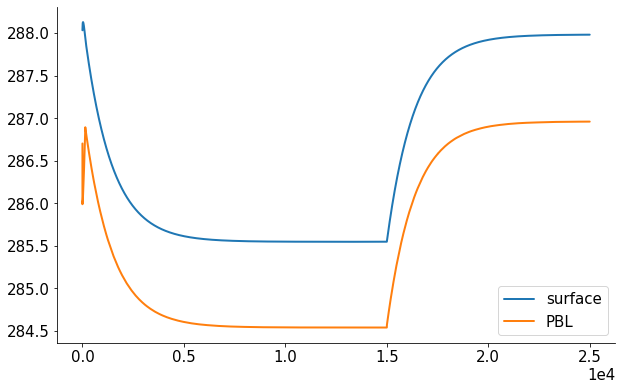

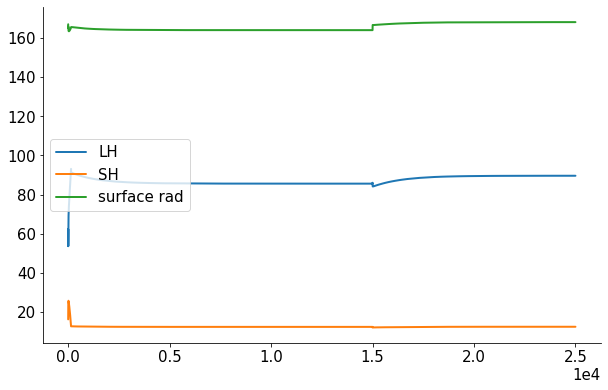

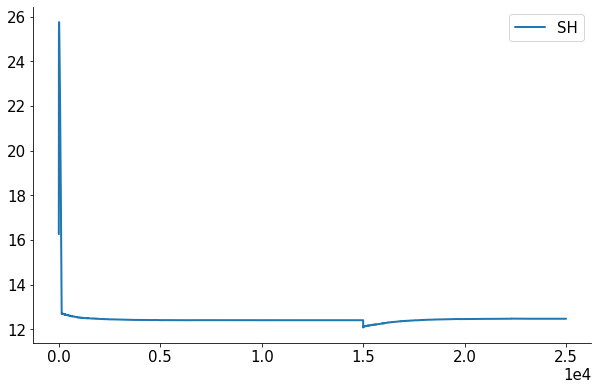

In [10]:
t = status/2
t = np.linspace(0,t,len(Ts_rec))
ini = 0
fin = len(Ts_rec)
plt.plot(t[ini:fin],Ts_rec[ini:fin],label = 'surface')
plt.plot(t[ini:fin],Tbl_rec[ini:fin],label = 'PBL')
plt.legend()
plt.show()
plt.plot(t[ini:fin],LH_rec[ini:fin],label = 'LH')
plt.plot(t[ini:fin],SH_rec[ini:fin],label = 'SH')
plt.plot(t[ini:fin],rads_rec[ini:fin],label = 'surface rad')
plt.legend()
plt.show()
plt.plot(t[ini:fin],SH_rec[ini:fin],label = 'SH')
plt.legend()
plt.show()

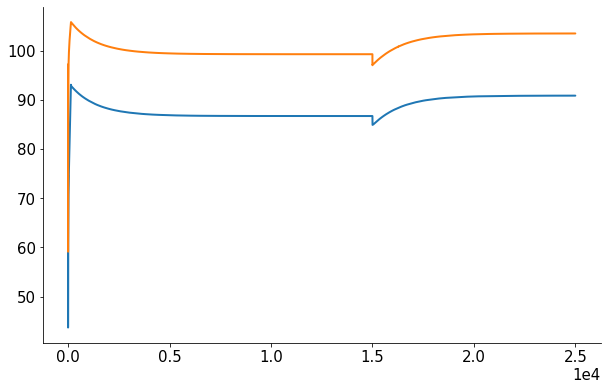

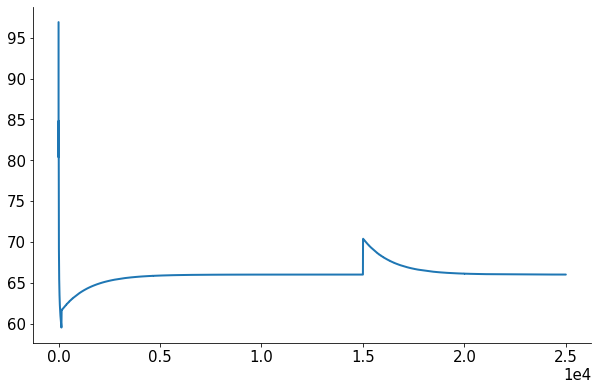

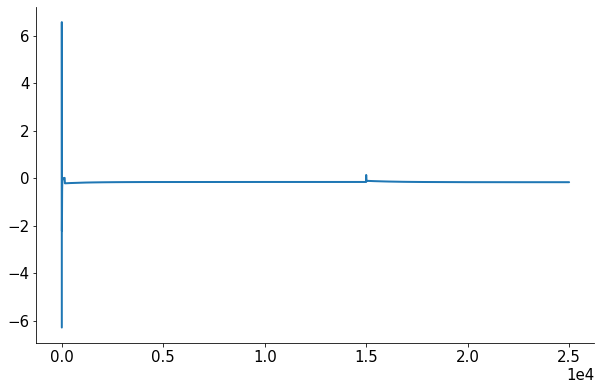

In [11]:
plt.plot(t[ini:fin],PH_rec[ini:fin],label = '-precipitation heating')
plt.plot(t[ini:fin],rada_rec[ini:fin],label = 'troposphere rad')
plt.show()

Esdif = []
for i in range(len(Ts_rec)):
    c = rads_rec[i]-(SH_rec[i]+LH_rec[i])
    Esdif.append(c)
plt.plot(t[ini:fin],Esdif[ini:fin])
plt.show()

Eadif = []
for i in range(len(Ts_rec)):
    c = -rada_rec[i]+(SH_rec[i]+PH_rec[i])
    Eadif.append(c)
plt.plot(t[ini:fin],Eadif[ini:fin])
plt.show()

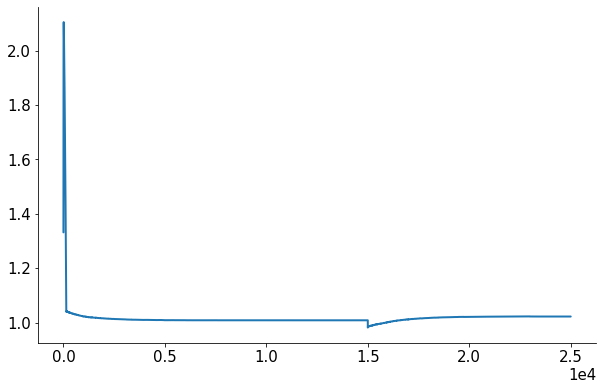

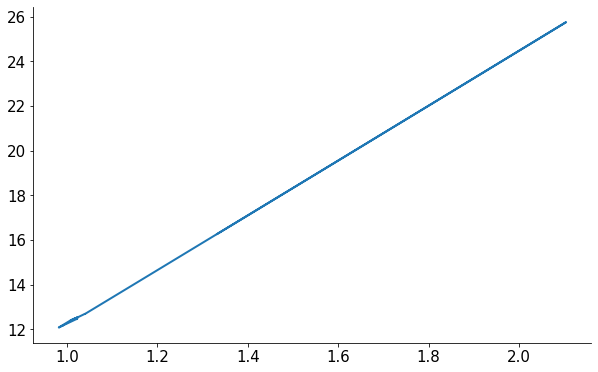

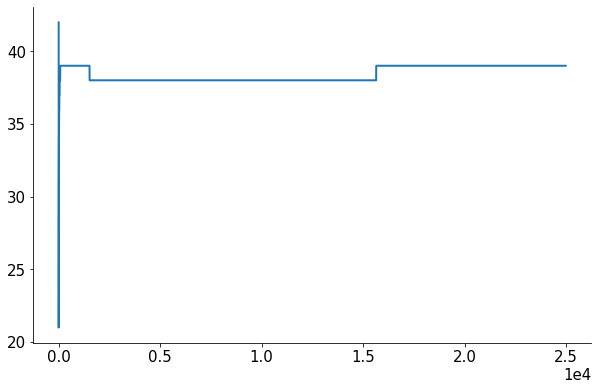

In [12]:
Tdif = []
for i in range(len(Ts_rec)):
    c = Ts_rec[i]-Tbl_rec[i]
    Tdif.append(c)
plt.plot(t[ini:fin],Tdif[ini:fin])
plt.show()
plt.plot(Tdif[ini:fin],SH_rec[ini:fin])
plt.show()
plt.plot(t[ini:fin],ctop_rec[ini:fin])

In [13]:
%%time
atmosphere_rce = konrad.atmosphere.Atmosphere(phlev)
radiation_rce = konrad.radiation.RRTMG(solar_constant=551.58-opacity)
surface_rce = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink = heat_sink,
)

humidity_model = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(),
)
rce = konrad.RCE(
    atmosphere_rce,
    surface=surface_rce,  # Run with a fixed surface temperature.
    timestep='12h',  # Set timestep in model time.
    max_duration=int(ndays)/5, # Set maximum runtime.
    humidity = humidity_model,
    radiation = radiation_rce
)
rce.run()


CPU times: user 3min 30s, sys: 84 ms, total: 3min 30s
Wall time: 3min 30s


[0.87786042]
first with latent heat and precipitation, then without:
surface T 287.9478485175477 286.7038853416334
atmosphere PBL T 287.40268617231334 286.14844802057723
toa radiation [64.57935636] [65.731998]
surface radiation 168.06658765331906 168.2034268283753
atmosphere radiative cooling [-103.4872313] -103.48723129687659 [-102.47142883]
sensible heat [12.46601362]
precipitation heat (J s-1 m-2) and mass (mm day-1) [-90.84753436] [-3.13843541] [-3.09526464]
latent heat evaporation (J s-1 m-2) and mass (mm day-1) 89.59765765167614 3.095256945663662
Column mass of water vapor (kg m-2) [18.03831829]


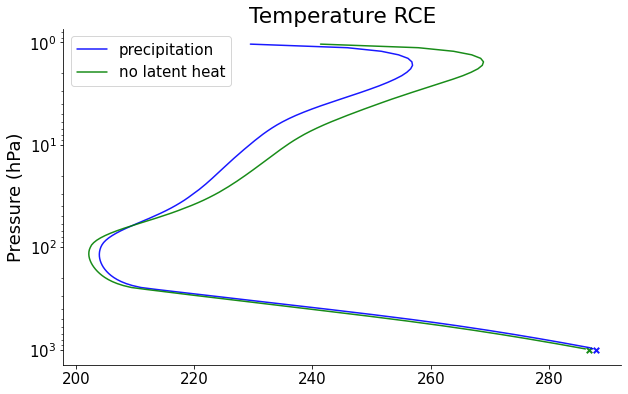

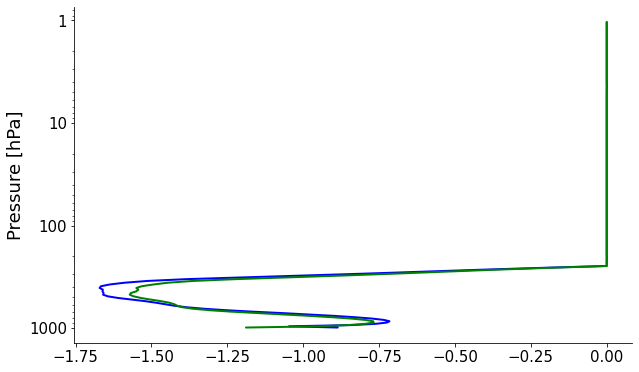

In [14]:
print(prec_eff)
print('first with latent heat and precipitation, then without:')
print('surface T',
      surface['temperature'][0],surface_rce['temperature'][0])
print('atmosphere PBL T',
      atmosphere['T'][0,0],atmosphere_rce['T'][0,0])
print('toa radiation',
      radiation['toa'],rce.radiation['toa'])
rad_surf_rce = (rce.radiation['lw_flxd'][0,0] + rce.radiation['sw_flxd'][0,0] - 
                    (rce.radiation['lw_flxu'][0,0] + rce.radiation['sw_flxu'][0,0]))
print('surface radiation',net_rad_surface, rad_surf_rce)
print('atmosphere radiative cooling',
      radiation['toa']-net_rad_surface, atm_rad, rce.radiation['toa']-rad_surf_rce)
print('sensible heat',SH)
print('precipitation heat (J s-1 m-2) and mass (mm day-1)',
      prec_heating, prec_heating/Lv * seconds_day, prec_mass * 2)
print('latent heat evaporation (J s-1 m-2) and mass (mm day-1)', 
      LH, LH/Lv * seconds_day)
print('Column mass of water vapor (kg m-2)', M_w)


fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_title('Temperature RCE')
ax.set_ylabel('Pressure (hPa)')
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'blue', lw = 1.5, label = 'precipitation')
ax.plot(atmosphere_rce['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'green', lw = 1.5, label = 'no latent heat')
ax.scatter(surface['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'blue', s = 30, marker ='x')
ax.scatter(surface_rce['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'green', s = 30, marker ='x')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        radiation['net_htngrt'][0], color = 'blue', label = 'precipitation')
plots.profile_p_log(atmosphere['plev'], 
                        rce.radiation['net_htngrt'][0], color = 'green', label = 'no latent heat')
plt.show()

In [15]:
print((net_rad_surface)
                               * seconds_day * timestep / surface.heat_capacity)
print((165)
                               * seconds_day * timestep / surface.heat_capacity)

0.03384729084614833
0.0332297041761482


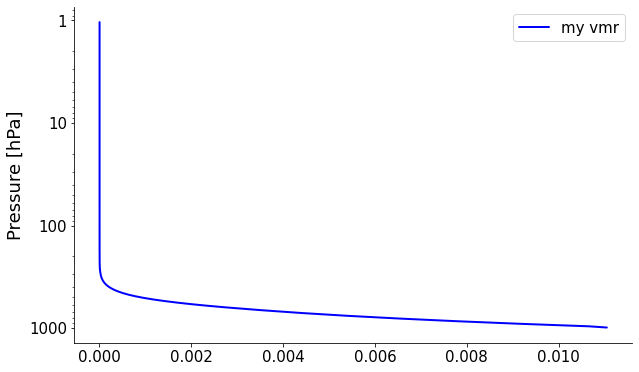

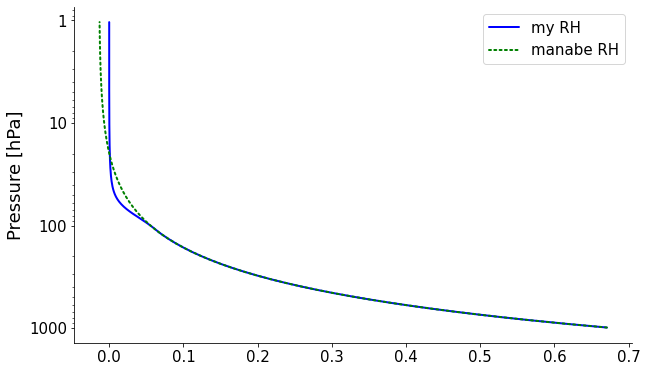

In [16]:
fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        atmosphere['H2O'][0], color = 'blue', label = 'my vmr')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        vmr_to_rh(atmosphere['H2O'][0],atmosphere['T'][0],atmosphere['plev']),
                    color = 'blue', label = 'my RH')
plots.profile_p_log(atmosphere['plev'], RH, 
                    color = 'green', label = 'manabe RH', linestyle = 'dotted')
plt.legend()
plt.show()

In [17]:
print(atmosphere['phlev'][:4])

[100000.          97317.22068295  94666.49309856  92049.14849365]


In [18]:
print(atmosphere['plev'][:4])
print(np.gradient(atmosphere['plev'][:4]))

[98649.49096825 95982.70677655 93348.64798487 90748.60669154]
[-2666.7841917  -2650.42149169 -2617.05004251 -2600.04129333]


In [19]:
print(atmosphere['plev'][:conv_top])

[98649.49096825 95982.70677655 93348.64798487 90748.60669154
 88183.79685561 85655.35445494 83164.33780182 80711.72801105
 78298.42961472 75925.27131802 73593.00689003 71302.31618318
 69053.80627507 66848.01272581 64685.40094449 62566.3676576
 60491.24247274 58460.28953049 56473.7092376  54531.6400743
 52634.1604689  50781.29073271 48972.99504834 47209.18350463
 45489.71417153 43814.39520823 42182.98699838 40595.20430578
 39050.71844465 37549.15945857 36090.11830215 34673.14902021
 33297.77091887 31963.47072369 30669.70471994 29415.90087041
 28201.46090639 27025.7623878  25888.16072851]


In [20]:
print(conv_top)

39


In [21]:
print(np.append(288,konrad.lapserate.get_moist_adiabat(atmosphere['plev'],288,T_min=0.)[:-1]))
print(moist_adiabat(atmosphere['plev'],288,T_radiation))

[288.         286.91074819 285.78699423 284.63358029 283.44984575
 282.23390657 280.98446936 279.70006424 278.37899188 277.01972439
 275.62031169 274.1788464  272.69315918 271.16005773 269.57587576
 267.93652599 266.23743183 264.47425117 262.64334642 260.74139119
 258.76601342 256.71590284 254.5908483  252.39254198 250.12382096
 247.78889956 245.39229446 242.93841961 240.43238005 237.87990387
 235.28683325 232.6587949  230.00153622 227.32001265 224.619082
 221.90279903 219.17483126 216.43811928 213.6954729  210.94897577
 208.20032362 205.45110856 202.70248984 199.95544397 197.21075109
 194.46899304 191.73056085 188.99605879 186.26562889 183.53939193
 180.81758685 178.10025596 175.38740907 172.67893938 169.97478832
 167.274698   164.57854957 161.88596847 159.19659858 156.50993667
 153.8255721  151.14278845 148.46090502 145.77909605 143.09644952
 140.41179114 137.72387156 135.0314547  132.33278691 129.62603772
 126.90916011 124.17974784 121.4349945  118.67176745 115.88643009
 113.0746413